# PD Analysis

In [3]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2


In [119]:
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
sns.set_context('talk')
import matplotlib_venn

## Preprocessing

In [2]:
# file directories
workingDirectory = '/home/jenhan/analysis/pd_analysis/'
binDirectory = '/home/jenhan/bin/'
genomePath = '/bioinformatics/homer/data/genomes/hg38'
genomes = ['hg38','mm10']
peakDirectory = workingDirectory + 'peaks/'
scratchDirectory = workingDirectory + '/scratch/'
logFilePath = workingDirectory + '/log_files/'
tagDirPath= workingDirectory + '/tag_directories/'
inputDirectory = workingDirectory + '/input/'
idrDirectory = workingDirectory + '/idr/'


os.chdir(workingDirectory)

# map ugly file names to prettier looking file names
# if not os.path.isfile("nameMapping.tsv"):
nameMappingFile = open("nameMapping.tsv", "w")
for f in os.listdir(logFilePath):
    rootName = f
    for gen in genomes:
        rootName = rootName.replace('.' + gen + '.star.log','').replace('.' +gen + '.bowtie2.log','')
    nameMappingFile.write(rootName + '\t' + rootName + '\n')
nameMappingFile.close()

# read in and parse name mapping file and create a DataFrame representation
with open("nameMapping.tsv") as f:
    data = f.readlines()
strains = []
treatments = []
owners = []
dates = []
originalNames = []
cleanedNames = []
for line in data:
    tokens = line.strip().split("\t")
    originalName = tokens[0]
    metaDataTokens = tokens[1].split('_')
    
    originalNames.append(originalName)
    cleanedNames.append(tokens[1])
    # grab metadata from string tokens
    strain = metaDataTokens[0].strip().split('-')[0]
    treatment = metaDataTokens[2].strip()
    owner = metaDataTokens[3].strip()
    date = metaDataTokens[4].strip()
    
    # append to overall lists
    strains.append(strain)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  treatments, 
                                  owners, 
                                  originalNames, 
                                  cleanedNames]).transpose()
metadata_frame.columns = ['strain', 
                         'treatment', 
                         'owner', 
                         'originalName', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = '-'.join([x for x in t.split('-')][:-1])
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

# create dictionary for convenience
originalName_cleanedName_dict = dict(zip(metadata_frame["originalName"], metadata_frame["sampleName"])) # {originalName:newName}
cleanedName_originalName_dict = dict(zip(metadata_frame["sampleName"], metadata_frame["originalName"])) # {newName:originalName}

### read in log files ###

# create data frame summarizing mapping quality logs
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_originalNames =[]
# from tagInfo.txt
_fragmentLengthEstimate =[]
_peakSizeEstimate = []
_tagsPerBP = []
_averageTagsPerPosition = []
_averageTagLength = []
_averageFragmentGCcontent = []

for logFile in os.listdir(logFilePath):
    with open(logFilePath + '/' + logFile) as f:
        data = f.readlines()
    rootName = logFile
    for gen in genomes:
        rootName = rootName.replace('.' + gen + '.star.log','').replace('.' +gen + '.bowtie2.log','')
    totalReads = int(data[5].split()[5])
    uniquelyMappedReads = int(data[8].split()[5])
    multiMappedReads = int(data[23].split()[8])
    unmappedReads = totalReads - uniquelyMappedReads - multiMappedReads
#     pbc = float(data[-1].split()[-1])

    _originalNames.append(rootName)
    _totalReads.append(totalReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)
for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _fragmentLengthEstimate.append(float(data[2].strip().split('=')[1]))
        _peakSizeEstimate.append(float(data[3].strip().split('=')[1]))
        _tagsPerBP.append(float(data[4].strip().split('=')[1]))
        _averageTagsPerPosition.append(float(data[5].strip().split('=')[1]))
        _averageTagLength.append(float(data[6].strip().split('=')[1]))
        _averageFragmentGCcontent.append(float(data[8].strip().split('=')[1]))
mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads,
                                   _fragmentLengthEstimate,
                                   _peakSizeEstimate,
                                   _tagsPerBP,
                                   _averageTagsPerPosition,
                                   _averageTagLength,
                                   _averageFragmentGCcontent,
                                  ]).transpose()
mappingStats_frame.columns = ['originalName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads',
                              'fragmentLengthEstimate',
                              'peakSizeEstimate',
                              'tagsPerBP',
                              'averageTagsPerPosition',
                              'averageTagLength',
                              'averageFragmentGCcontent']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']


summary_frame = metadata_frame.merge(mappingStats_frame, on='originalName')


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['simpleTreatment'].values)])
summary_frame = summary_frame.sort()
summary_frame.to_csv('qc_metrics.tsv', sep='\t', index=False)

## Mapping Quality Control

### Plot Distributions of Mapping Statistics

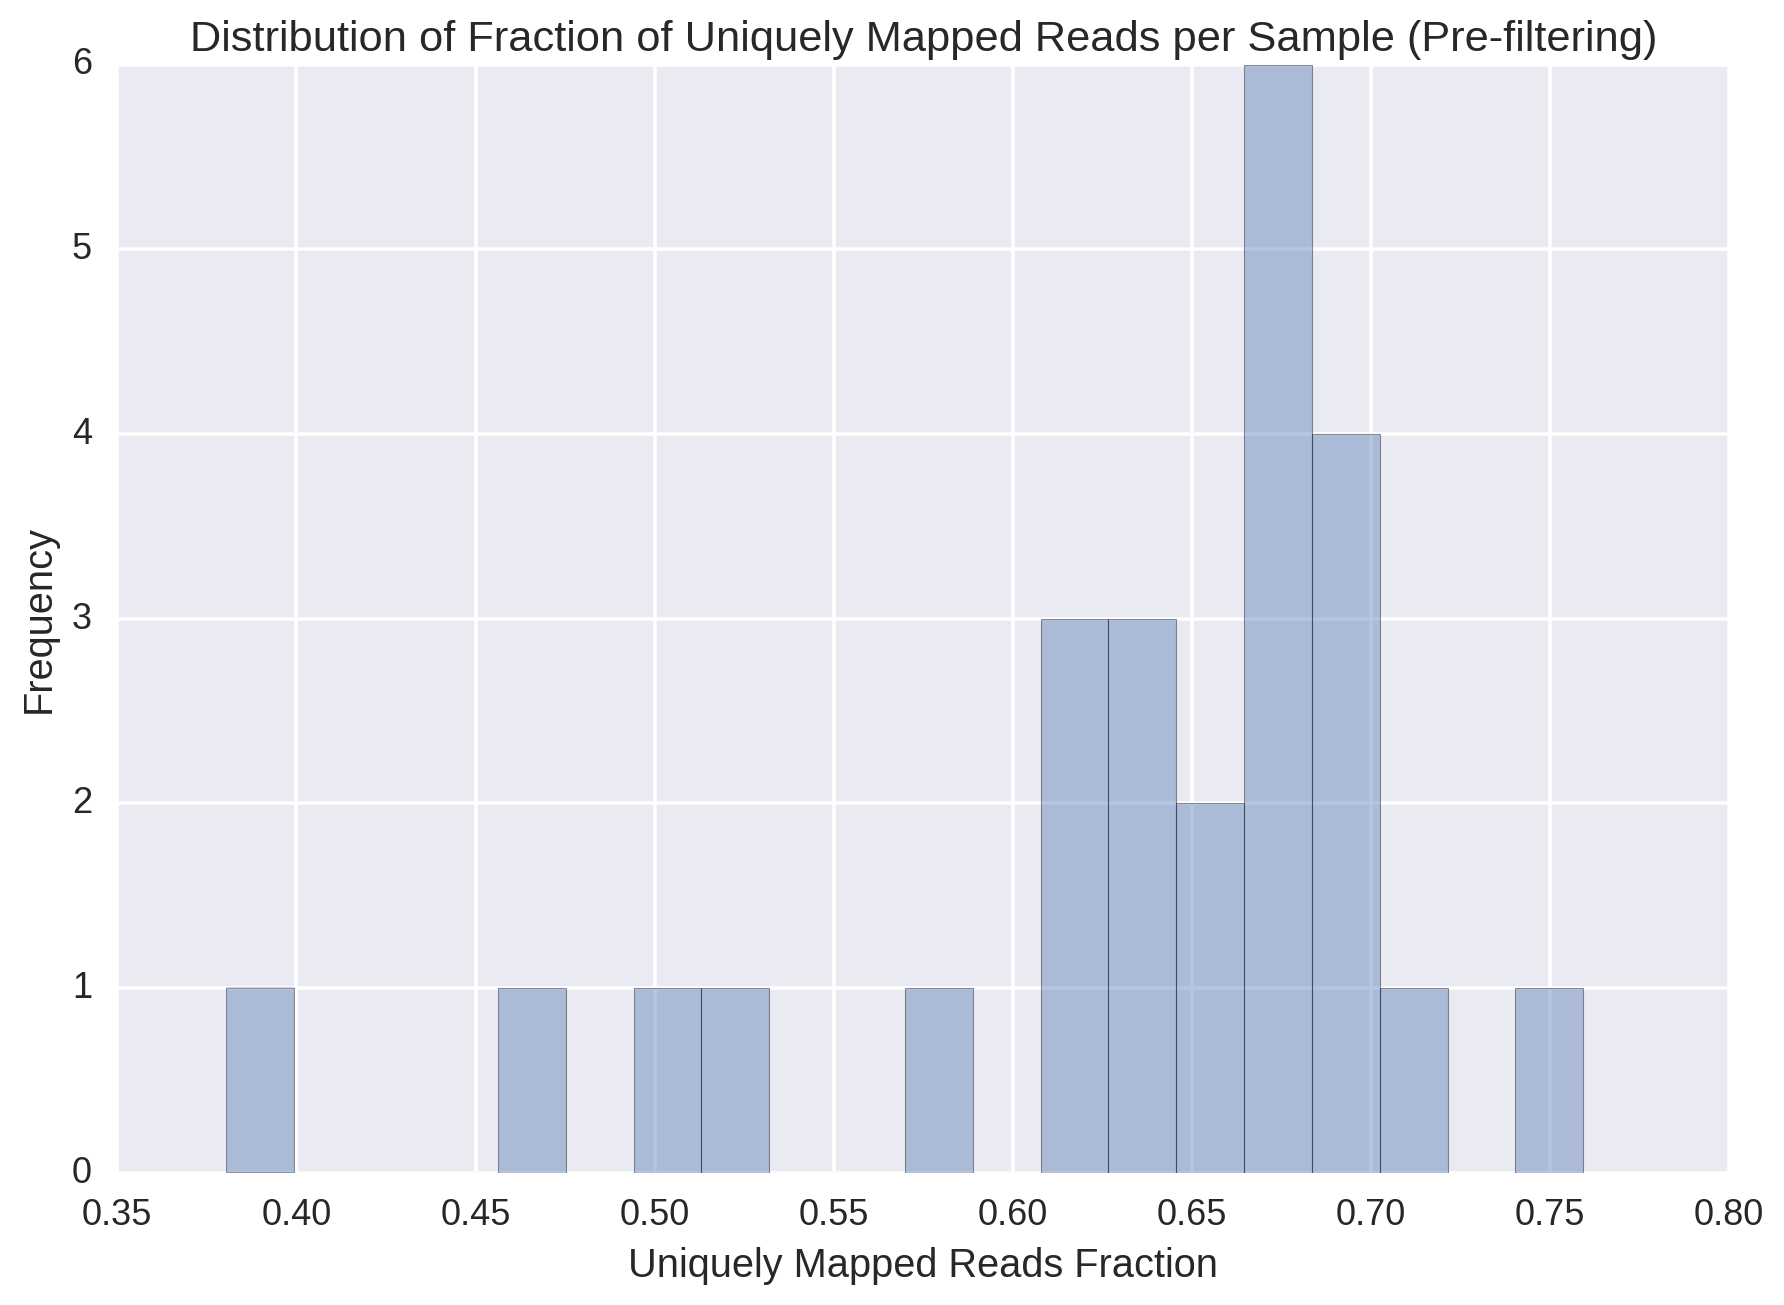

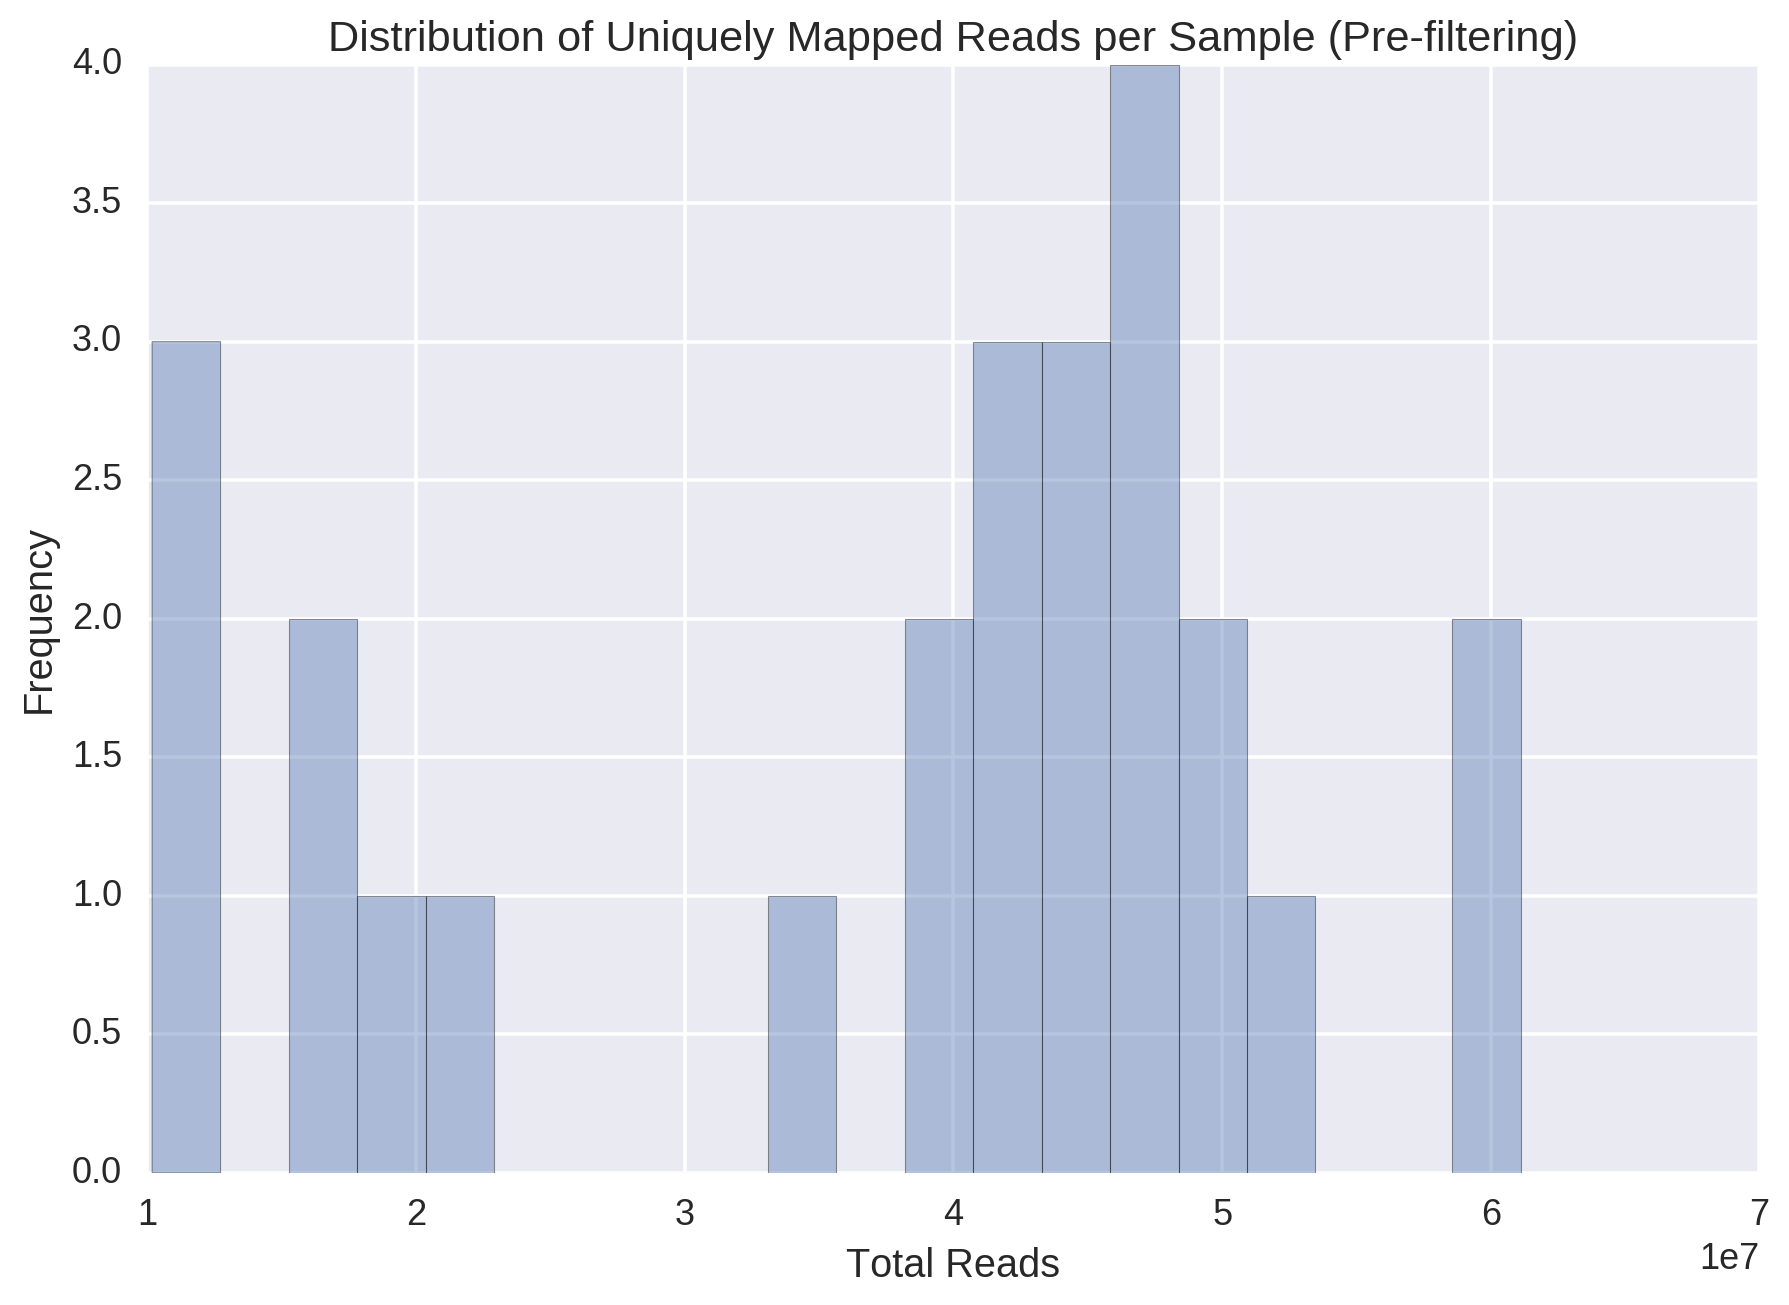

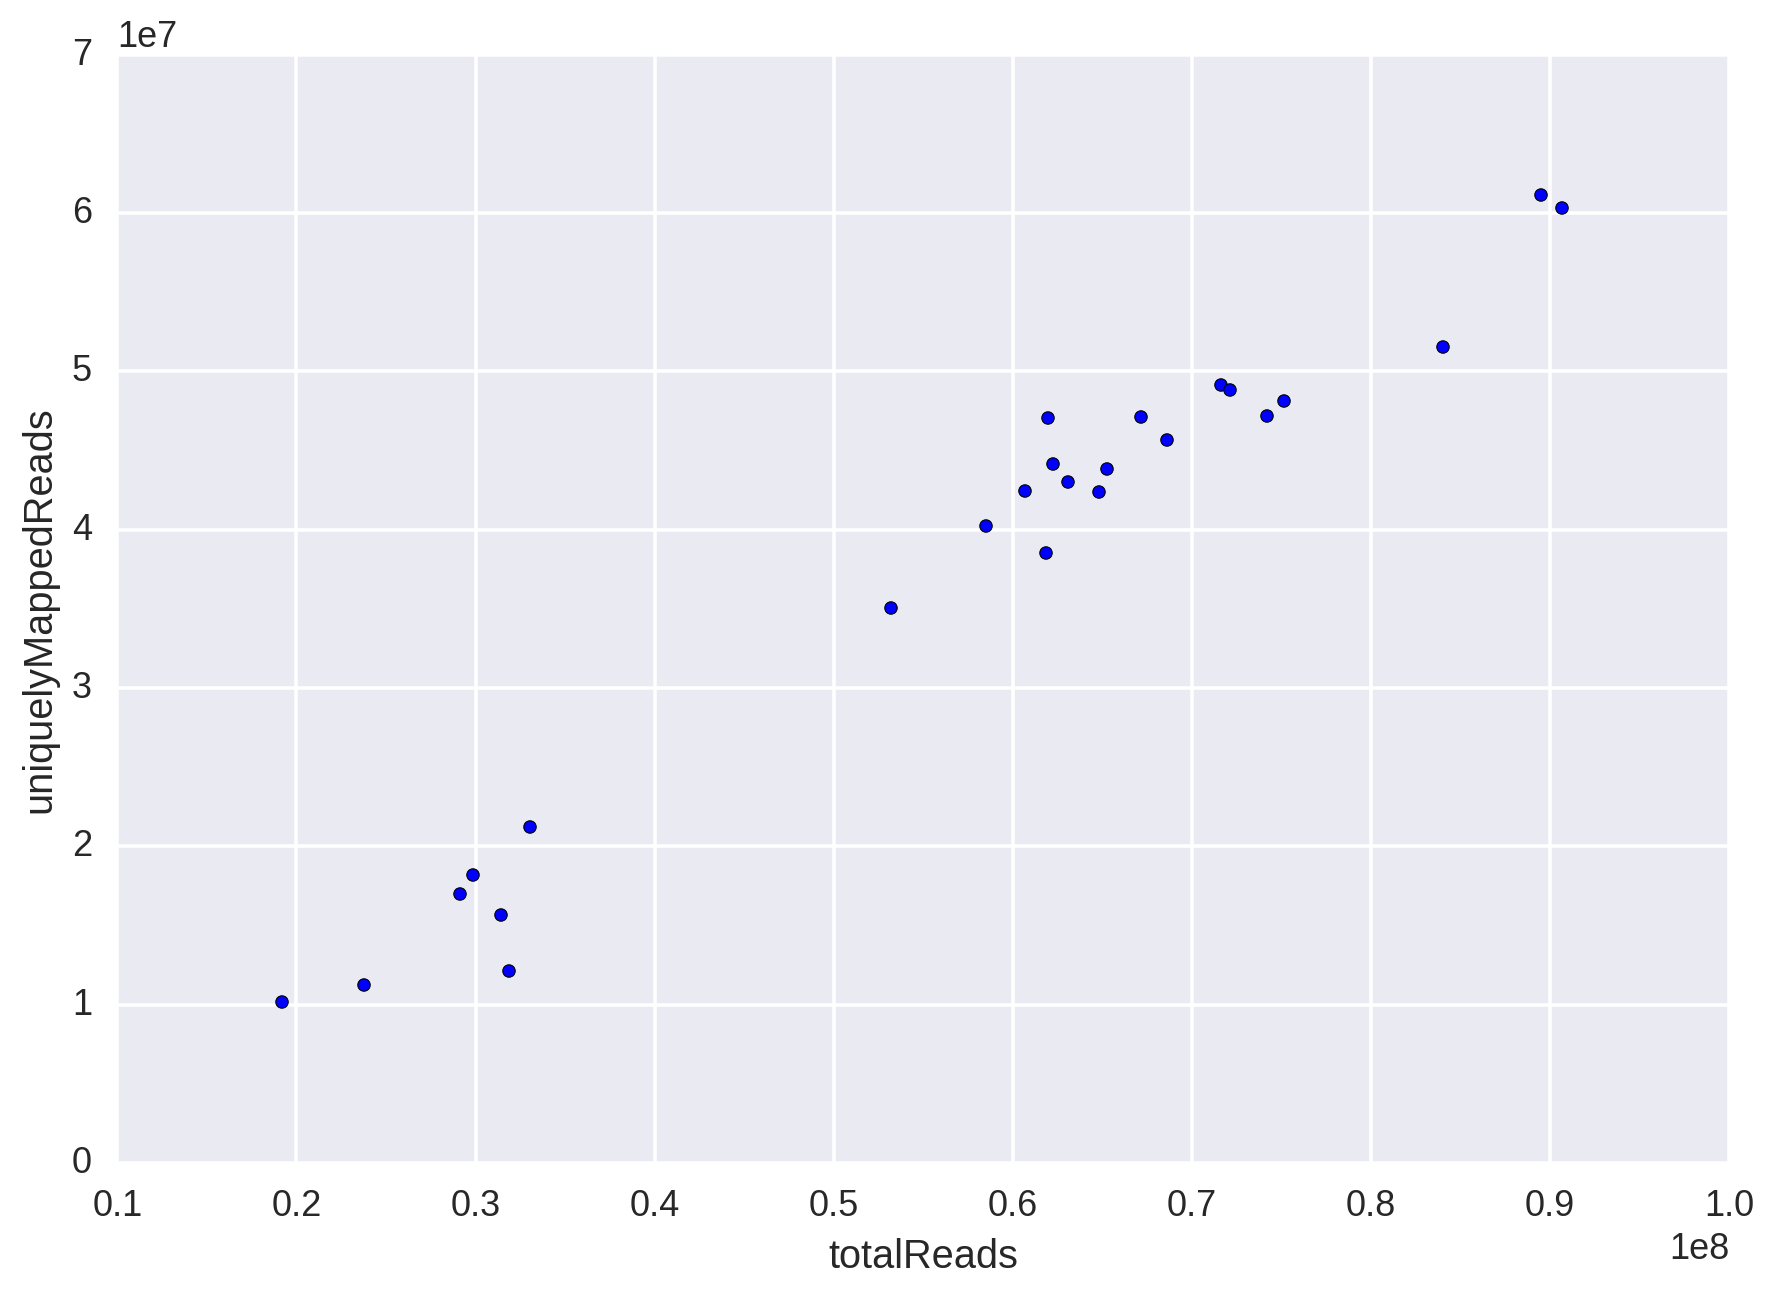

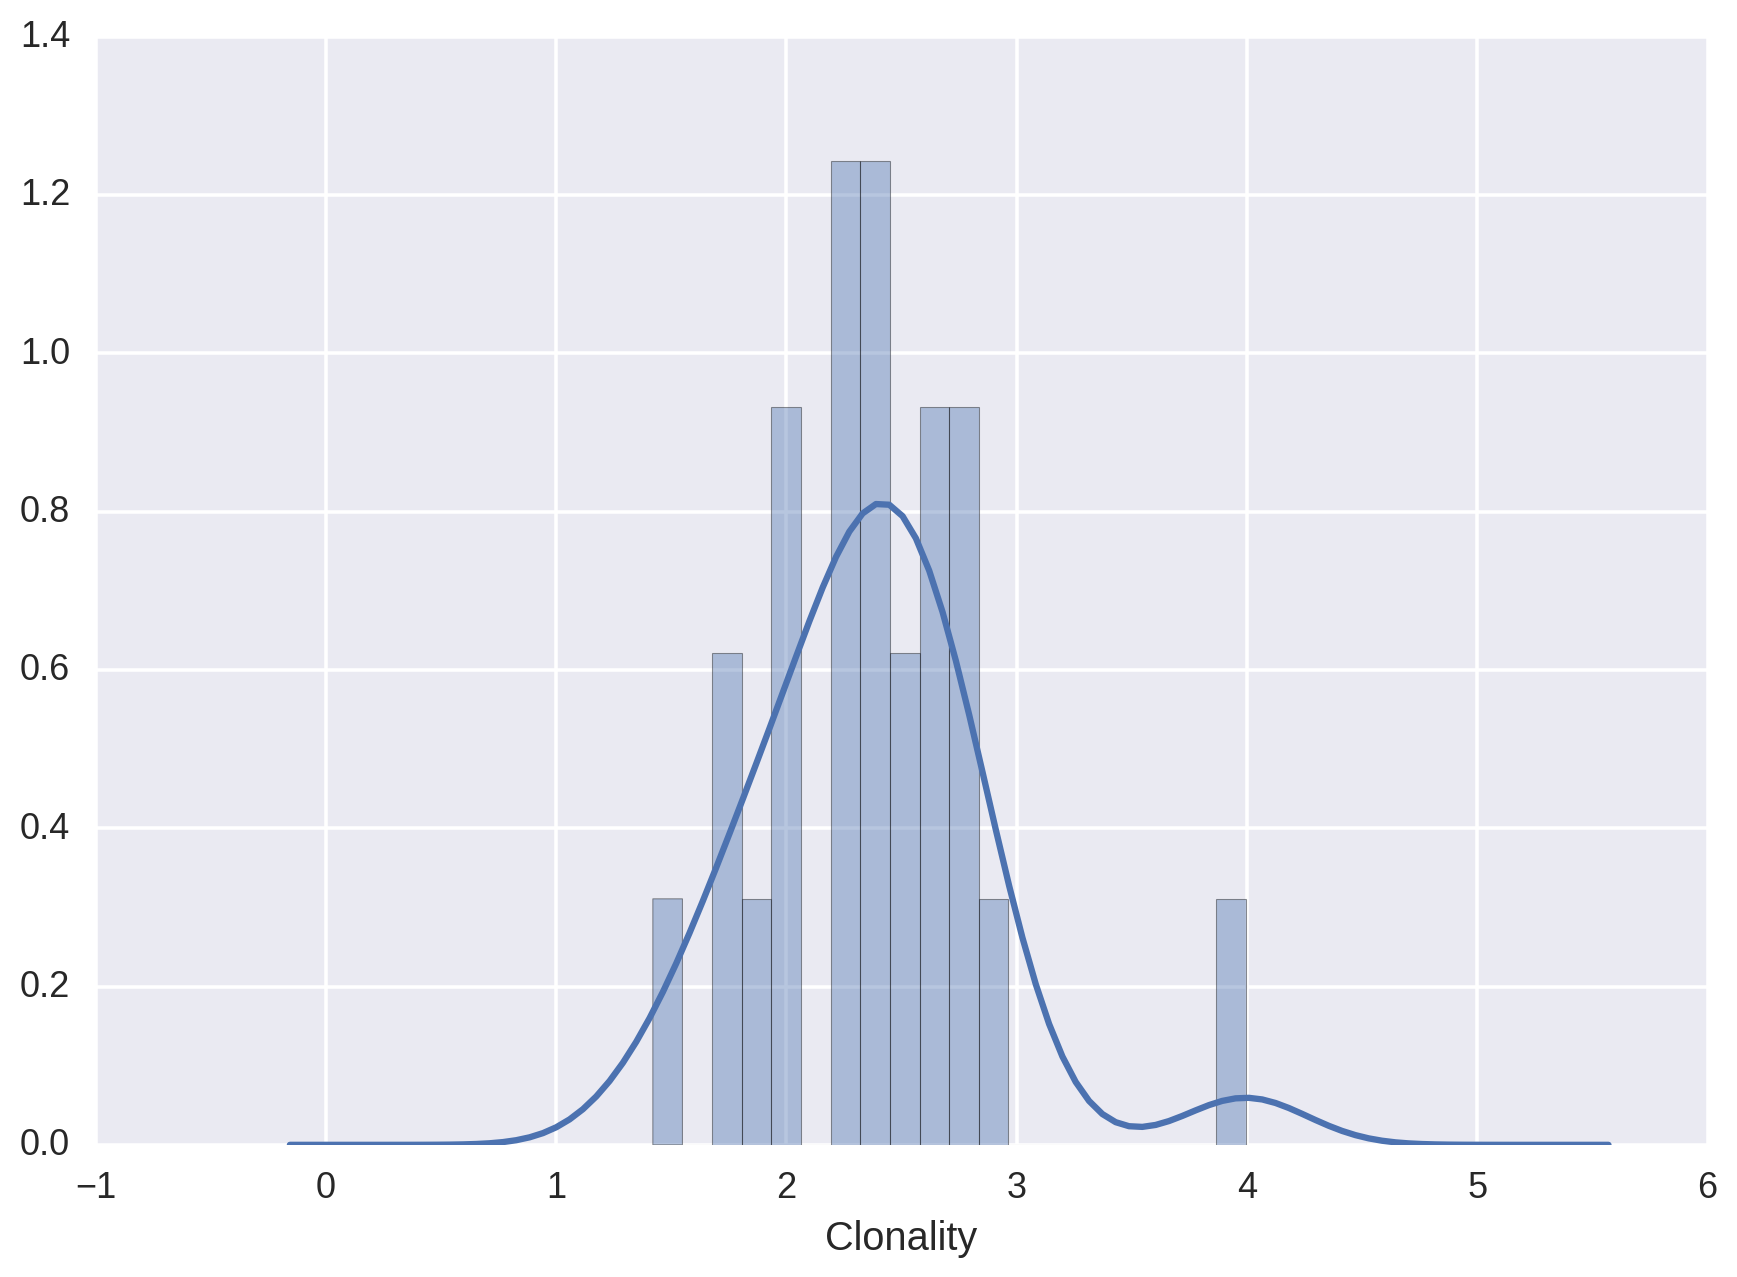

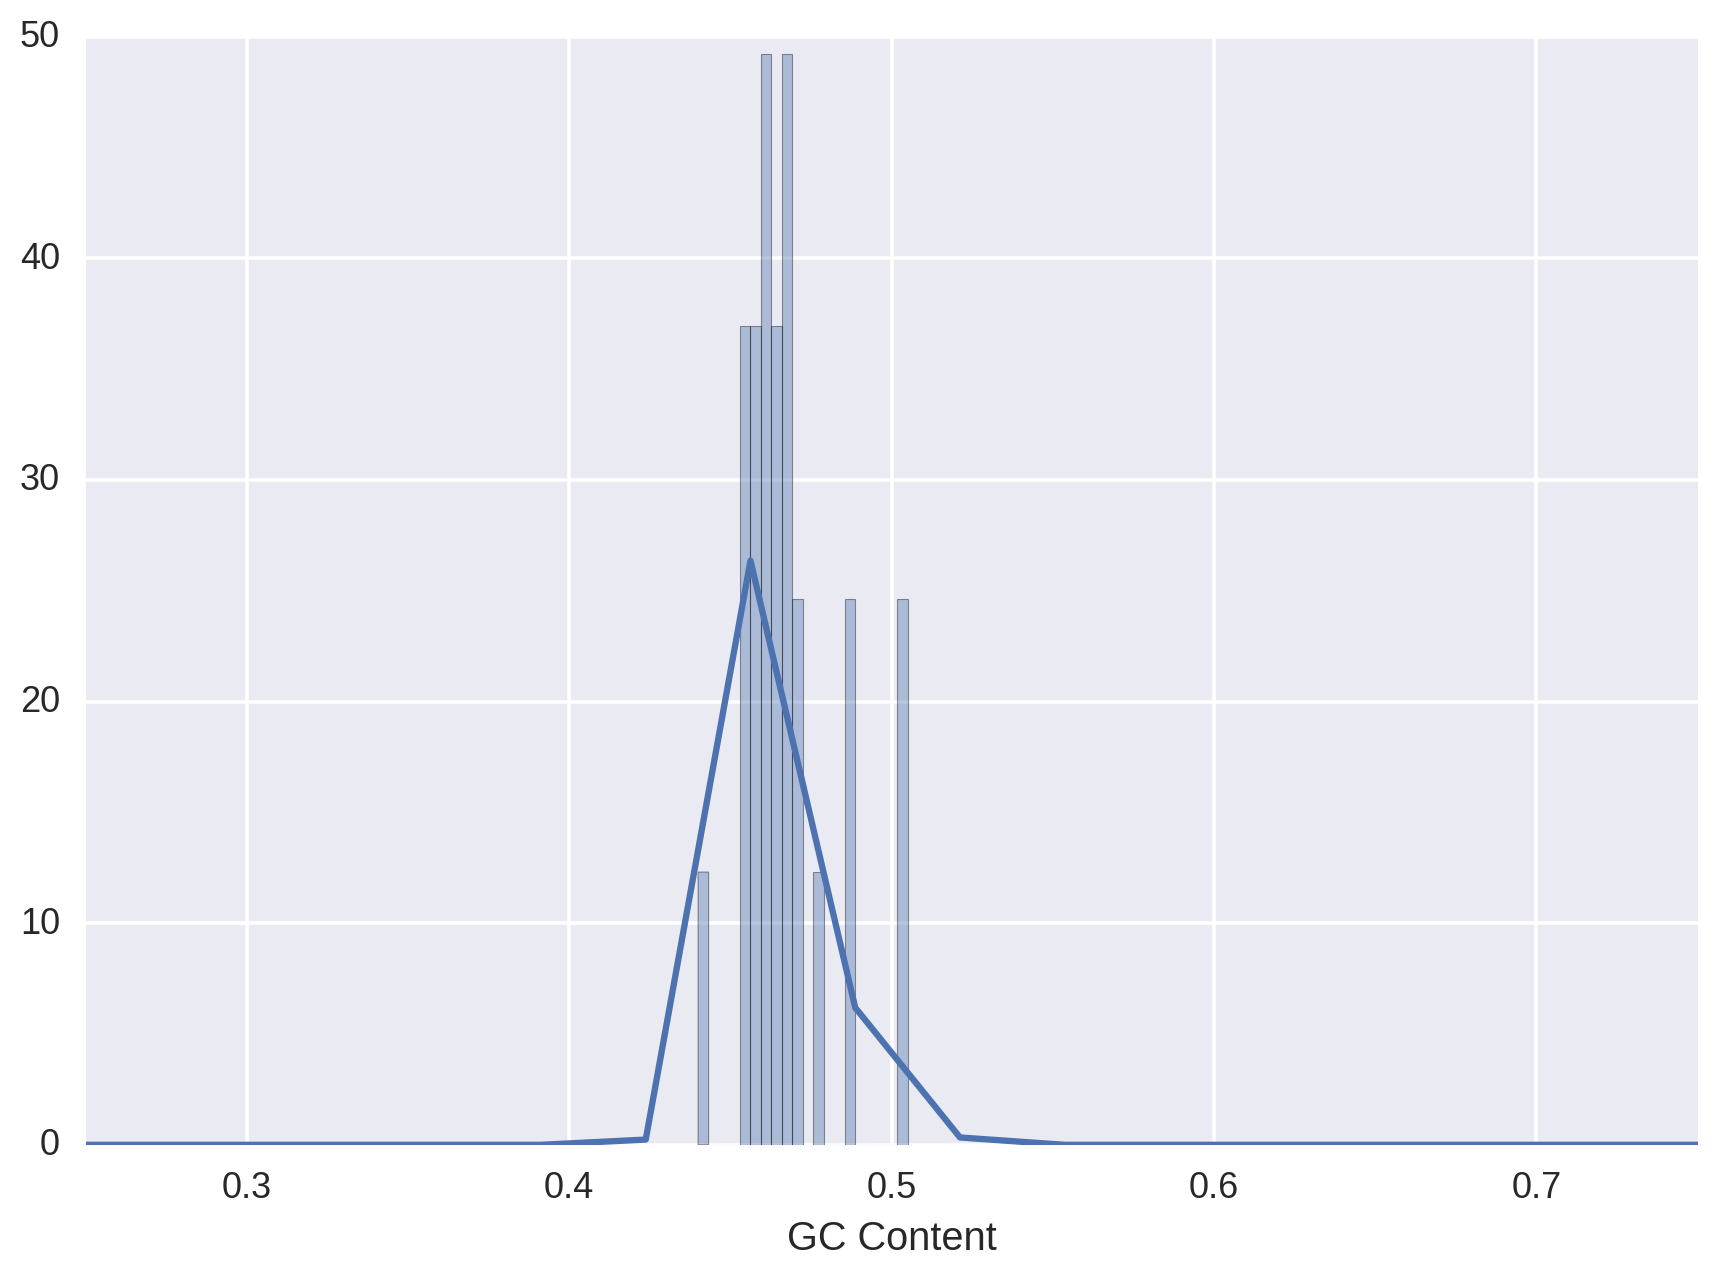

In [3]:
# plot distribution of uniquely mapped reads
sns.distplot(summary_frame['uniquelyMappedFraction'], bins=20, kde=False)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(summary_frame['uniquelyMappedReads'], bins=20, kde=False)
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Total Reads')
plt.ylabel('Frequency')
plt.show()

plt.scatter(summary_frame['totalReads'], y=summary_frame['uniquelyMappedReads'])
plt.xlabel('totalReads')
plt.ylabel('uniquelyMappedReads')
plt.show()

sns.distplot(summary_frame['averageTagsPerPosition'], bins=20)
plt.xlabel('Clonality')
plt.show()

sns.distplot(summary_frame['averageFragmentGCcontent'], bins=20)
plt.xlabel('GC Content')
plt.xlim([0.25,0.75])
plt.show()



### Filter Samples According to Mapping Quality

In [4]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.5
uniquelyMappedReadThreshold = 9000000
pbcThreshold=0.0
gcThreshold=0.10
clonalityThreshold = 3.0
# spotThreshold = 0.005

filtered_summary_frame = summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

filtered_summary_frame = filtered_summary_frame[np.abs(filtered_summary_frame['averageFragmentGCcontent'] - 0.5) <=gcThreshold]

filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['averageTagsPerPosition'] <= clonalityThreshold]


# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
# simpleTreatmentCombos = filtered_summary_frame["strain"].values + '_' +filtered_summary_frame["simpleTreatment"].values
# for simpleNameRoot in simpleTreatmentCombos:
#     if not simpleNameRoot in factorTreatment_count_dict:
#         factorTreatment_count_dict[simpleNameRoot] = 1
#     else:
#         factorTreatment_count_dict[simpleNameRoot] += 1
#     simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot]))
#     print(simplifiedName)
#     simplifiedNames.append(simplifiedName)
simplifiedNames = [x.split('_')[2] for x in filtered_summary_frame['originalName'].values]

filtered_summary_frame["simplifiedName"] = simplifiedNames
sampleName_simpleName_dict = dict(zip(filtered_summary_frame["sampleName"], filtered_summary_frame["simplifiedName"])) # {newName:simplifiedName}
simpleName_sampleName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["sampleName"])) # {simplifiedName:newName}

originalName_simpleName_dict = dict(zip(filtered_summary_frame["originalName"], filtered_summary_frame["simplifiedName"]))
simpleName_originalName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["originalName"])) 

filtered_summary_frame.to_csv('filtered_qc_metrics.tsv', sep='\t', index=False)

Number of Samples: 25
Number of discarded samples: 4
Number of Samples remaining after filtering: 21


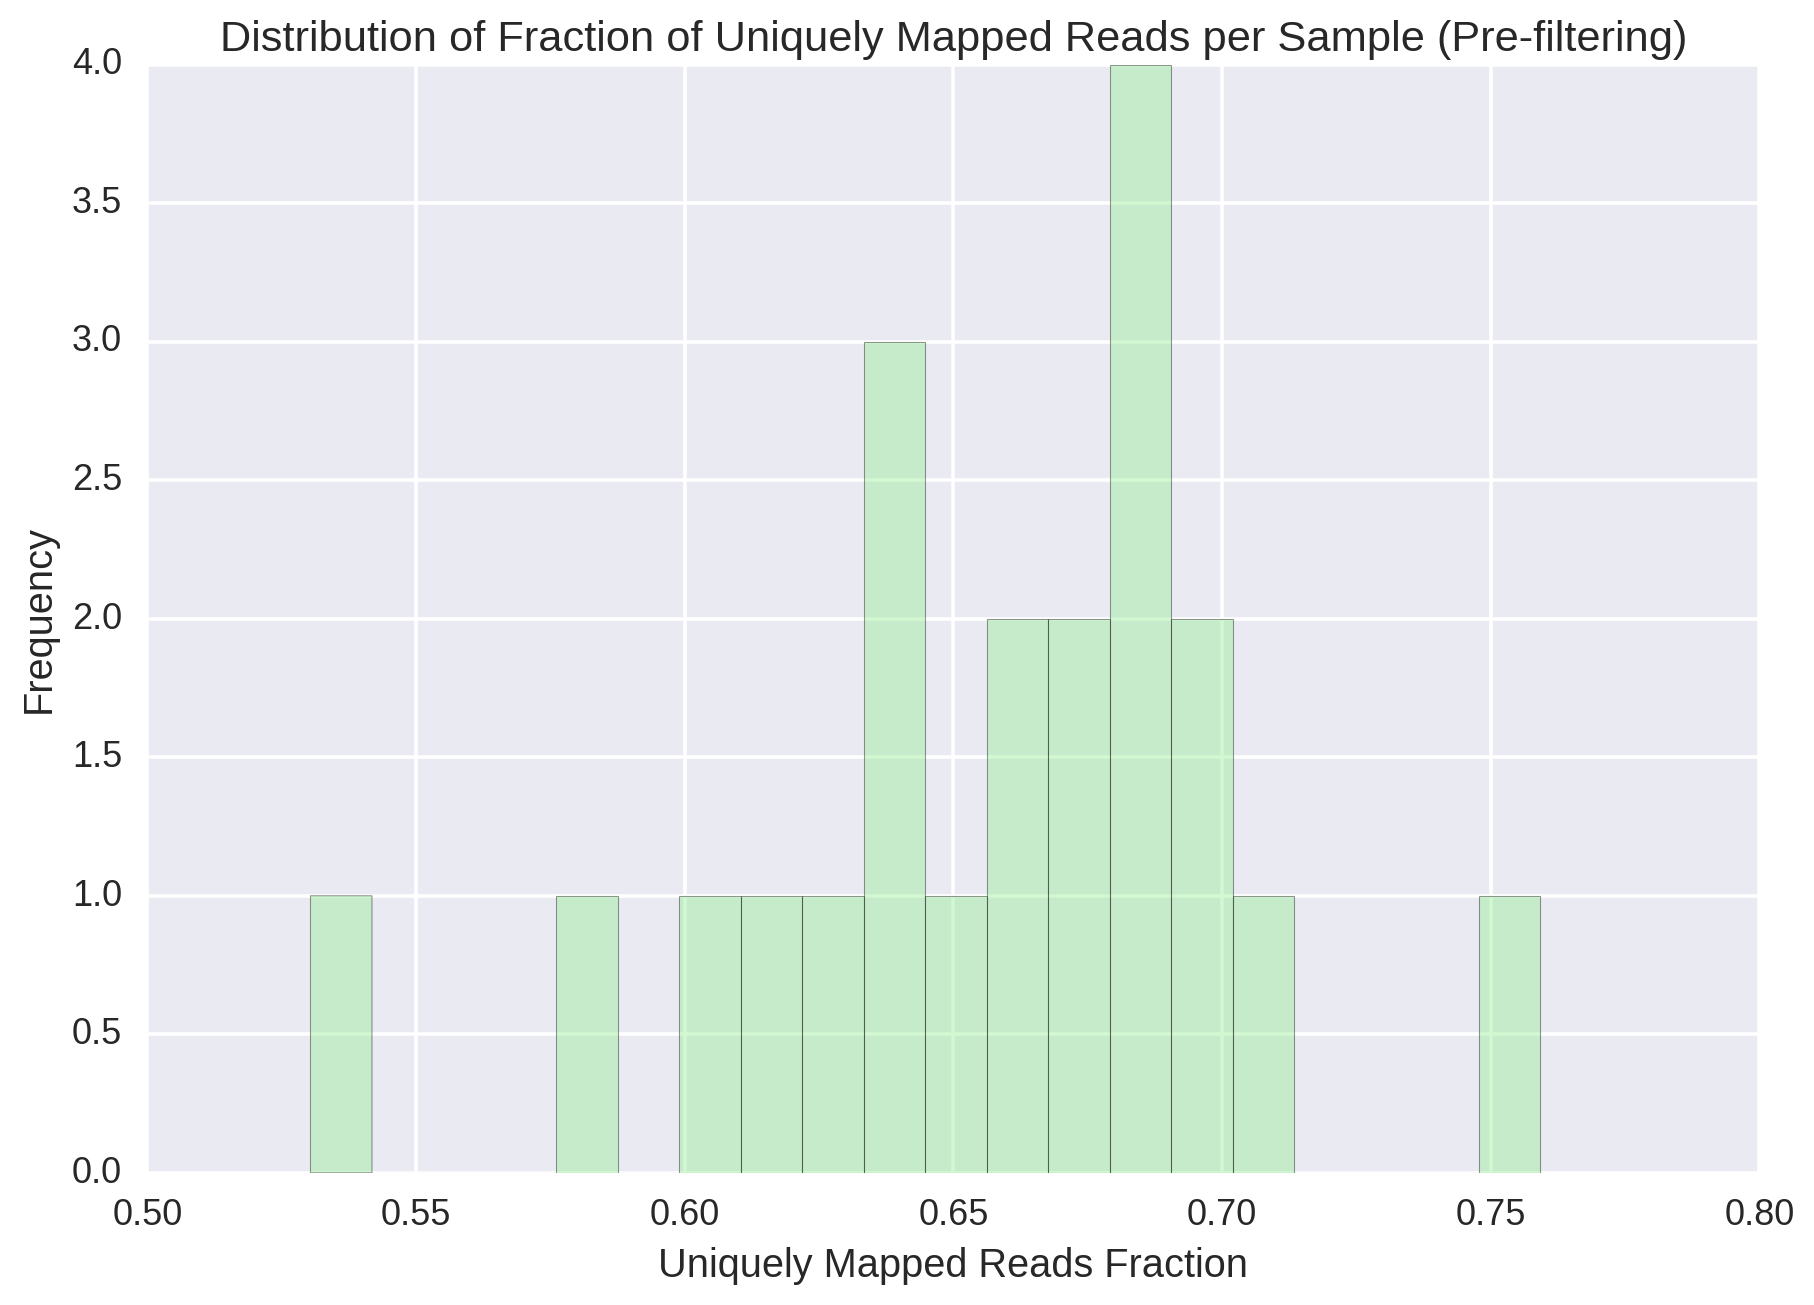

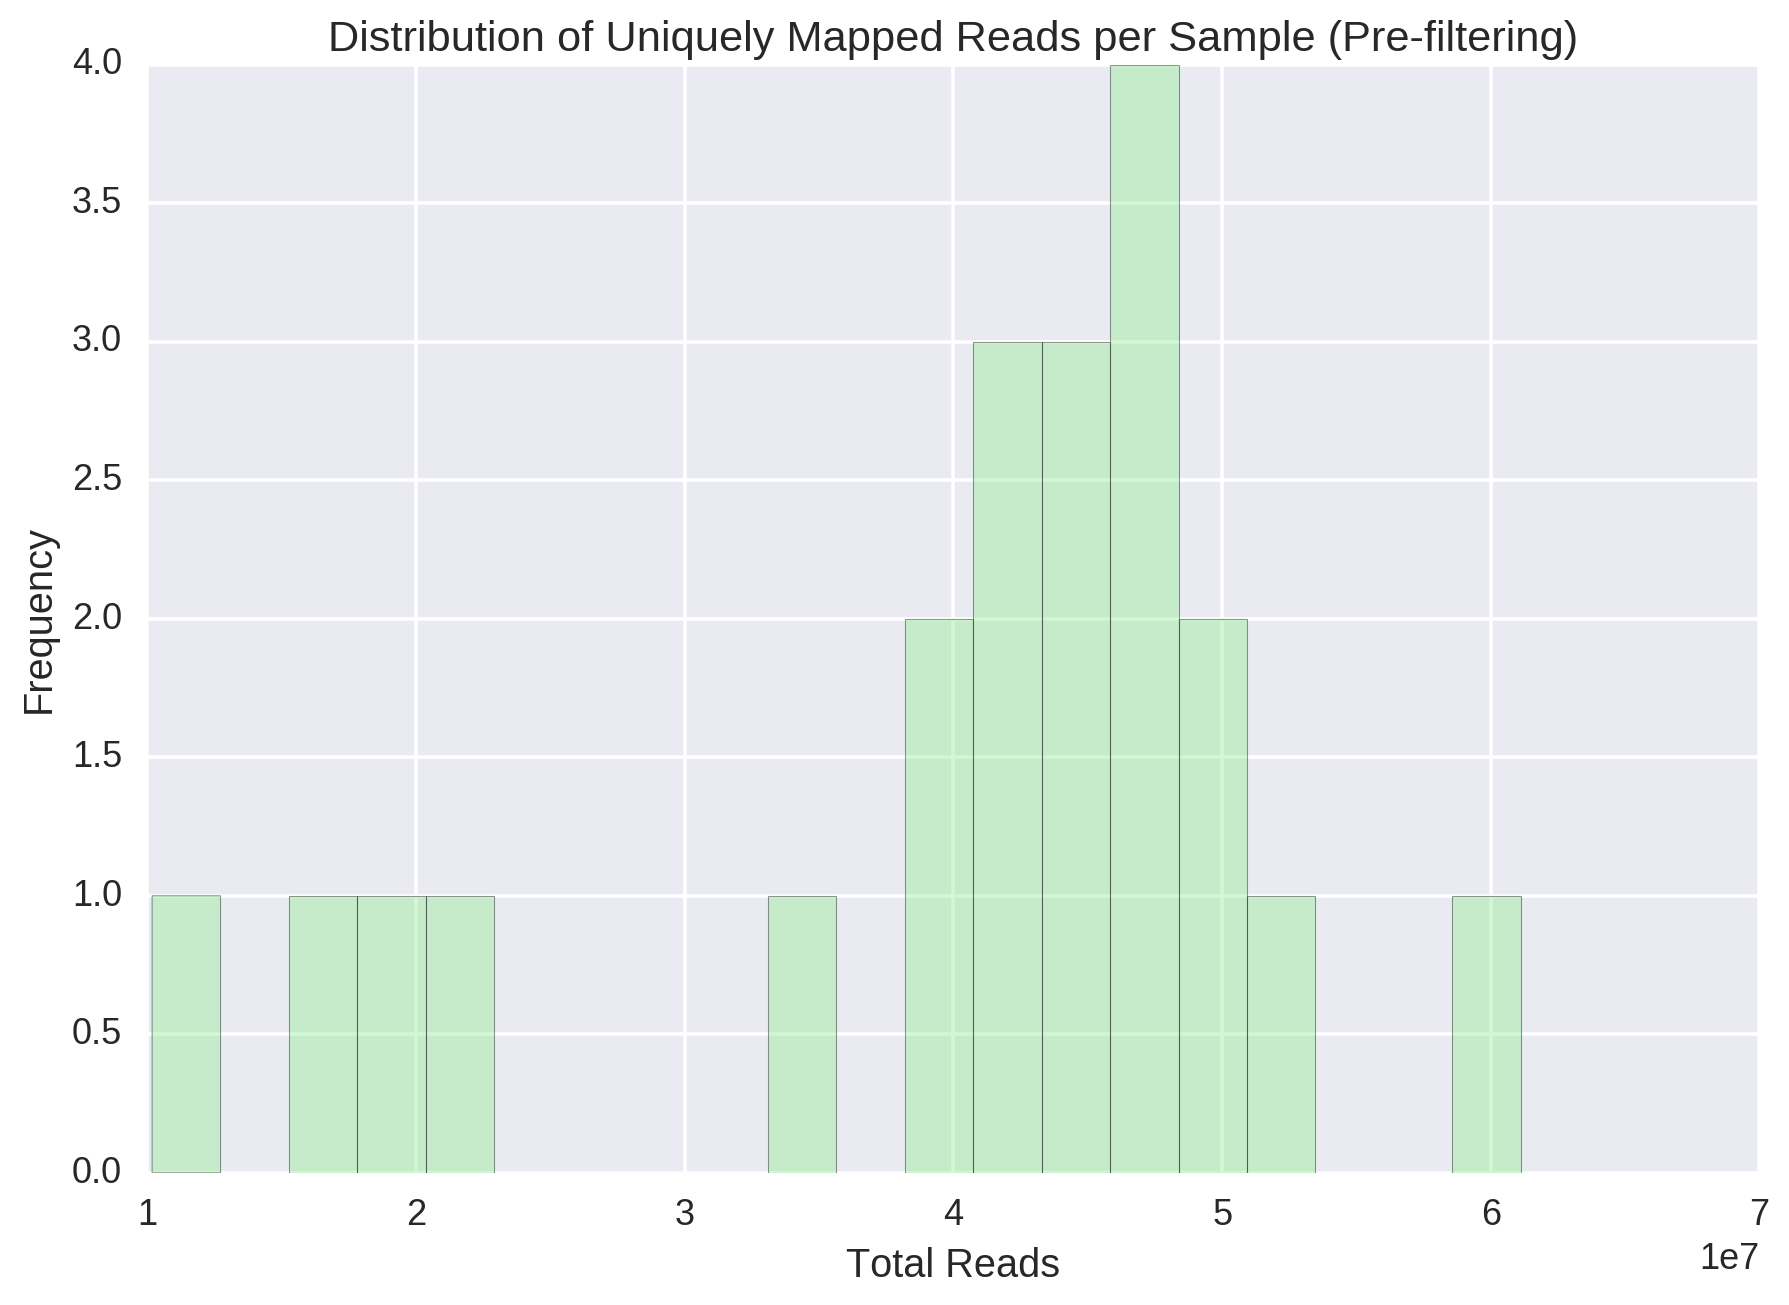

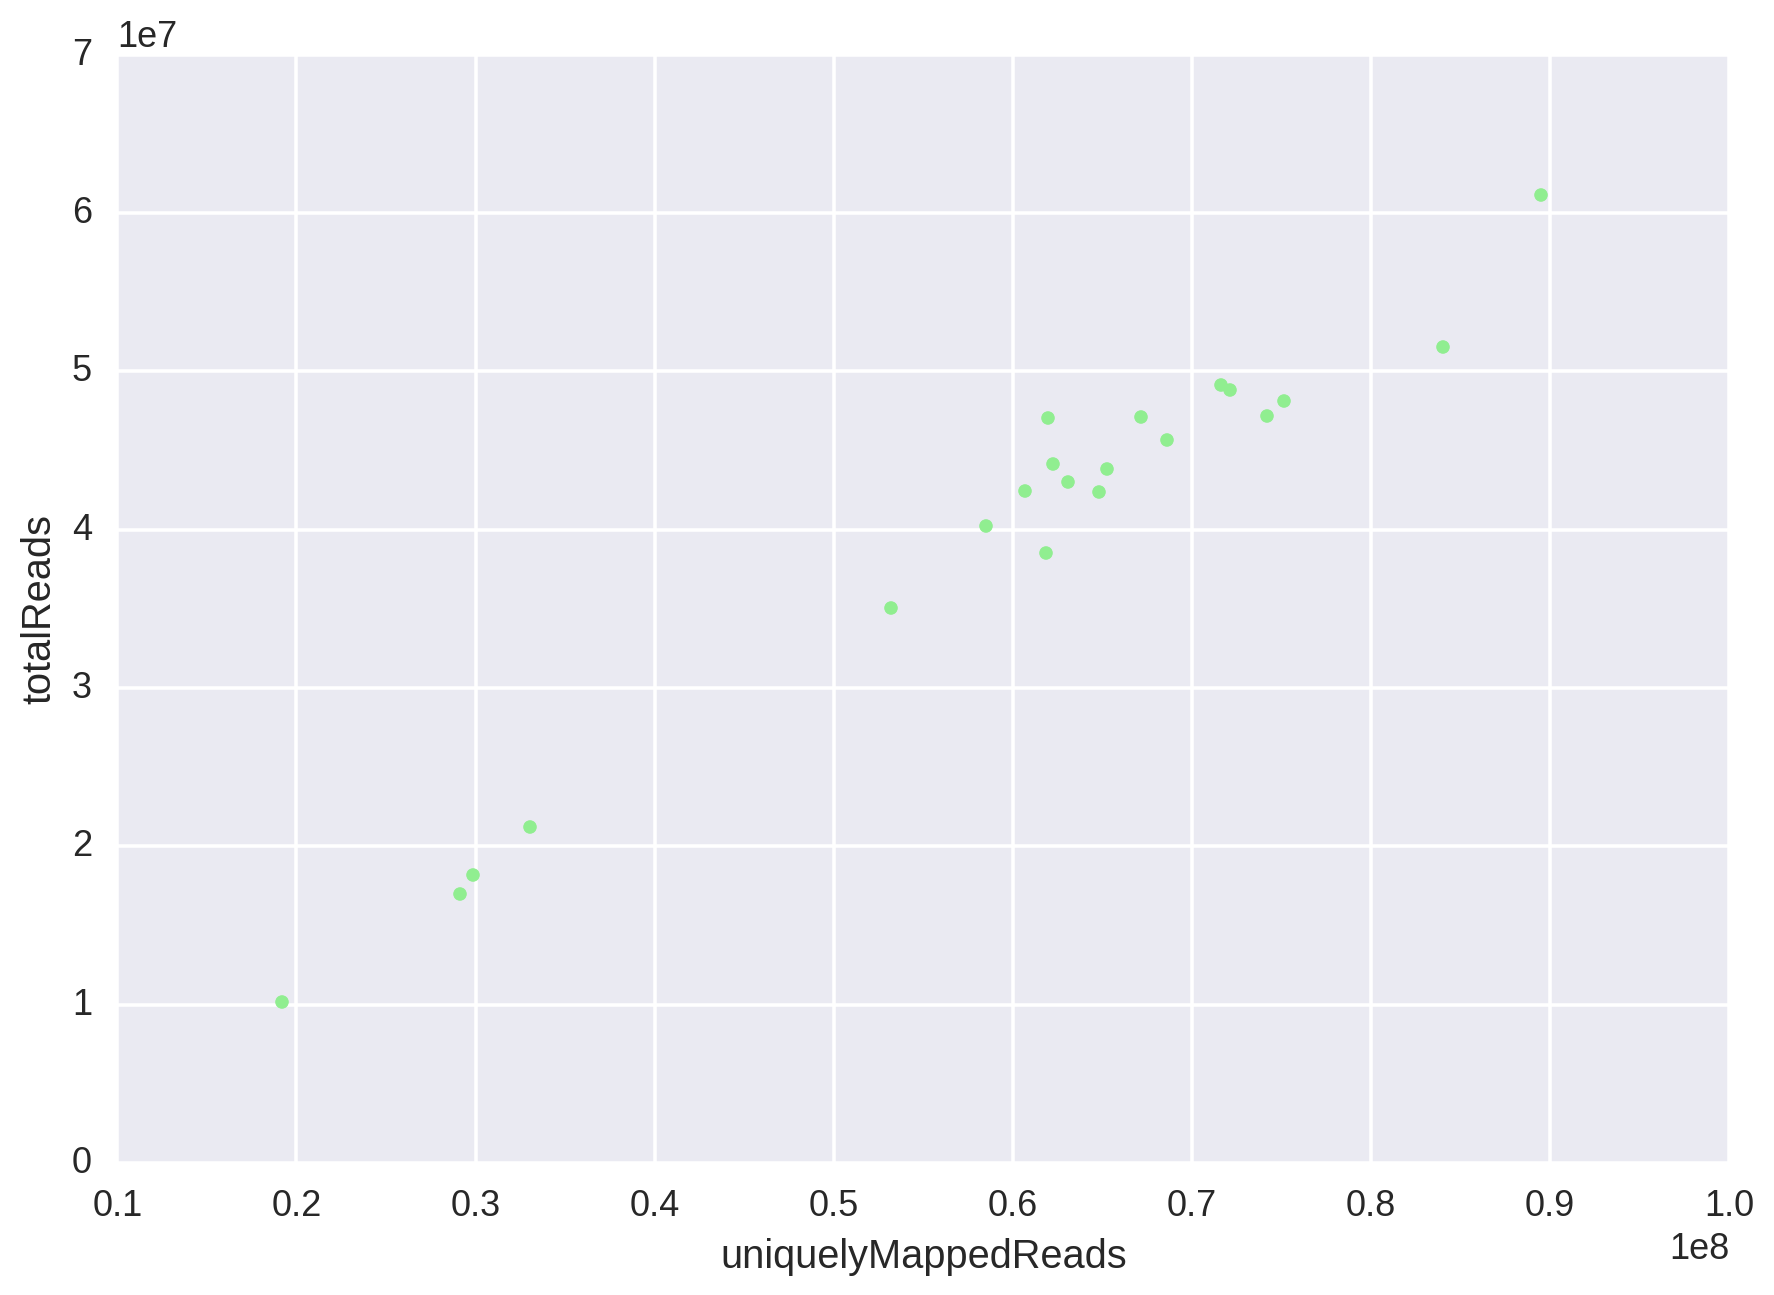

In [5]:
sns.distplot(filtered_summary_frame['uniquelyMappedFraction'], bins=20, kde=False, color='lightgreen')
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(filtered_summary_frame['uniquelyMappedReads'], bins=20, kde=False, color='lightgreen')
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Total Reads')
plt.ylabel('Frequency')
plt.show()

plt.scatter(filtered_summary_frame['totalReads'], y=filtered_summary_frame['uniquelyMappedReads'], color='lightgreen')
plt.ylabel('totalReads')
plt.xlabel('uniquelyMappedReads')
plt.show()






## Calculate Tag Counts and RPKM

In [216]:
# %%capture
filteredTagDirectories = ' '.join([tagDirectory +x for x in filtered_summary_frame['originalName']])
!analyzeRepeats.pl rna hg38 -count exons -condenseGenes -rpkm -d $filteredTagDirectories >/home/jenhan/analysis/pd_analysis/rpkm.tsv
!analyzeRepeats.pl rna hg38 -count exons -condenseGenes -noadj -d $filteredTagDirectories >/home/jenhan/analysis/pd_analysis/raw.tsv
!analyzeRepeats.pl rna hg38 -count exons -condenseGenes -d $filteredTagDirectories >/home/jenhan/analysis/pd_analysis/normed.tsv

!echo "analyzeRepeats.pl rna hg38 -count exons -condenseGenes -rpkm -d $filteredTagDirectories >/home/jenhan/analysis/pd_analysis/rpkm.tsv"
!echo "analyzeRepeats.pl rna hg38 -count exons -condenseGenes -noadj -d $filteredTagDirectories >/home/jenhan/analysis/pd_analysis/raw.tsv &"
!echo "analyzeRepeats.pl rna hg38 -count exons -condenseGenes -d $filteredTagDirectories >/home/jenhan/analysis/pd_analysis/normed.tsv &"

analyzeRepeats.pl rna hg38 -count exons -condenseGenes -rpkm -d /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-49_JS_14-02-26 /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-22_JS_13-05-15 /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-27_JS_13-05-15 /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-34_JS_14-02-26 /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-17_JS_13-05-15 /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-48_JS_14-02-26 /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-20_JS_13-05-15 /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-26_JS_13-05-15 /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-30_JS_14-02-26 /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_PD-13_JS_13-05-15 /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_PD-10_JS_13-05-15 /home/jenhan/analysis/

In [480]:
# read in RPKM values
rpkm_frame = pd.read_csv("rpkm.tsv",sep="\t")
columns = rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
rpkm_frame.columns = columns    
rpkm_frame['gene'] = [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]
columns = list(rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_frame = rpkm_frame[columns]

# read in tag counts
reads_frame = pd.read_csv("normed.tsv",sep="\t")
columns = reads_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "reads" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
reads_frame.columns = columns  
reads_frame['gene'] = [x.split("|")[0] for x in reads_frame['Annotation/Divergence']]
columns = list(reads_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
reads_frame = reads_frame[columns]

raw_frame = pd.read_csv("raw.tsv",sep="\t")
columns = raw_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "reads" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
raw_frame.columns = columns  
raw_frame['gene'] = [x.split("|")[0] for x in raw_frame['Annotation/Divergence']]
columns = list(raw_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
raw_frame = raw_frame[columns]

refseq_gene_mapping = dict(zip(rpkm_frame['refseq'].values, [x.split("|")[0].upper() for x in rpkm_frame['Annotation/Divergence']]))
gene_refseq_mapping = dict(zip([x.split("|")[0].upper() for x in rpkm_frame['Annotation/Divergence']], rpkm_frame['refseq'].values))


# get filtered rpkm values
filtered_rpkm_frame =  rpkm_frame[[x for x in rpkm_frame.columns if x in filtered_summary_frame['originalName'].values]]
# columns = [originalName_simpleName_dict[x] for x in filtered_rpkm_frame.columns.values]
columns = [x.split('_')[2] for x in filtered_rpkm_frame.columns.values]
filtered_rpkm_frame.columns = columns
filtered_rpkm_frame.index = rpkm_frame.refseq.values
# get rid of genes that aren't expressed at all
# filtered_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.sum(axis=1) > 10.0]
to_write_frame = filtered_rpkm_frame.copy()
to_write_frame = to_write_frame[to_write_frame.max(axis=1) > 1.0]
to_write_frame.index = [refseq_gene_mapping[x] for x in to_write_frame.index.values]
to_write_frame.to_csv('filtered_rpkm.tsv', sep='\t')
# create frame that's easier to use with factor plots
pivoting_frame = filtered_rpkm_frame.transpose()
_refseq = []
_gene = []
_rpkm = []
_simplifiedName = list(pivoting_frame.index.values) * pivoting_frame.shape[1]
_treatment = list(filtered_summary_frame['simpleTreatment'].values) * pivoting_frame.shape[1]
for refseq in pivoting_frame.columns:
    gene = refseq_gene_mapping[refseq].upper()
    for rpkm in pivoting_frame[refseq].values:
        _rpkm.append(rpkm)
        _refseq.append(refseq)
        _gene.append(gene)
filtered_rpkm_plottingFrame = pd.DataFrame({
'refseq': _refseq,
'gene': _gene, 
'rpkm': _rpkm,
'simplifiedName': _simplifiedName,
'treatment': _treatment
})
del pivoting_frame
        
filtered_rpkm_plottingFrame_log = filtered_rpkm_plottingFrame.copy()
filtered_rpkm_plottingFrame_log['rpkm'] = np.log2(filtered_rpkm_plottingFrame.rpkm)



## Run IDR

In [229]:
# %%capture
sampleColumns = rpkm_frame.columns.values[9:]
originalName_simpleTreatment_dict = dict(zip(filtered_summary_frame['originalName'], filtered_summary_frame['simpleTreatment']))
conditions = " ".join([originalName_simpleTreatment_dict[x] for x in sampleColumns])
!echo python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions
!python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions

python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv /home/jenhan/analysis/pd_analysis//idr/ Control Control Control Control Control Control Control Control Control PD PD PD PD PD PD PD PD PD PD PD PD
/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Output files will be written to: /home/jenhan/analysis/pd_analysis//idr/
Using the following IDR threshold: 0.05
Performing IDR analysis using the following columns and conditions:
/home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-49_JS_14-02-26 reads FPKM 	 Control
/home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-22_JS_13-05-15 reads FPKM 	 Control
/home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-27_JS_13-05-15 reads FPKM 	 Control
/home/jenhan/analysis/pd_analysis//tag_directo

## Calcuate Differential Expression with EdgeR

In [250]:
# %%capture
# use Homer to call differentially expressed genes with replicates
sample_condition_dict = dict(zip(filtered_summary_frame['originalName'], filtered_summary_frame['simpleTreatment']))
samples = raw_frame.columns[9:].values

conditions = " ".join([sample_condition_dict[x] for x in samples])
! getDiffExpression.pl raw.tsv $conditions > homer_diffExpresion.tsv


	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
Loading required package: limma


In [253]:
diffExpression_frame = pd.read_csv('homer_diffExpresion.tsv', sep='\t')
columns = diffExpression_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_frame.columns=columns
diffExpression_frame.index = diffExpression_frame.refseq.values
diffExpression_frame['gene'] = [x.split('|')[0].upper() for x in diffExpression_frame['Divergence']]
columns = ['refseq', 'gene'] + [x for x in diffExpression_frame.columns if 'vs.' in x]
diffExpression_frame = diffExpression_frame[columns]

In [254]:
np.sum(diffExpression_frame['Control vs. PD PValue'] < 0.05)


1350

## Tag Scatter Plots

In [11]:
idr_rpkm_frame = pd.read_csv('idr/idr_intersection_rpkm.tsv', sep='\t')

columns = idr_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
#         columns[i] = originalName_simpleName_dict[columns[i].split("/")[-1].split()[0]]
        columns[i] =columns[i].split("/")[-1].split()[0].split('_')[2]
idr_rpkm_frame.columns = columns    
idr_rpkm_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_frame['Annotation/Divergence']]
columns = list(idr_rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
idr_rpkm_frame = idr_rpkm_frame[columns]
idr_rpkm_frame.index = [x.upper() for x in idr_rpkm_frame['gene'].values]
idr_rpkm_frame = idr_rpkm_frame.ix[:,9:]

Control PD


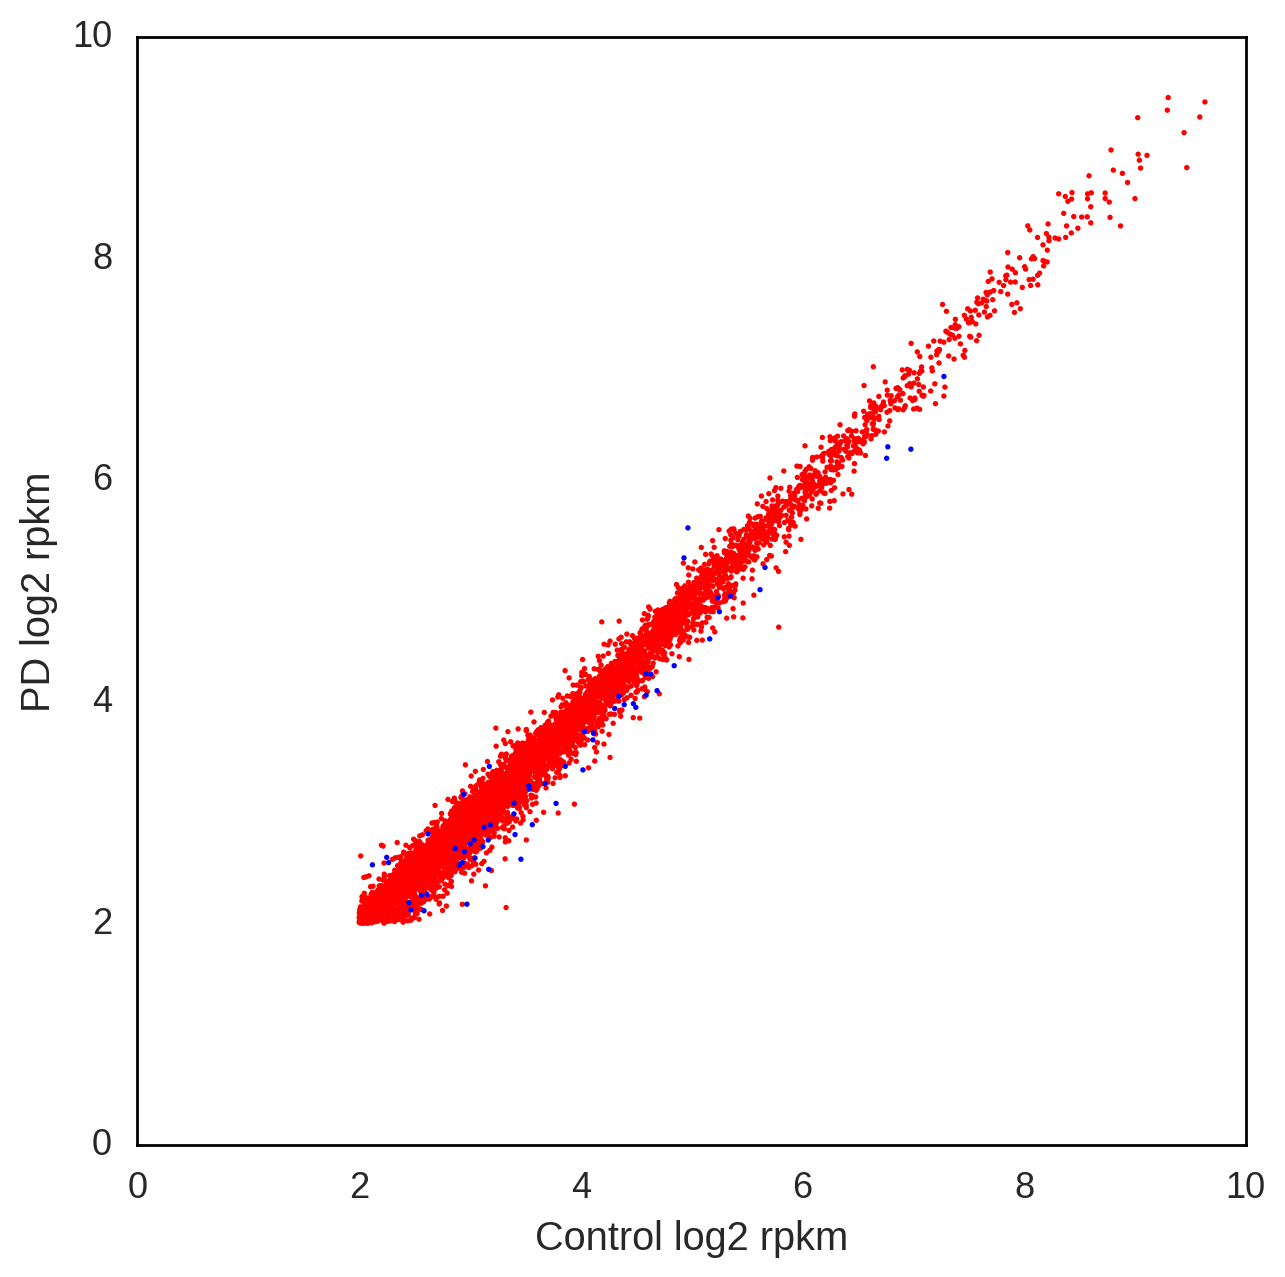

In [576]:
sns.set_style("whitegrid",{'axes.grid': False,
                          'axes.edgecolor': 'black'})

! rm -rf ./scatter_plots/*


if not os.path.isdir('./scatter_plots'):
    os.mkdir('./scatter_plots/')
treatment_up_dict = {}
treatment_down_dict = {}
   
fdr_threshold = 0.05
fold_threshold = 1.5
rpkm_cutoff = 4.0

classes = [str(fold_threshold) +' fold', 'FDR <0.05']
class_colours = ['grey','blue']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))


    
fdrColumns = [x for x in diffExpression_frame.columns if 'FDR' in x]


for c in fdrColumns:
        tokens = c.split()
        treatment1 = tokens[0]
        treatment2 = tokens[2]
        print(treatment1, treatment2)

        if True:
            
            fc_column = c.replace('FDR', 'logFC')

            diff_genes = diffExpression_frame[diffExpression_frame[c] < fdr_threshold]['gene'].values

            columns1 = filtered_summary_frame[filtered_summary_frame['simpleTreatment'] == treatment1]['simplifiedName']
            columns2 = filtered_summary_frame[filtered_summary_frame['simpleTreatment'] == treatment2]['simplifiedName']

            reads1 = idr_rpkm_frame.loc[:,columns1].mean(axis=1)
            reads2 = idr_rpkm_frame.loc[:,columns2].mean(axis=1)

            all_genes = idr_rpkm_frame.index.values
            read_tuple_list = tuple(zip(all_genes, reads1, reads2))
            filtered_read_tuple_list = [x for x in read_tuple_list if x[1] >= rpkm_cutoff and x[2]>= rpkm_cutoff ]
            
            filtered_genes = [x[0] for x in filtered_read_tuple_list]
            reads1 = np.array([x[1] for x in filtered_read_tuple_list])
            reads2 = np.array([x[2] for x in filtered_read_tuple_list])
            
            fold_genes = []
            for i in range(len(filtered_genes)): 
                fold = (reads1[i]+0.01)/(reads2[i]+0.01)
                if fold >=fold_threshold or fold <=1/fold_threshold:
                    fold_genes.append(filtered_genes[i])
            
#             colors = ['blue' if x in diff_genes and x in fold_genes else 'grey' if x in fold_genes else 'lightgrey' for x in idr_rpkm_frame.index.values]
            colors = ['blue' if x in cv_genes else 'red' for x in filtered_genes]
#             colors = ['blue' if x in fold_genes else 'red' for x in filtered_genes]


            # log values
            reads1 = np.log2(reads1 + 0.0000001)
            reads2 = np.log2(reads2 + 0.0000001)

            # ensure diff diff expressed genes are on top
            val_tuples = tuple(zip(reads1,reads2,colors))
            sorted_tuples = sorted(val_tuples,key=lambda x: x[2], reverse=True)
            reads1 = [x[0] for x in sorted_tuples] 
            reads2 = [x[1] for x in sorted_tuples]
            colors = [x[2] for x in sorted_tuples]
            plt.scatter(reads1, reads2, edgecolors='none', c=colors, marker = '.', s=15)
            # fix aspect ratio
            ax = plt.gca()
            ax.set_xlim((0,10))
            ax.set_ylim((0,10))
            x0,x1 = ax.get_xlim()
            y0,y1 = ax.get_ylim()
            ax.set_aspect(abs(x1-x0)/abs(y1-y0))        
            plt.xlabel(treatment1 + ' log2 rpkm')
            plt.ylabel(treatment2 + ' log2 rpkm')
#             plt.legend(recs,classes,loc=4)
            plt.savefig('./scatter_plots/'+ treatment1 + '_' + treatment2 + '_logRPKM_scatter_idr.pdf')
            plt.show()
            
        

Control PD


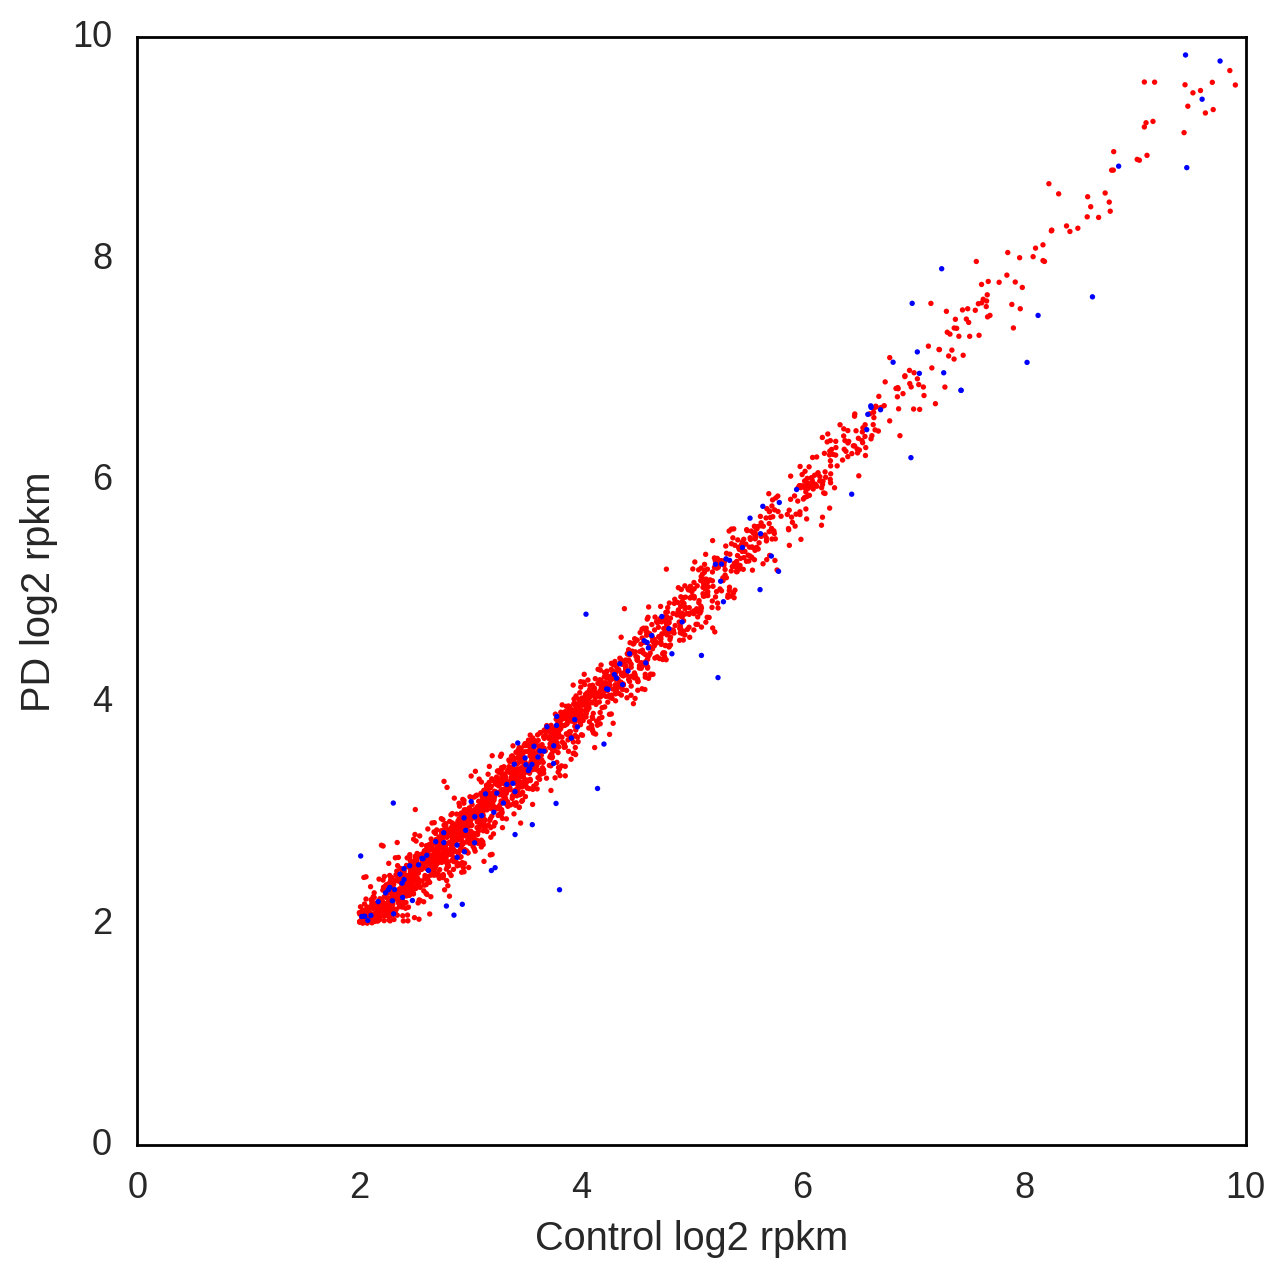

In [105]:
sns.set_style("whitegrid",{'axes.grid': False,
                          'axes.edgecolor': 'black'})

! rm -rf ./scatter_plots/*


if not os.path.isdir('./scatter_plots'):
    os.mkdir('./scatter_plots/')
treatment_up_dict = {}
treatment_down_dict = {}
   
fdr_threshold = 0.05
fold_threshold = 1.5
rpkm_cutoff = 4.0

classes = [str(fold_threshold) +' fold', 'FDR <0.05']
class_colours = ['grey','blue']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))


    
fdrColumns = [x for x in diffExpression_frame.columns if 'PValue' in x]


for c in fdrColumns:
        tokens = c.split()
        treatment1 = tokens[0]
        treatment2 = tokens[2]
        print(treatment1, treatment2)

        if True:
            
            fc_column = c.replace('PValue', 'logFC')

            diff_genes = diffExpression_frame[diffExpression_frame[c] < fdr_threshold]['gene'].values

            columns1 = filtered_summary_frame[filtered_summary_frame['simpleTreatment'] == treatment1]['simplifiedName']
            columns2 = filtered_summary_frame[filtered_summary_frame['simpleTreatment'] == treatment2]['simplifiedName']

            reads1 = filtered_rpkm_frame.loc[:,columns1].mean(axis=1)
            reads2 = filtered_rpkm_frame.loc[:,columns2].mean(axis=1)

            all_genes = idr_rpkm_frame.index.values
            read_tuple_list = tuple(zip(all_genes, reads1, reads2))
            filtered_read_tuple_list = [x for x in read_tuple_list if x[1] >= rpkm_cutoff and x[2]>= rpkm_cutoff ]
            
            filtered_genes = [x[0] for x in filtered_read_tuple_list]
            reads1 = np.array([x[1] for x in filtered_read_tuple_list])
            reads2 = np.array([x[2] for x in filtered_read_tuple_list])
            
            fold_genes = []
            for i in range(len(filtered_genes)): 
                fold = (reads1[i]+0.01)/(reads2[i]+0.01)
                if fold >=fold_threshold or fold <=1/fold_threshold:
                    fold_genes.append(filtered_genes[i])
            
#             colors = ['blue' if x in diff_genes and x in fold_genes else 'grey' if x in fold_genes else 'lightgrey' for x in idr_rpkm_frame.index.values]
            colors = ['blue' if x in diff_genes or x in fold_genes else 'red' for x in filtered_genes]
#             colors = ['blue' if x in fold_genes else 'red' for x in filtered_genes]


            # log values
            reads1 = np.log2(reads1 + 0.0000001)
            reads2 = np.log2(reads2 + 0.0000001)

            # ensure diff diff expressed genes are on top
            val_tuples = tuple(zip(reads1,reads2,colors))
            sorted_tuples = sorted(val_tuples,key=lambda x: x[2], reverse=True)
            reads1 = [x[0] for x in sorted_tuples] 
            reads2 = [x[1] for x in sorted_tuples]
            colors = [x[2] for x in sorted_tuples]
            plt.scatter(reads1, reads2, edgecolors='none', c=colors, marker = '.', s=15)
            # fix aspect ratio
            ax = plt.gca()
            ax.set_xlim((0,10))
            ax.set_ylim((0,10))
            x0,x1 = ax.get_xlim()
            y0,y1 = ax.get_ylim()
            ax.set_aspect(abs(x1-x0)/abs(y1-y0))        
            plt.xlabel(treatment1 + ' log2 rpkm')
            plt.ylabel(treatment2 + ' log2 rpkm')
#             plt.legend(recs,classes,loc=4)
            plt.savefig('./scatter_plots/'+ treatment1 + '_' + treatment2 + '_logRPKM_scatter_all.pdf')
            plt.show()
            
        

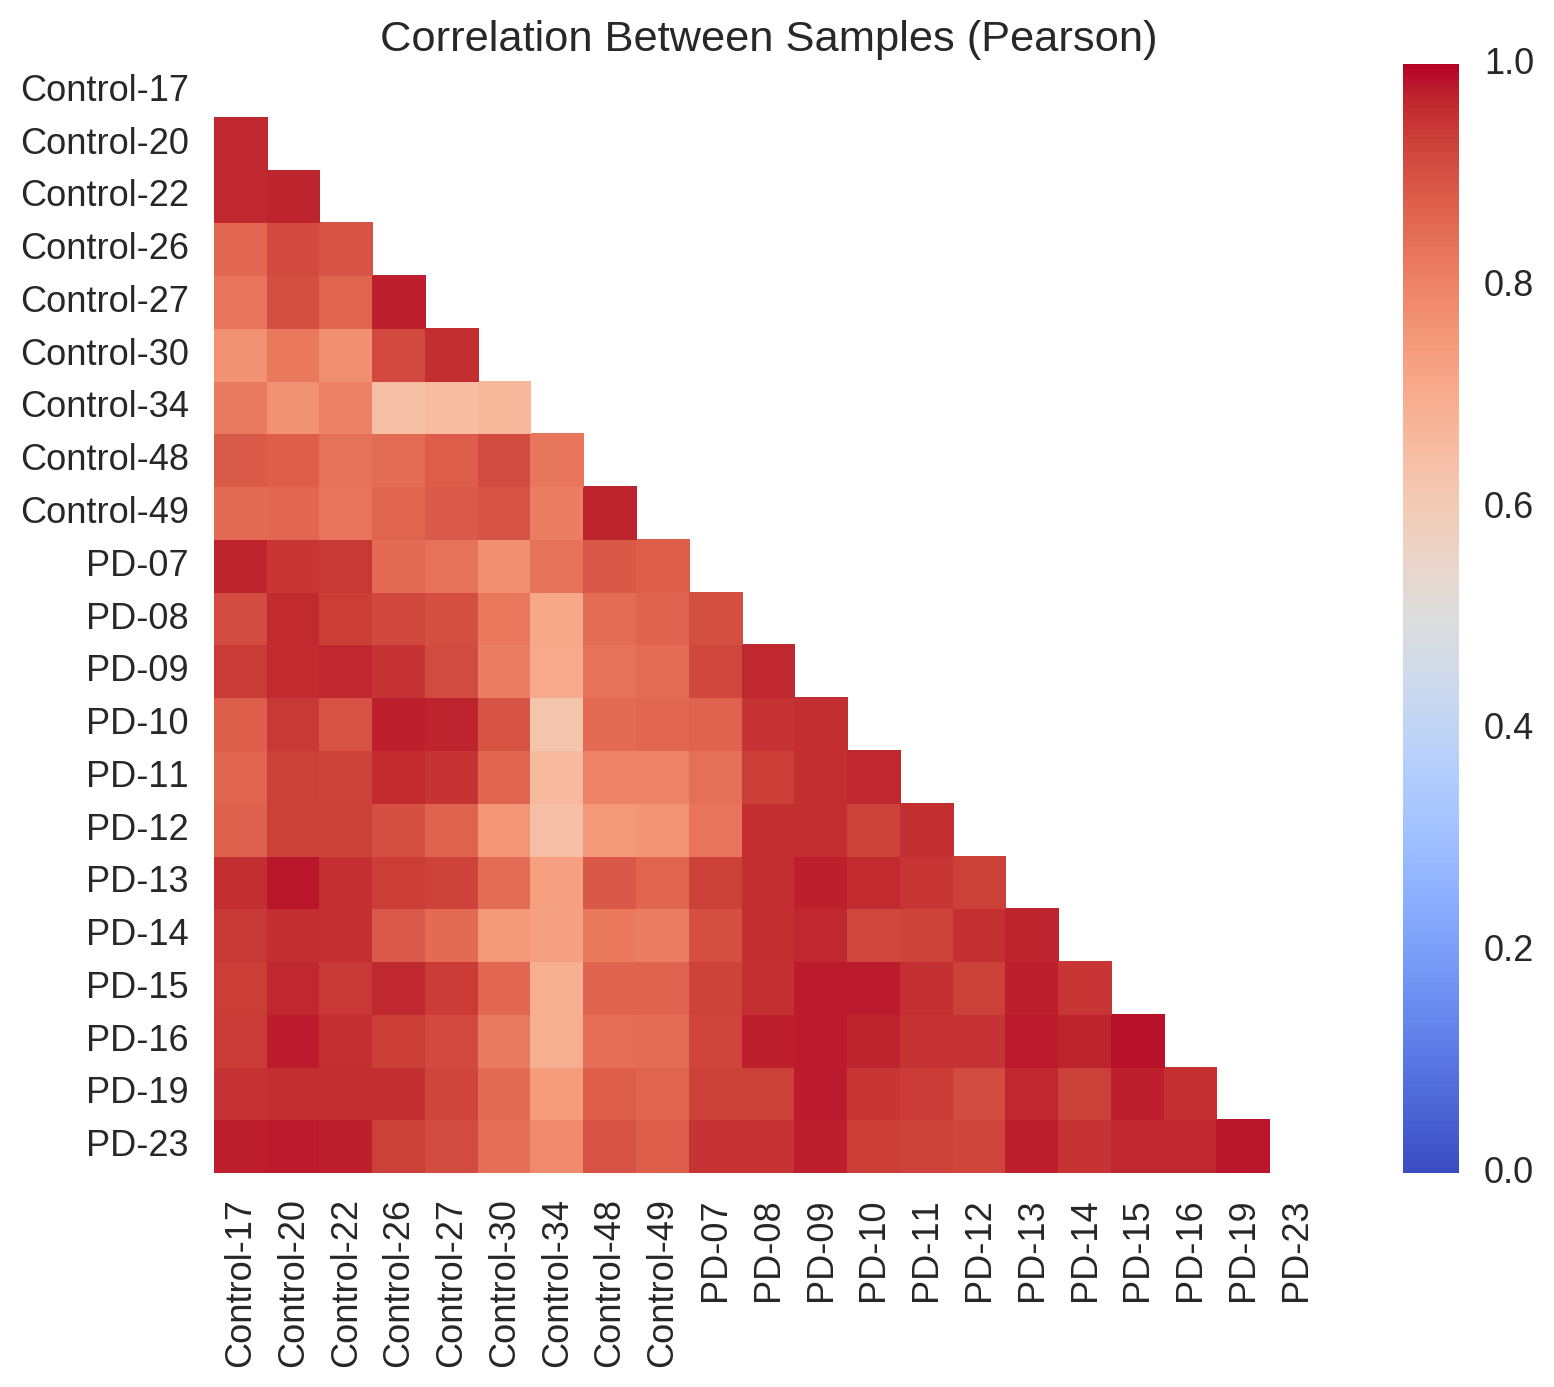

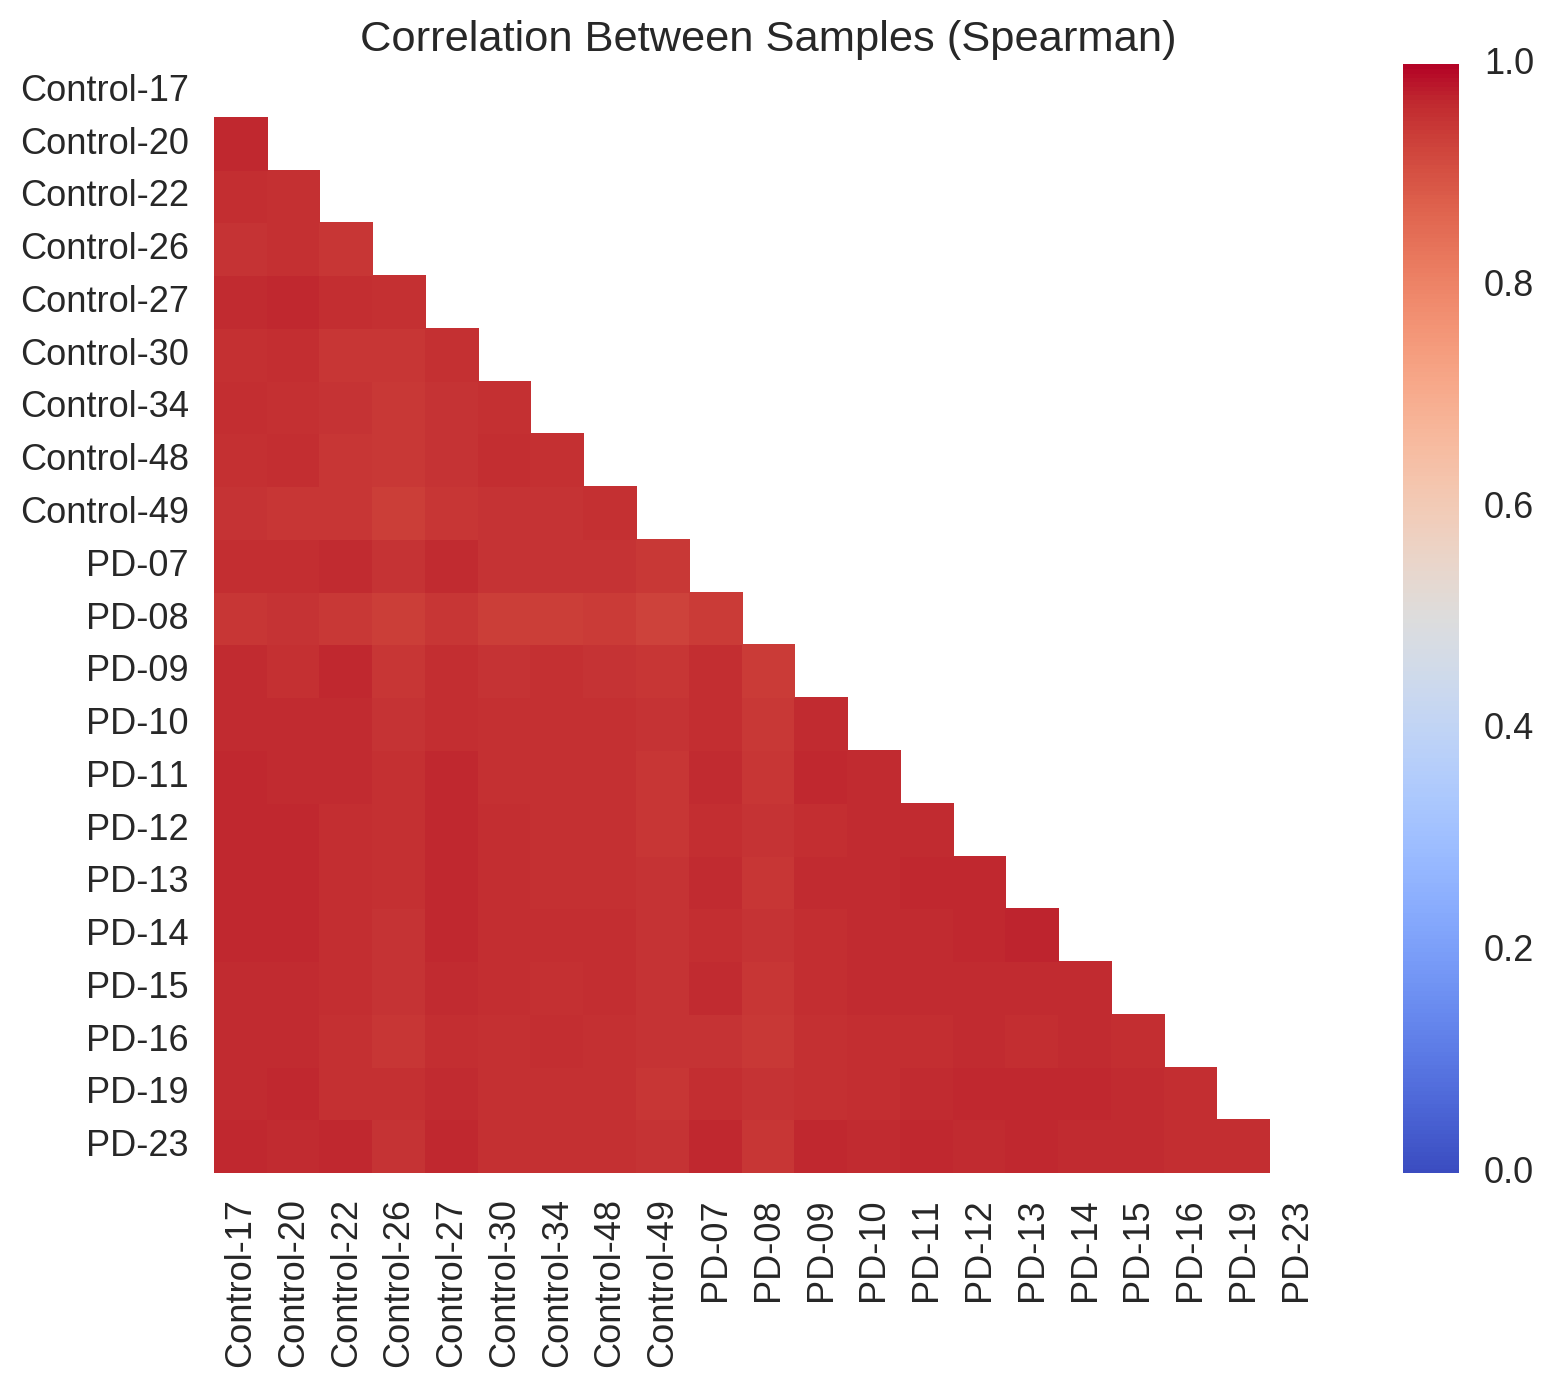

In [437]:
### cluster samples according to correlation
samples = sorted(filtered_rpkm_frame.columns.values)

labels = samples

spearman_matrix = np.zeros((len(samples), len(samples)))
pearson_matrix = np.zeros((len(samples), len(samples)))
# for i in range(len(samples)):
#     spearman_matrix[i][i]=1.0
#     pearson_matrix[i][i]=1.0

for i in range(len(samples) - 1):
    for j in range(i+1, len(samples)):
        values_1 = filtered_rpkm_frame[samples[i]].values
        values_2 = filtered_rpkm_frame[samples[j]].values
        pearson, pearson_pval = scipy.stats.pearsonr(values_1,values_2)
        spearman, spearman_pval = scipy.stats.spearmanr(values_1,values_2)
        pearson_matrix[i][j] = pearson
        pearson_matrix[j][i] = pearson
        
        spearman_matrix[i][j] = spearman
        spearman_matrix[j][i] = spearman
        
spearman_matrix = pd.DataFrame(spearman_matrix, columns=samples, index=samples)
pearson_matrix = pd.DataFrame(pearson_matrix, columns=samples, index=samples)


mask = np.zeros_like(spearman_matrix)
mask[np.triu_indices_from(mask)] = True


cg = sns.heatmap(pearson_matrix, mask = mask, cmap='coolwarm', square=True, vmax=1.0)
plt.title('Correlation Between Samples (Pearson)')
plt.savefig('pearson.pdf', bbox_inches='tight')
plt.show()

cg = sns.heatmap(spearman_matrix , mask = mask, cmap='coolwarm', square=True, vmax=1.0)
plt.title('Correlation Between Samples (Spearman)')
plt.savefig('spearman.pdf',bbox_inches='tight')
plt.show()



## Statistical Testing

In [12]:
from scipy import stats

In [534]:
refseqs = []
kw_pvals = []
kw_stats = []
ks_pvals = []
ks_stats = []
genes = []
up_down = []
fold= []
idr_genes = set(idr_rpkm_frame.index.values)
for refseq in set(filtered_rpkm_plottingFrame['refseq'].values):

    gene = refseq_gene_mapping[refseq]
    if gene in idr_genes:
        currentVals = filtered_rpkm_plottingFrame[filtered_rpkm_plottingFrame['refseq'] == refseq]
        
        control_vals = currentVals[currentVals['treatment'] == 'Control']['rpkm'].values
        pd_vals = currentVals[currentVals['treatment'] == 'PD']['rpkm'].values
        ks_stat, p_ks = stats.ks_2samp(control_vals, pd_vals)
        kw_stat, p_kw = stats.kruskal(control_vals, pd_vals)
        
        kw_pvals.append(p_kw)
        ks_pvals.append(p_ks)
        
        kw_stats.append(kw_stat)
        ks_stats.append(ks_stat)
        
        genes.append(gene)
        refseqs.append(refseq)
        
        mean_control = np.mean(control_vals)
        mean_pd = np.mean(pd_vals)
        if mean_control < mean_pd:
            up_down.append('up')
        else:
            up_down.append('down')
        fold.append(mean_pd/mean_control)
        
passed_idr = [True if x in idr_genes else False for x in genes]
gene_edgerp_dict = dict(zip(diffExpression_frame['gene'], diffExpression_frame['Control vs. PD PValue'].values))
edger_pvals = [gene_edgerp_dict[x] if x in gene_edgerp_dict else 1.0 for x in genes]
stat_frame = pd.DataFrame({'gene':genes,
                            'refseq':refseqs,
                            'KS pval':ks_pvals,
                            'KS stat':ks_stats,
                            'KW pval':kw_pvals,
                            'KW stat':kw_stats,
                            'passed IDR': passed_idr,
                            'EdgeR pval':edger_pvals,
                            'Up or Down':up_down,
                           'fold change':fold
                           }) 

## Cross Validation

In [282]:
from sklearn import cross_validation

In [287]:
filtered_rpkm_plottingFrame.head()

,gene,refseq,rpkm,simplifiedName,treatment
0,MIR3912,NR_037474,0,Control-49,Control
1,MIR3912,NR_037474,0,Control-22,Control
2,MIR3912,NR_037474,0,Control-27,Control
3,MIR3912,NR_037474,0,Control-34,Control
4,MIR3912,NR_037474,0,Control-17,Control


In [297]:
from collections import Counter

In [298]:
Counter(treatments)

Counter({'Control': 9, 'PD': 12})

In [322]:
idr_genes = set(idr_rpkm_frame.index.values)

samples = sorted(set(filtered_rpkm_plottingFrame['simplifiedName'].values))
treatments = [x.split('-')[0] for x in samples]
labels = treatments

refseqs = []
kw_pvals = []
kw_stats = []
genes = []
up_down = []
run = []

skf = cross_validation.StratifiedKFold(labels, 5, shuffle=True)
runNumber = 0
for test_indices, exclude_indices in skf:
    runNumber += 1
    print(runNumber)
    test_samples = [samples[i] for i in test_indices]
    excluded_samples = [samples[i] for i in exclude_indices]
    current_frame = filtered_rpkm_plottingFrame[filtered_rpkm_plottingFrame['simplifiedName'].isin(
        test_samples)]
    print("%s %s" % (test_indices, exclude_indices))
    print("%s %s" % (test_samples, excluded_samples))
    

    for refseq in set(current_frame['refseq'].values):
        gene = refseq_gene_mapping[refseq]
        if gene in idr_genes:
            run.append(runNumber)
            currentVals = current_frame[current_frame['refseq'] == refseq]

            control_vals = currentVals[currentVals['treatment'] == 'Control']['rpkm'].values
            pd_vals = currentVals[currentVals['treatment'] == 'PD']['rpkm'].values
            kw_stat, p_kw = stats.kruskal(control_vals, pd_vals)

            kw_pvals.append(p_kw)
            kw_stats.append(kw_stat)

            genes.append(gene)
            refseqs.append(refseq)

            if np.mean(control_vals) < np.mean(pd_vals):
                up_down.append('up')
            else:
                up_down.append('down')
        
passed_idr = [True if x in idr_genes else False for x in genes]
gene_edgerp_dict = dict(zip(diffExpression_frame['gene'], diffExpression_frame['Control vs. PD PValue'].values))
edger_pvals = [gene_edgerp_dict[x] if x in gene_edgerp_dict else 1.0 for x in genes]
cv_frame = pd.DataFrame({'gene':genes,
                            'refseq':refseqs,
                            'KW pval':kw_pvals,
                            'KW stat':kw_stats,
                            'passed IDR': passed_idr,
                            'EdgeR pval':edger_pvals,
                            'Up or Down':up_down,
                            'Run':run
                           }) 

1
[ 0  1  4  5  6  7  8  9 11 12 13 14 15 16 17 18] [ 2  3 10 19 20]
['Control-17', 'Control-20', 'Control-27', 'Control-30', 'Control-34', 'Control-48', 'Control-49', 'PD-07', 'PD-09', 'PD-10', 'PD-11', 'PD-12', 'PD-13', 'PD-14', 'PD-15', 'PD-16'] ['Control-22', 'Control-26', 'PD-08', 'PD-19', 'PD-23']
2
[ 0  1  2  3  4  5  6 10 11 12 13 14 16 17 19 20] [ 7  8  9 15 18]
['Control-17', 'Control-20', 'Control-22', 'Control-26', 'Control-27', 'Control-30', 'Control-34', 'PD-08', 'PD-09', 'PD-10', 'PD-11', 'PD-12', 'PD-14', 'PD-15', 'PD-19', 'PD-23'] ['Control-48', 'Control-49', 'PD-07', 'PD-13', 'PD-16']
3
[ 1  2  3  4  5  7  8  9 10 11 12 13 14 15 18 19 20] [ 0  6 16 17]
['Control-20', 'Control-22', 'Control-26', 'Control-27', 'Control-30', 'Control-48', 'Control-49', 'PD-07', 'PD-08', 'PD-09', 'PD-10', 'PD-11', 'PD-12', 'PD-13', 'PD-16', 'PD-19', 'PD-23'] ['Control-17', 'Control-34', 'PD-14', 'PD-15']
4
[ 0  2  3  4  6  7  8  9 10 12 13 15 16 17 18 19 20] [ 1  5 11 14]
['Control-17', '

In [ ]:
kw_genes = set(stat_frame[stat_frame['KW pval'] < p_threshold]['gene'].values)

for gene in kw_genes:
    sns.factorplot(data=cv_frame[cv_frame['gene']==gene],
                  y='KW pval',x='Run', kind='bar')
    plt.title(gene)
    plt.show()
    

In [334]:
p_threshold = 0.05
cv_genes = []

for gene in sorted(idr_rpkm_frame.index.values):
    pvals = cv_frame[cv_frame['gene'] == gene]['KW pval'].values
    max_pval = np.max(pvals)
    if max_pval < p_threshold:
        print(gene)
        cv_genes.append(gene)

ADD3-AS1
AHSA2
AMDHD2
ANKRD13D
APOA1BP
ASRGL1
ATG16L2
AXIN1
C18ORF8
CDK5RAP3
COMTD1
CTU2
CYB561
DCAF13
DGKQ
DTYMK
E2F2
ECHS1
EML2
ERMARD
FAM20C
FAM71E1
FANCA
FASTK
FCHSD2
FOXRED1
GADD45B
GNB1
GSDMD
HEXDC
HK3
HPS4
KIF13B
KIFC2
L3HYPDH
LAGE3
LIME1
LMBR1L
LOC285074
LOC728392
LPAR2
MAN2C1
MCM5
MIB2
MIIP
MIR181A1HG
MIR4680
MIR4785
MIR6821
MPPE1
MSL2
MSRB2
MTF1
NCOR1
NEURL4
NTMT1
NUDT22
OARD1
ORMDL3
PARP10
PLEKHO2
PRDX2
RAB11FIP4
RASSF1
RC3H1
RELL2
SEC31B
SERINC5
SHROOM1
SLC46A1
SMG5
SNORD1C
SNRNP70
SPATA5L1
SRSF5
ST3GAL5
TBRG4
TCIRG1
TMC8
TNFRSF14
TP53I13
TRIM41
TSFM
TSSC1
UHRF2
WDR13
WNK1
ZFP36L2
ZNF274


## Comparing EdgeR and Kruskal Wallis Test

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib_venn-0.9-py3.4.egg/matplotlib_venn/_venn3.py:422: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


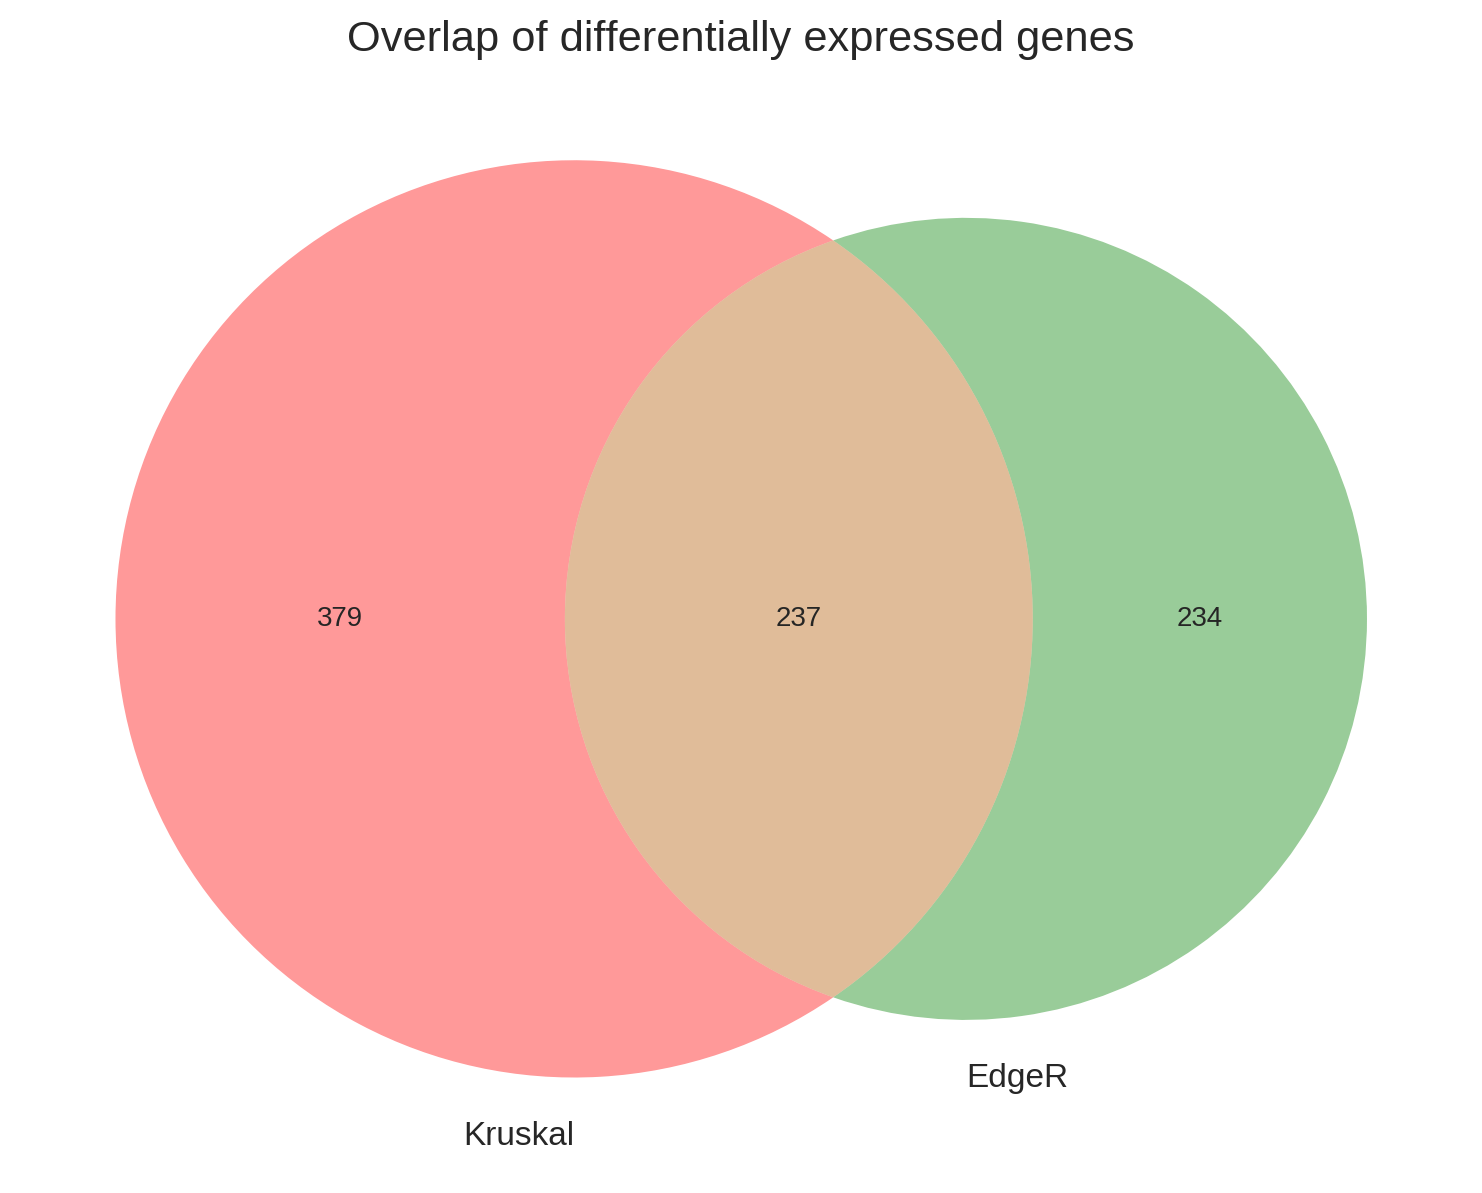

In [125]:
p_threshold = 0.05
kw_genes = set(stat_frame[stat_frame['KW pval'] < p_threshold]['gene'].values)
edger_genes = set(stat_frame[stat_frame['EdgeR pval'] < p_threshold]['gene'].values)
matplotlib_venn.venn2([kw_genes, edger_genes], set_labels = ['Kruskal', 'EdgeR'])
plt.title('Overlap of differentially expressed genes')

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib_venn-0.9-py3.4.egg/matplotlib_venn/_venn3.py:422: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


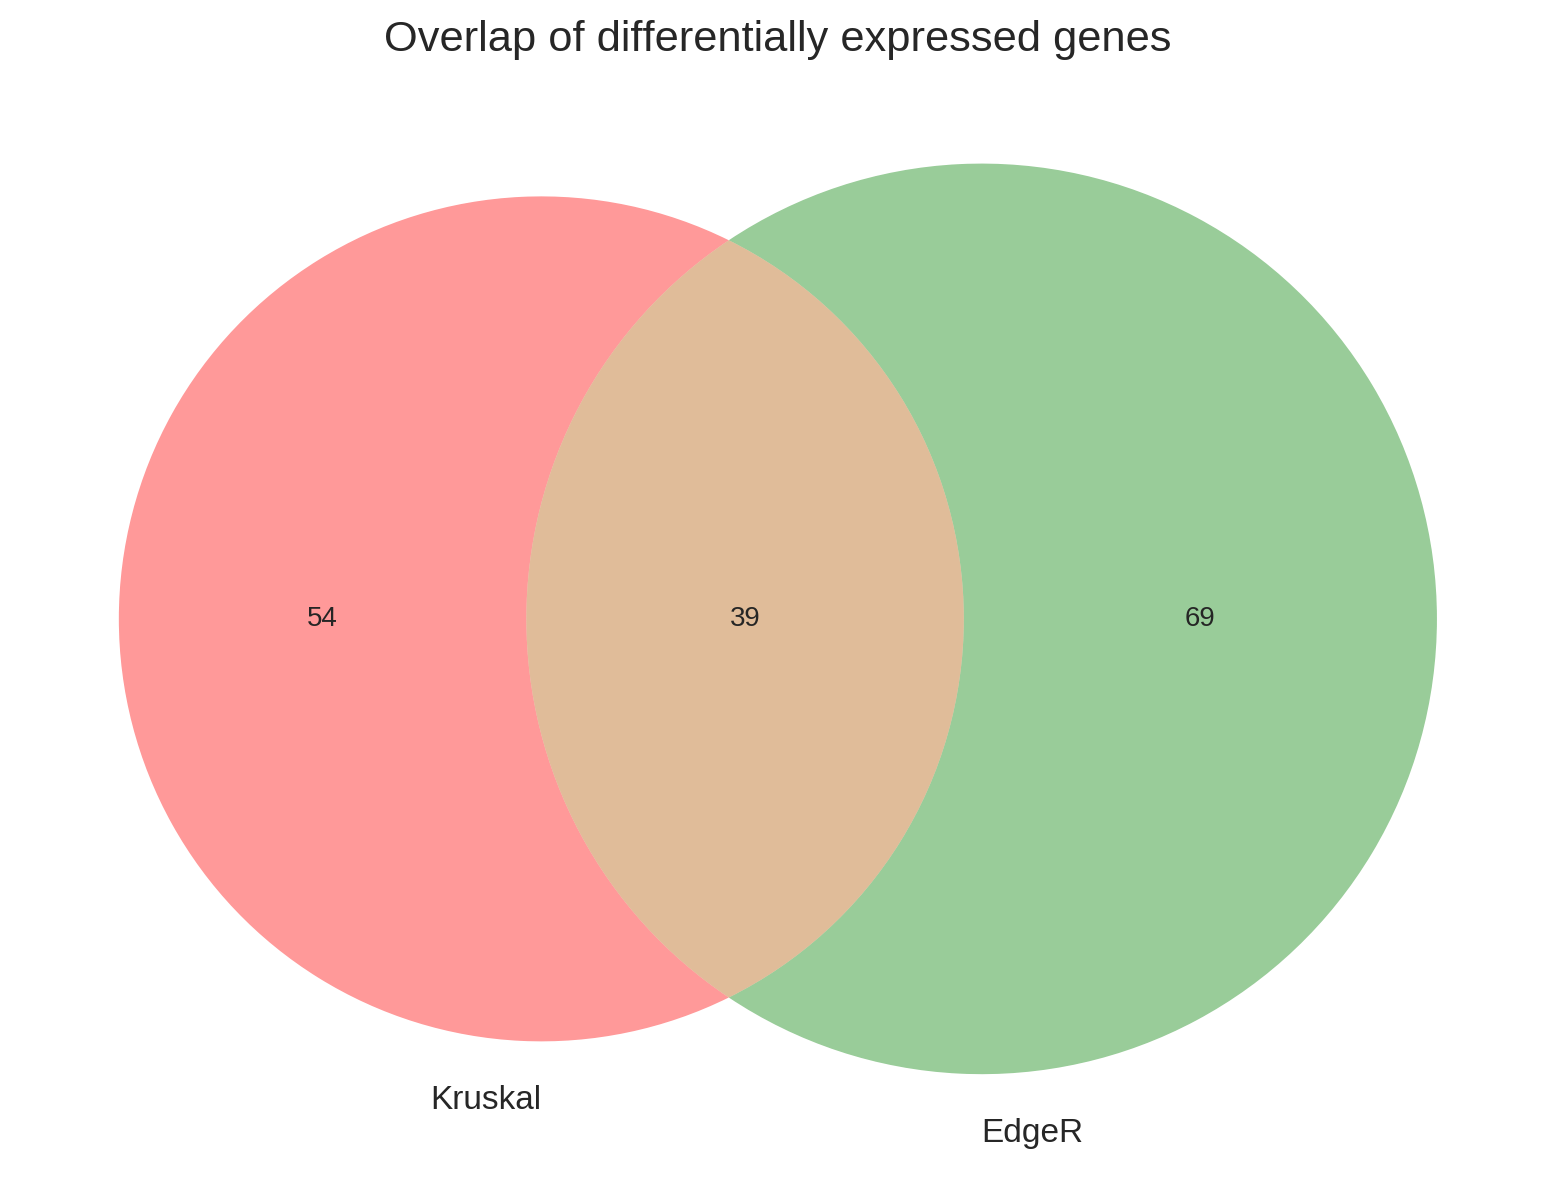

In [126]:
p_threshold = 0.01
kw_genes = set(stat_frame[stat_frame['KW pval'] < p_threshold]['gene'].values)
edger_genes = set(stat_frame[stat_frame['EdgeR pval'] < p_threshold]['gene'].values)
matplotlib_venn.venn2([kw_genes, edger_genes], set_labels = ['Kruskal', 'EdgeR'])
plt.title('Overlap of differentially expressed genes')

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib_venn-0.9-py3.4.egg/matplotlib_venn/_venn3.py:422: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


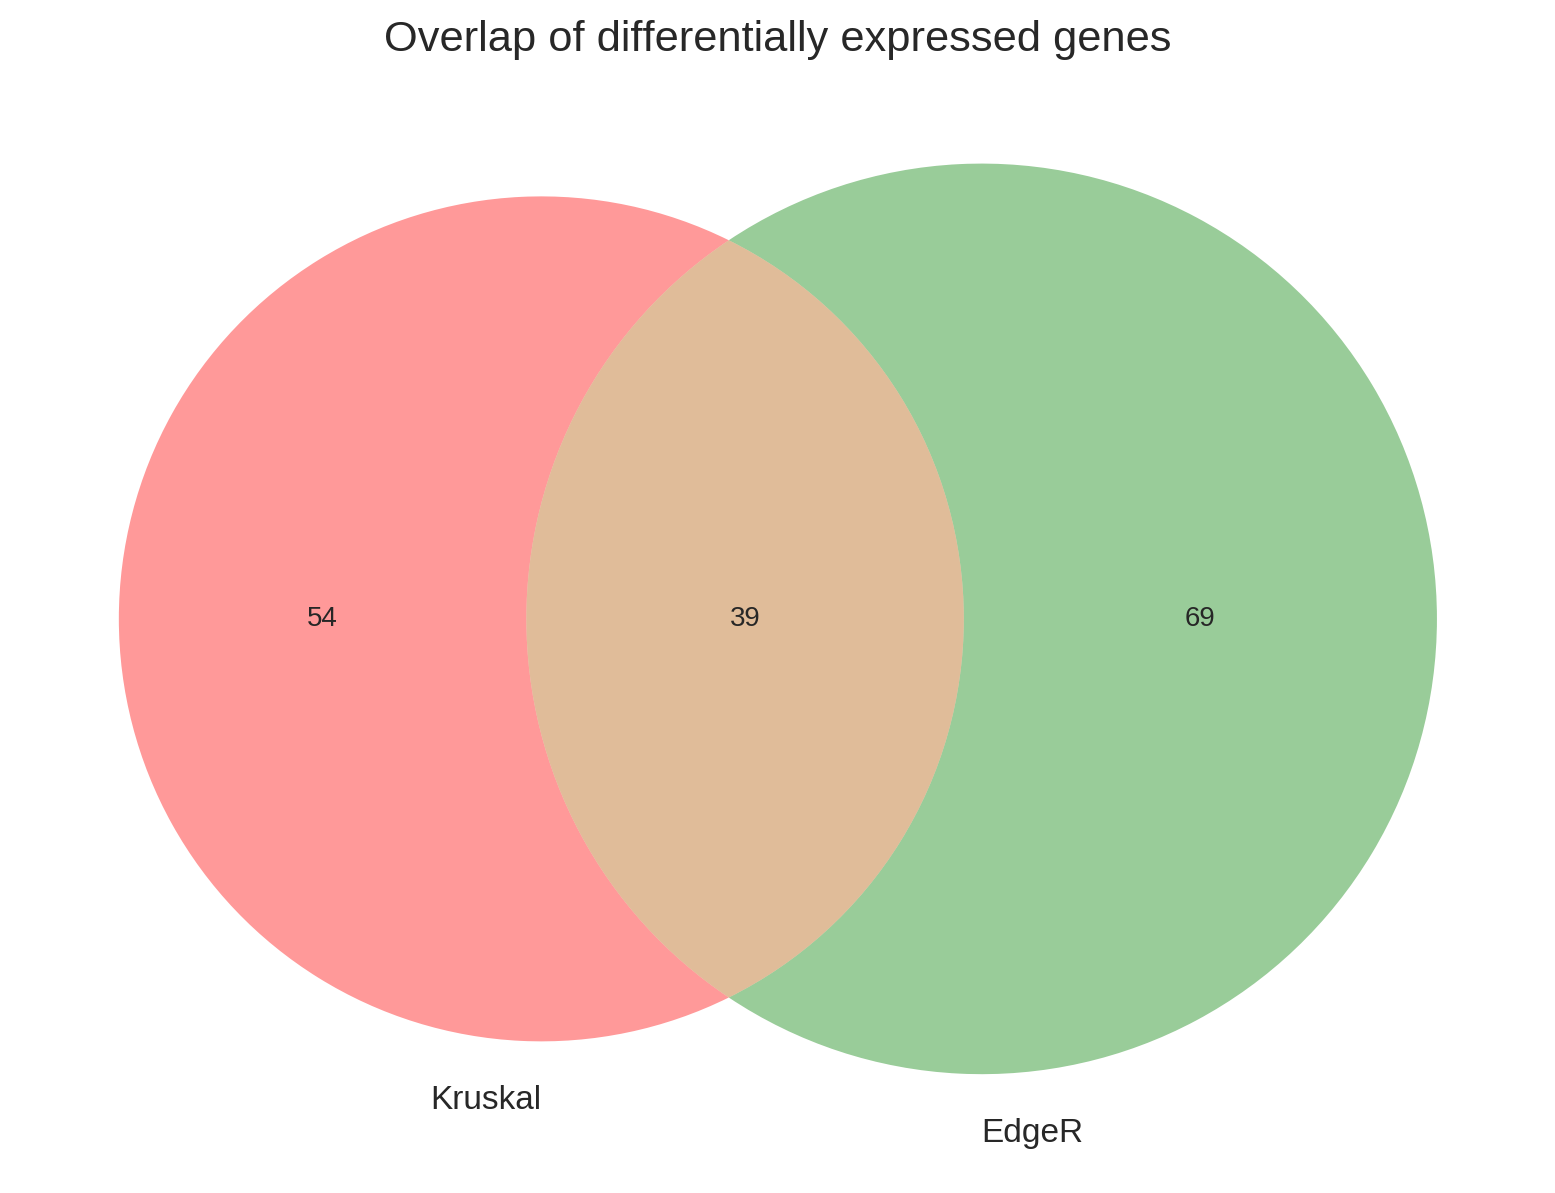

In [162]:
p_threshold = 0.01
kw_genes = stat_frame[stat_frame['KW pval'] < p_threshold]['gene'].values
edger_genes = stat_frame[stat_frame['EdgeR pval'] < p_threshold]['gene'].values

kw_genes = [x for x in kw_genes if x in idr_genes]

# edger_genes = [x for x in edger_genes if x in idr_genes]

kw_genes = set(kw_genes)
edger_genes = set(edger_genes)
matplotlib_venn.venn2([kw_genes, edger_genes], set_labels = ['Kruskal', 'EdgeR'])
plt.title('Overlap of differentially expressed genes')


/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib_venn-0.9-py3.4.egg/matplotlib_venn/_venn3.py:422: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


{'TTLL3'}

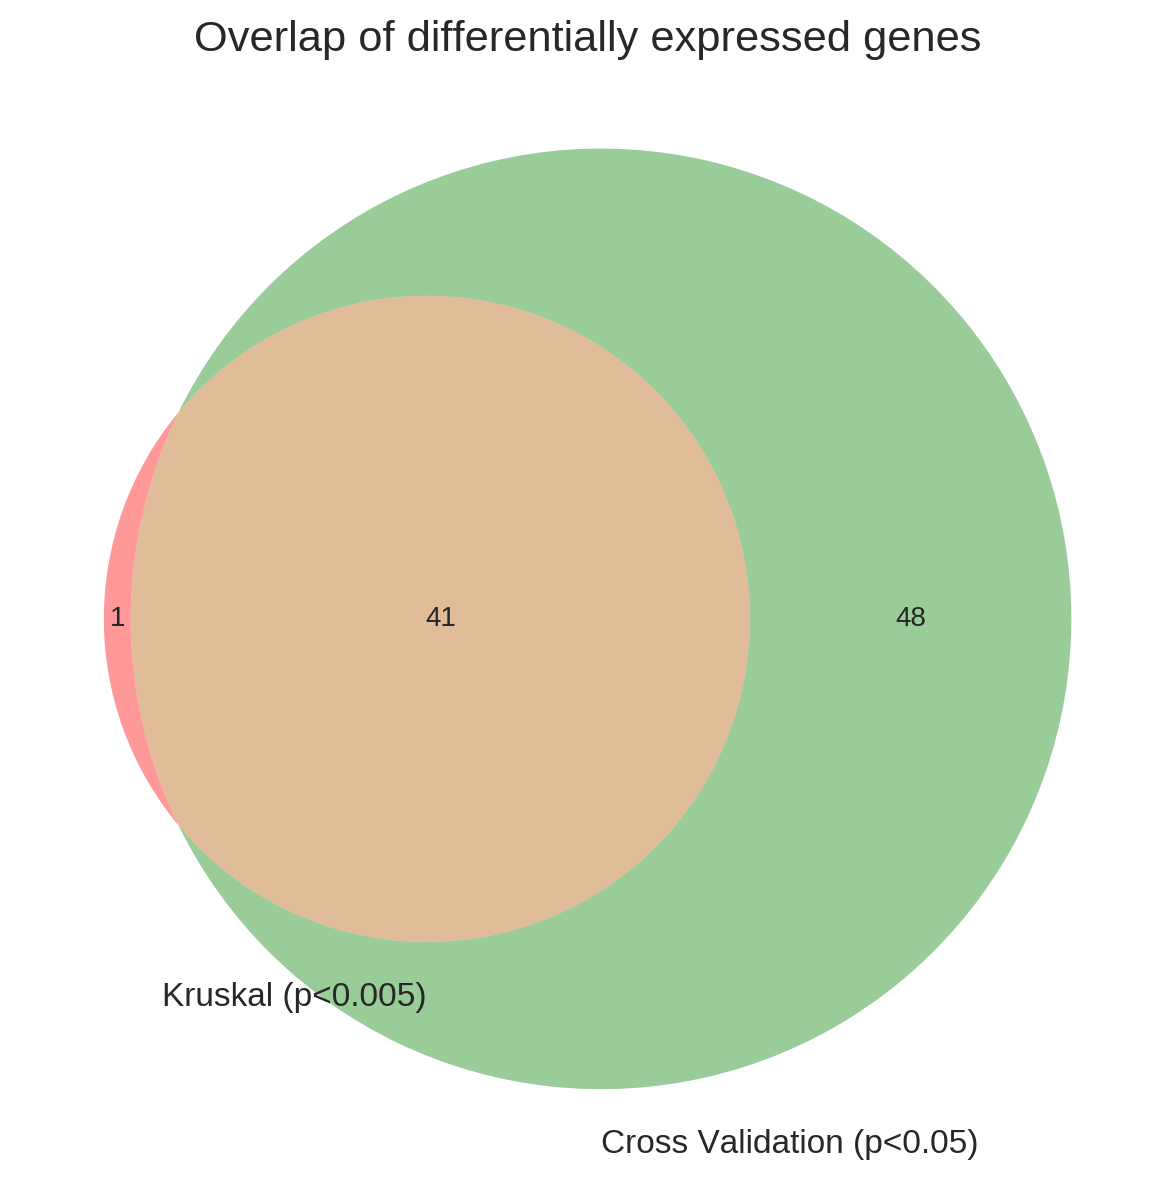

In [405]:
p_threshold = 0.005
kw_genes = stat_frame[stat_frame['KW pval'] < p_threshold]['gene'].values

# kw_genes = [x for x in kw_genes if x in idr_genes]

# edger_genes = [x for x in edger_genes if x in idr_genes]

kw_genes = set(kw_genes)
matplotlib_venn.venn2([kw_genes, set(cv_genes)], set_labels = ['Kruskal (p<'+str(p_threshold)+')', 'Cross Validation (p<0.05)'])
plt.title('Overlap of differentially expressed genes')

kw_genes-set(cv_genes)


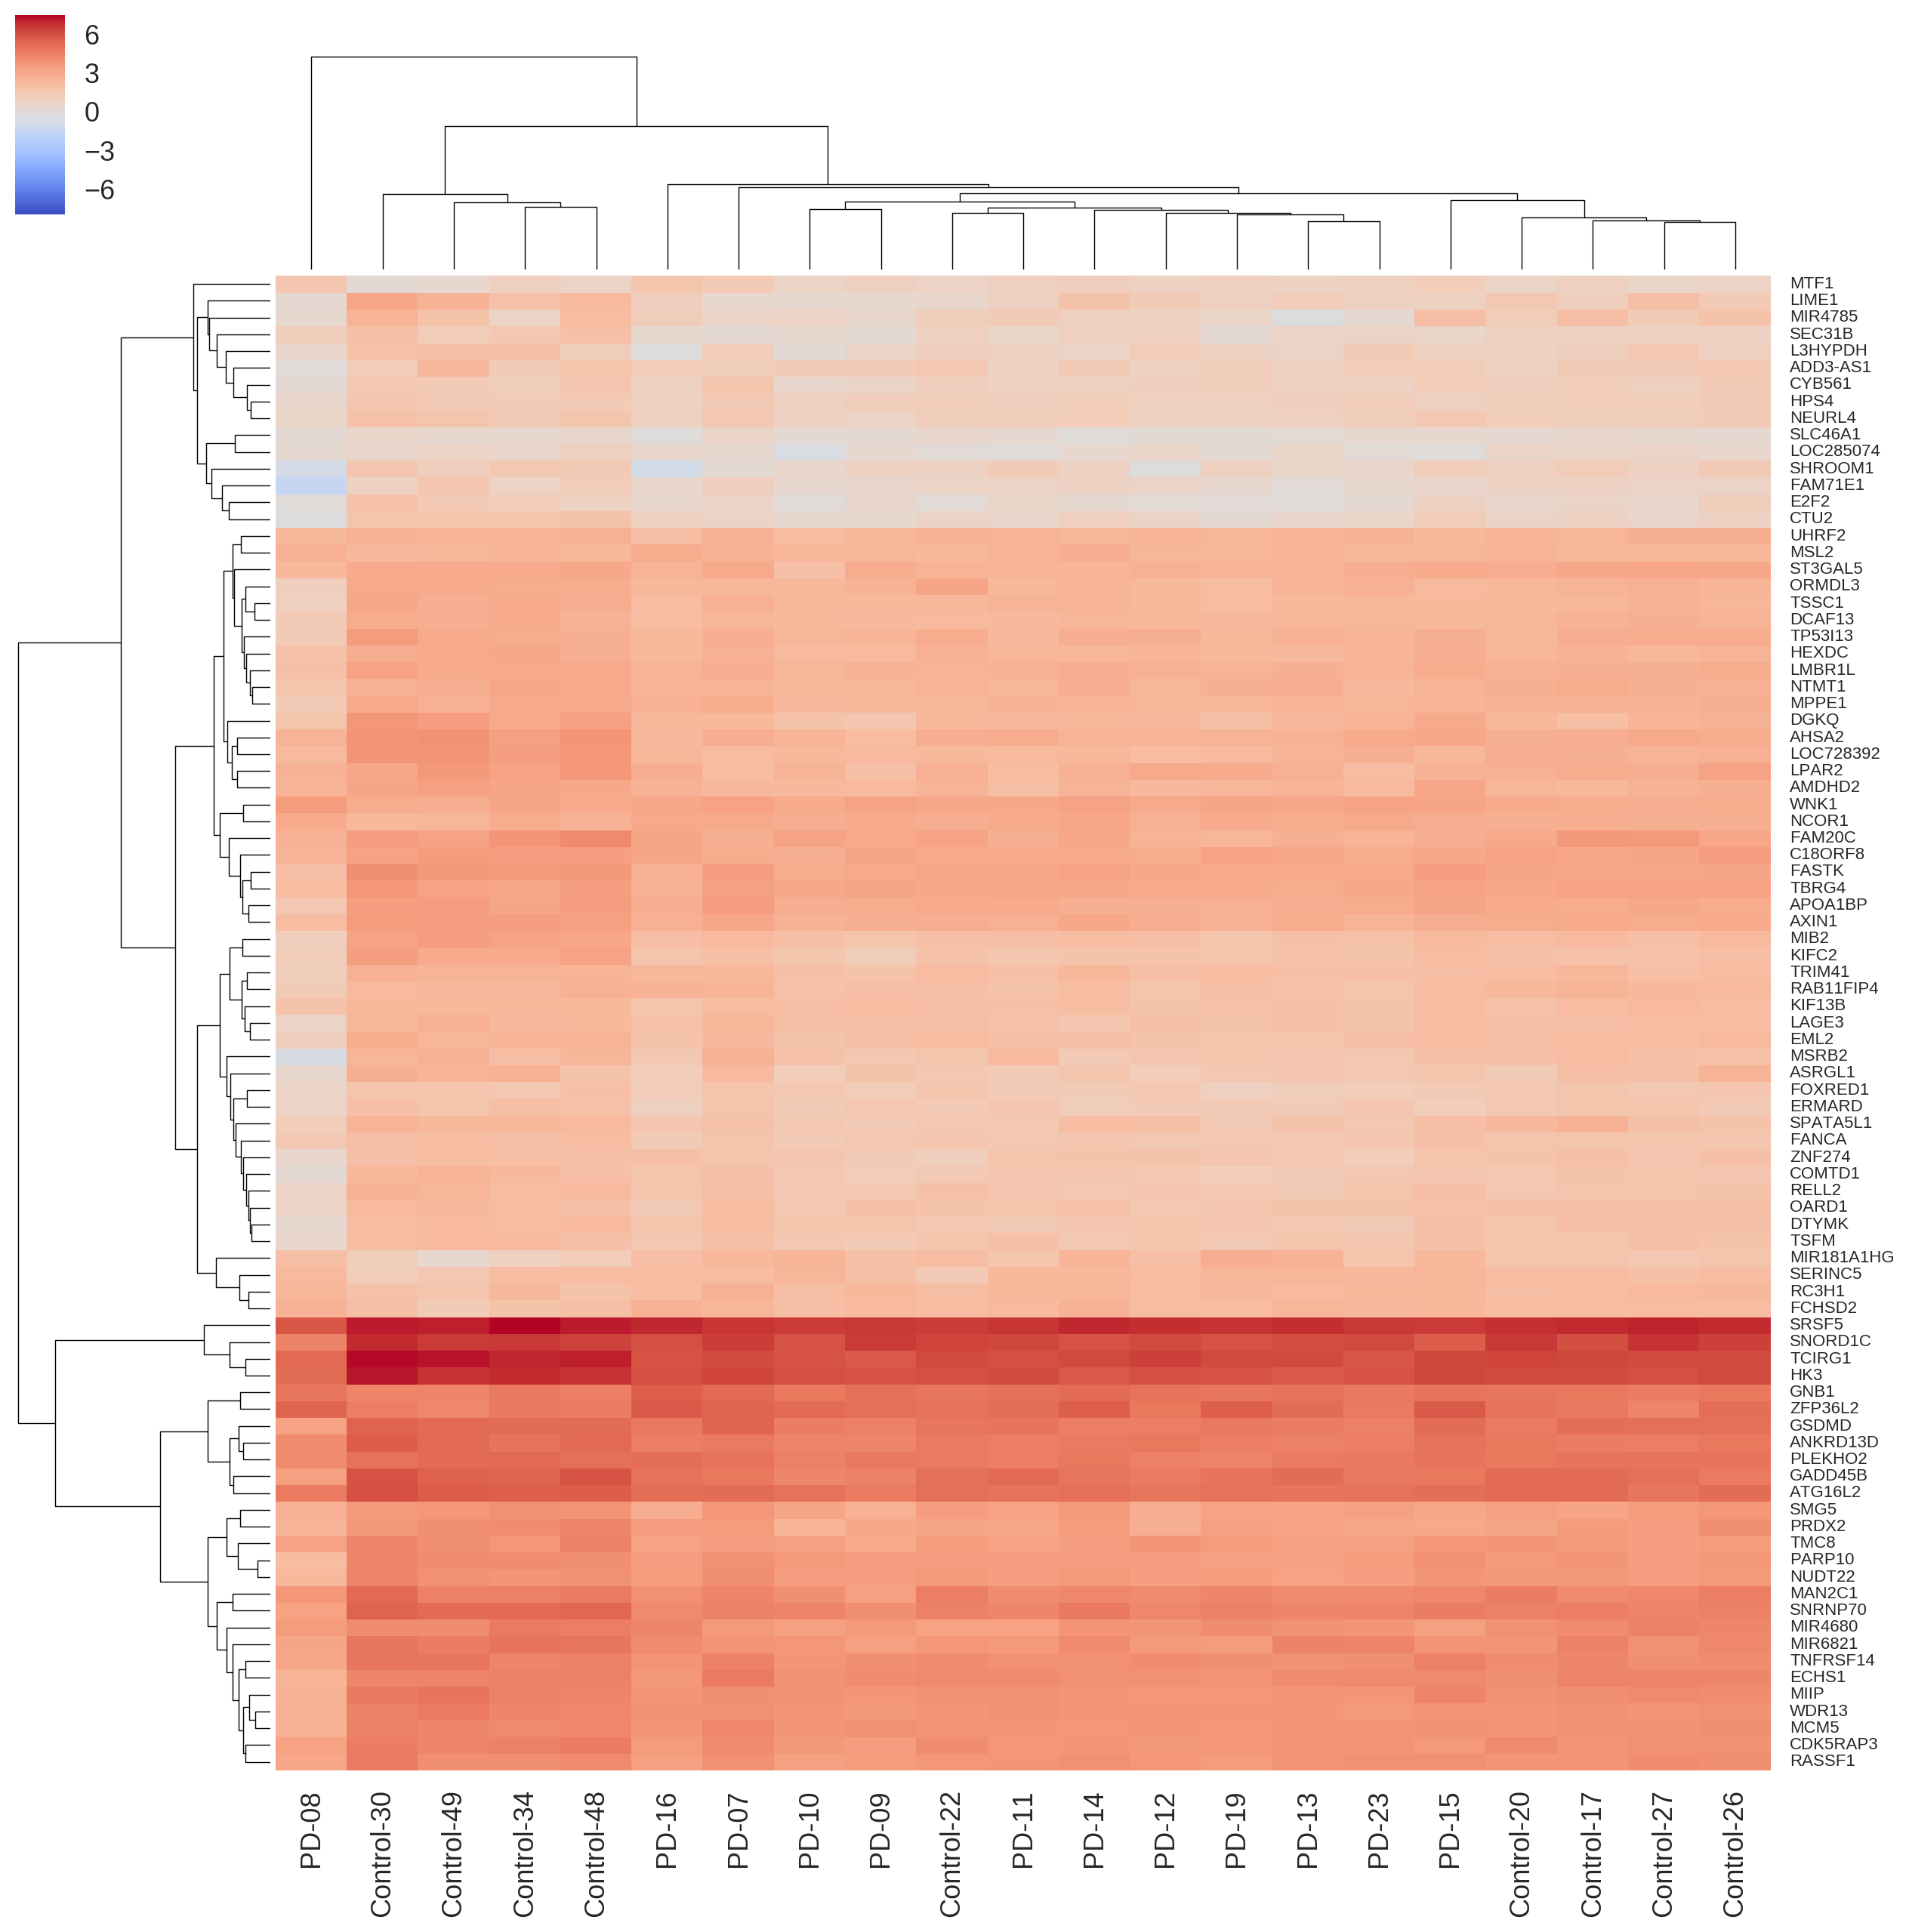

In [577]:
p_threshold = 0.005
kw_genes = stat_frame[stat_frame['KW pval'] < p_threshold]['gene'].values

data = filtered_rpkm_frame[\
                    filtered_rpkm_frame.index.isin([gene_refseq_mapping[x] for x in cv_genes])]
data.index = [refseq_gene_mapping[x] for x in data.index.values]
# data = sklearn.preprocessing.normalize(data,axis=1)
data = np.log2(data)
cg = sns.clustermap(data = data,
                    cmap='coolwarm',
                    figsize=(15,15),
#                     yticklabels=False
                    );
# plt.title("Log Kruskal–Wallis")
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=8);

# cg.ax_heatmap.set_yticklabels([]);
plt.savefig('genes_heatmap.pdf', bbox_inches='tight')

## Regressions

In [137]:
clinical_frame = pd.read_csv('clinical_data_160212.txt',sep='\t')
clinical_frame.index = clinical_frame['Sample Name'].values


In [138]:
samples = [x.split('_')[2] for x in clinical_frame.index.values]
simplifiedName_age_dict = dict(zip(samples,clinical_frame['Age']))
simplifiedName_duration_dict = dict(zip(samples,clinical_frame['Disease duration']))
simplifiedName_UPDRS_dict = dict(zip(samples,clinical_frame['UPDRS-III']))

In [139]:
clinical_plottingFrame = filtered_rpkm_plottingFrame.copy()

clinical_plottingFrame['age'] = [simplifiedName_age_dict[x] for x in clinical_plottingFrame['simplifiedName']]
clinical_plottingFrame['duration'] = [simplifiedName_duration_dict[x] for x in clinical_plottingFrame['simplifiedName']]
clinical_plottingFrame['updrs'] = [simplifiedName_UPDRS_dict[x] for x in clinical_plottingFrame['simplifiedName']]

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


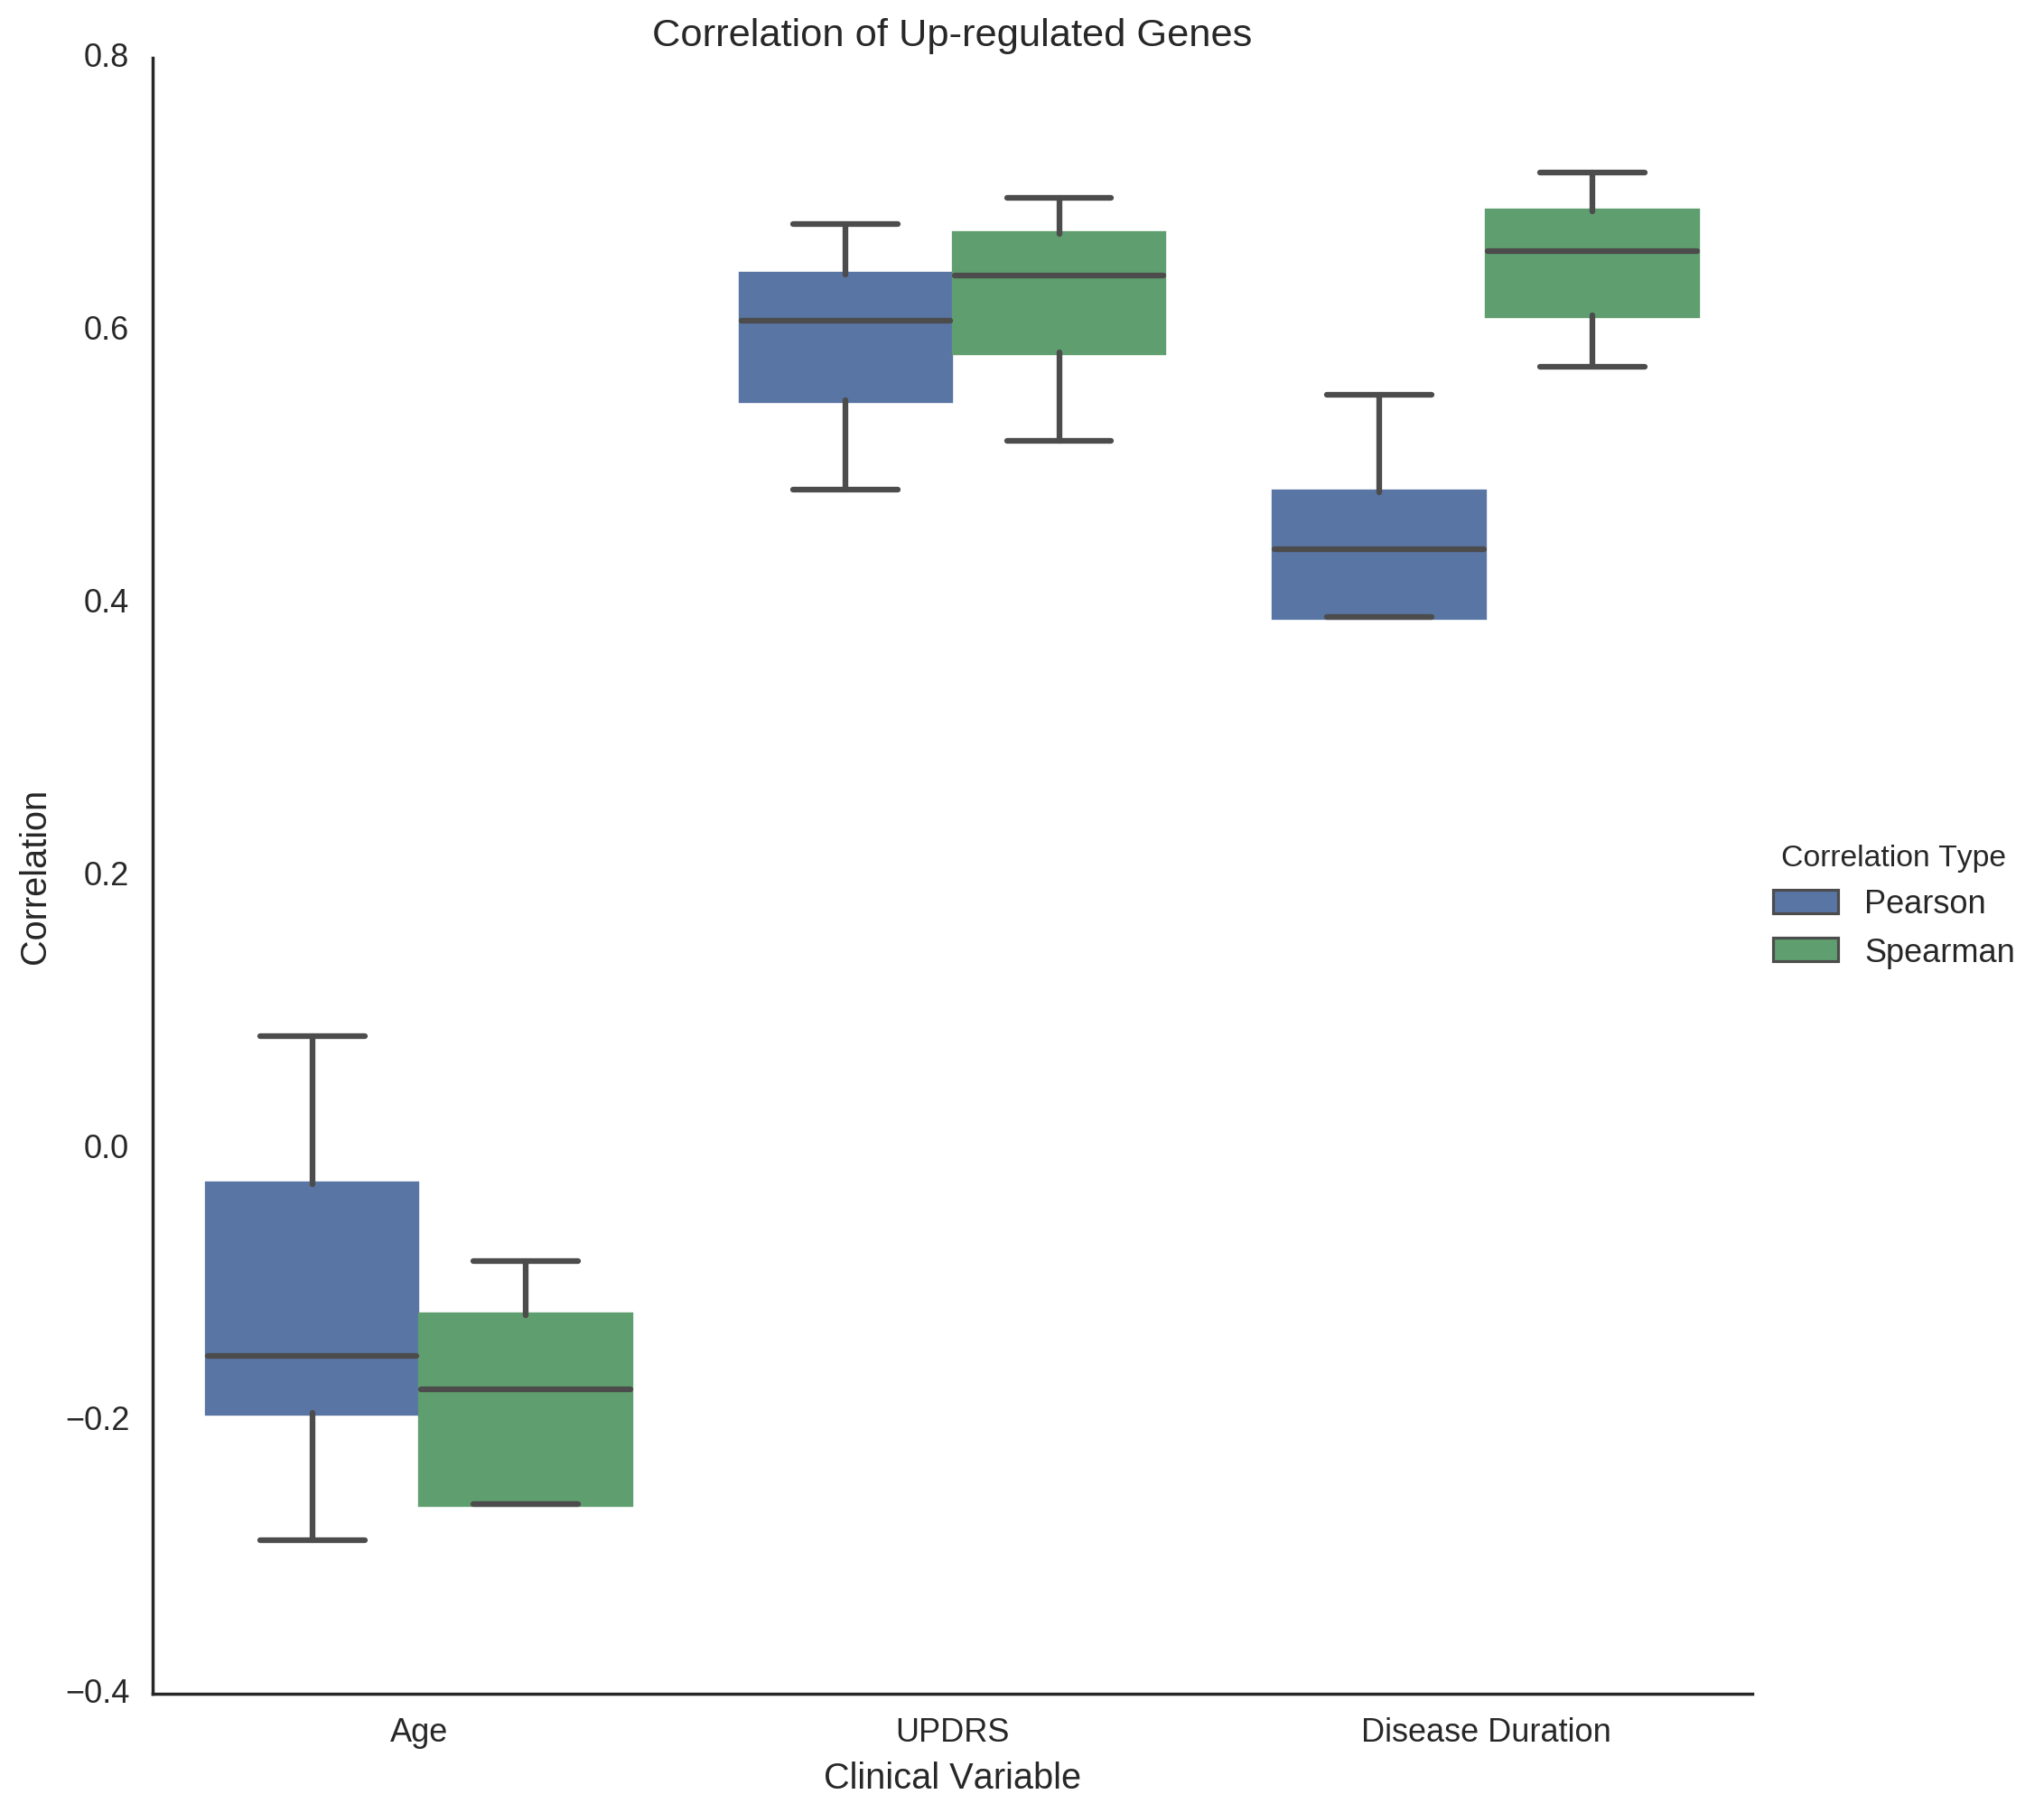

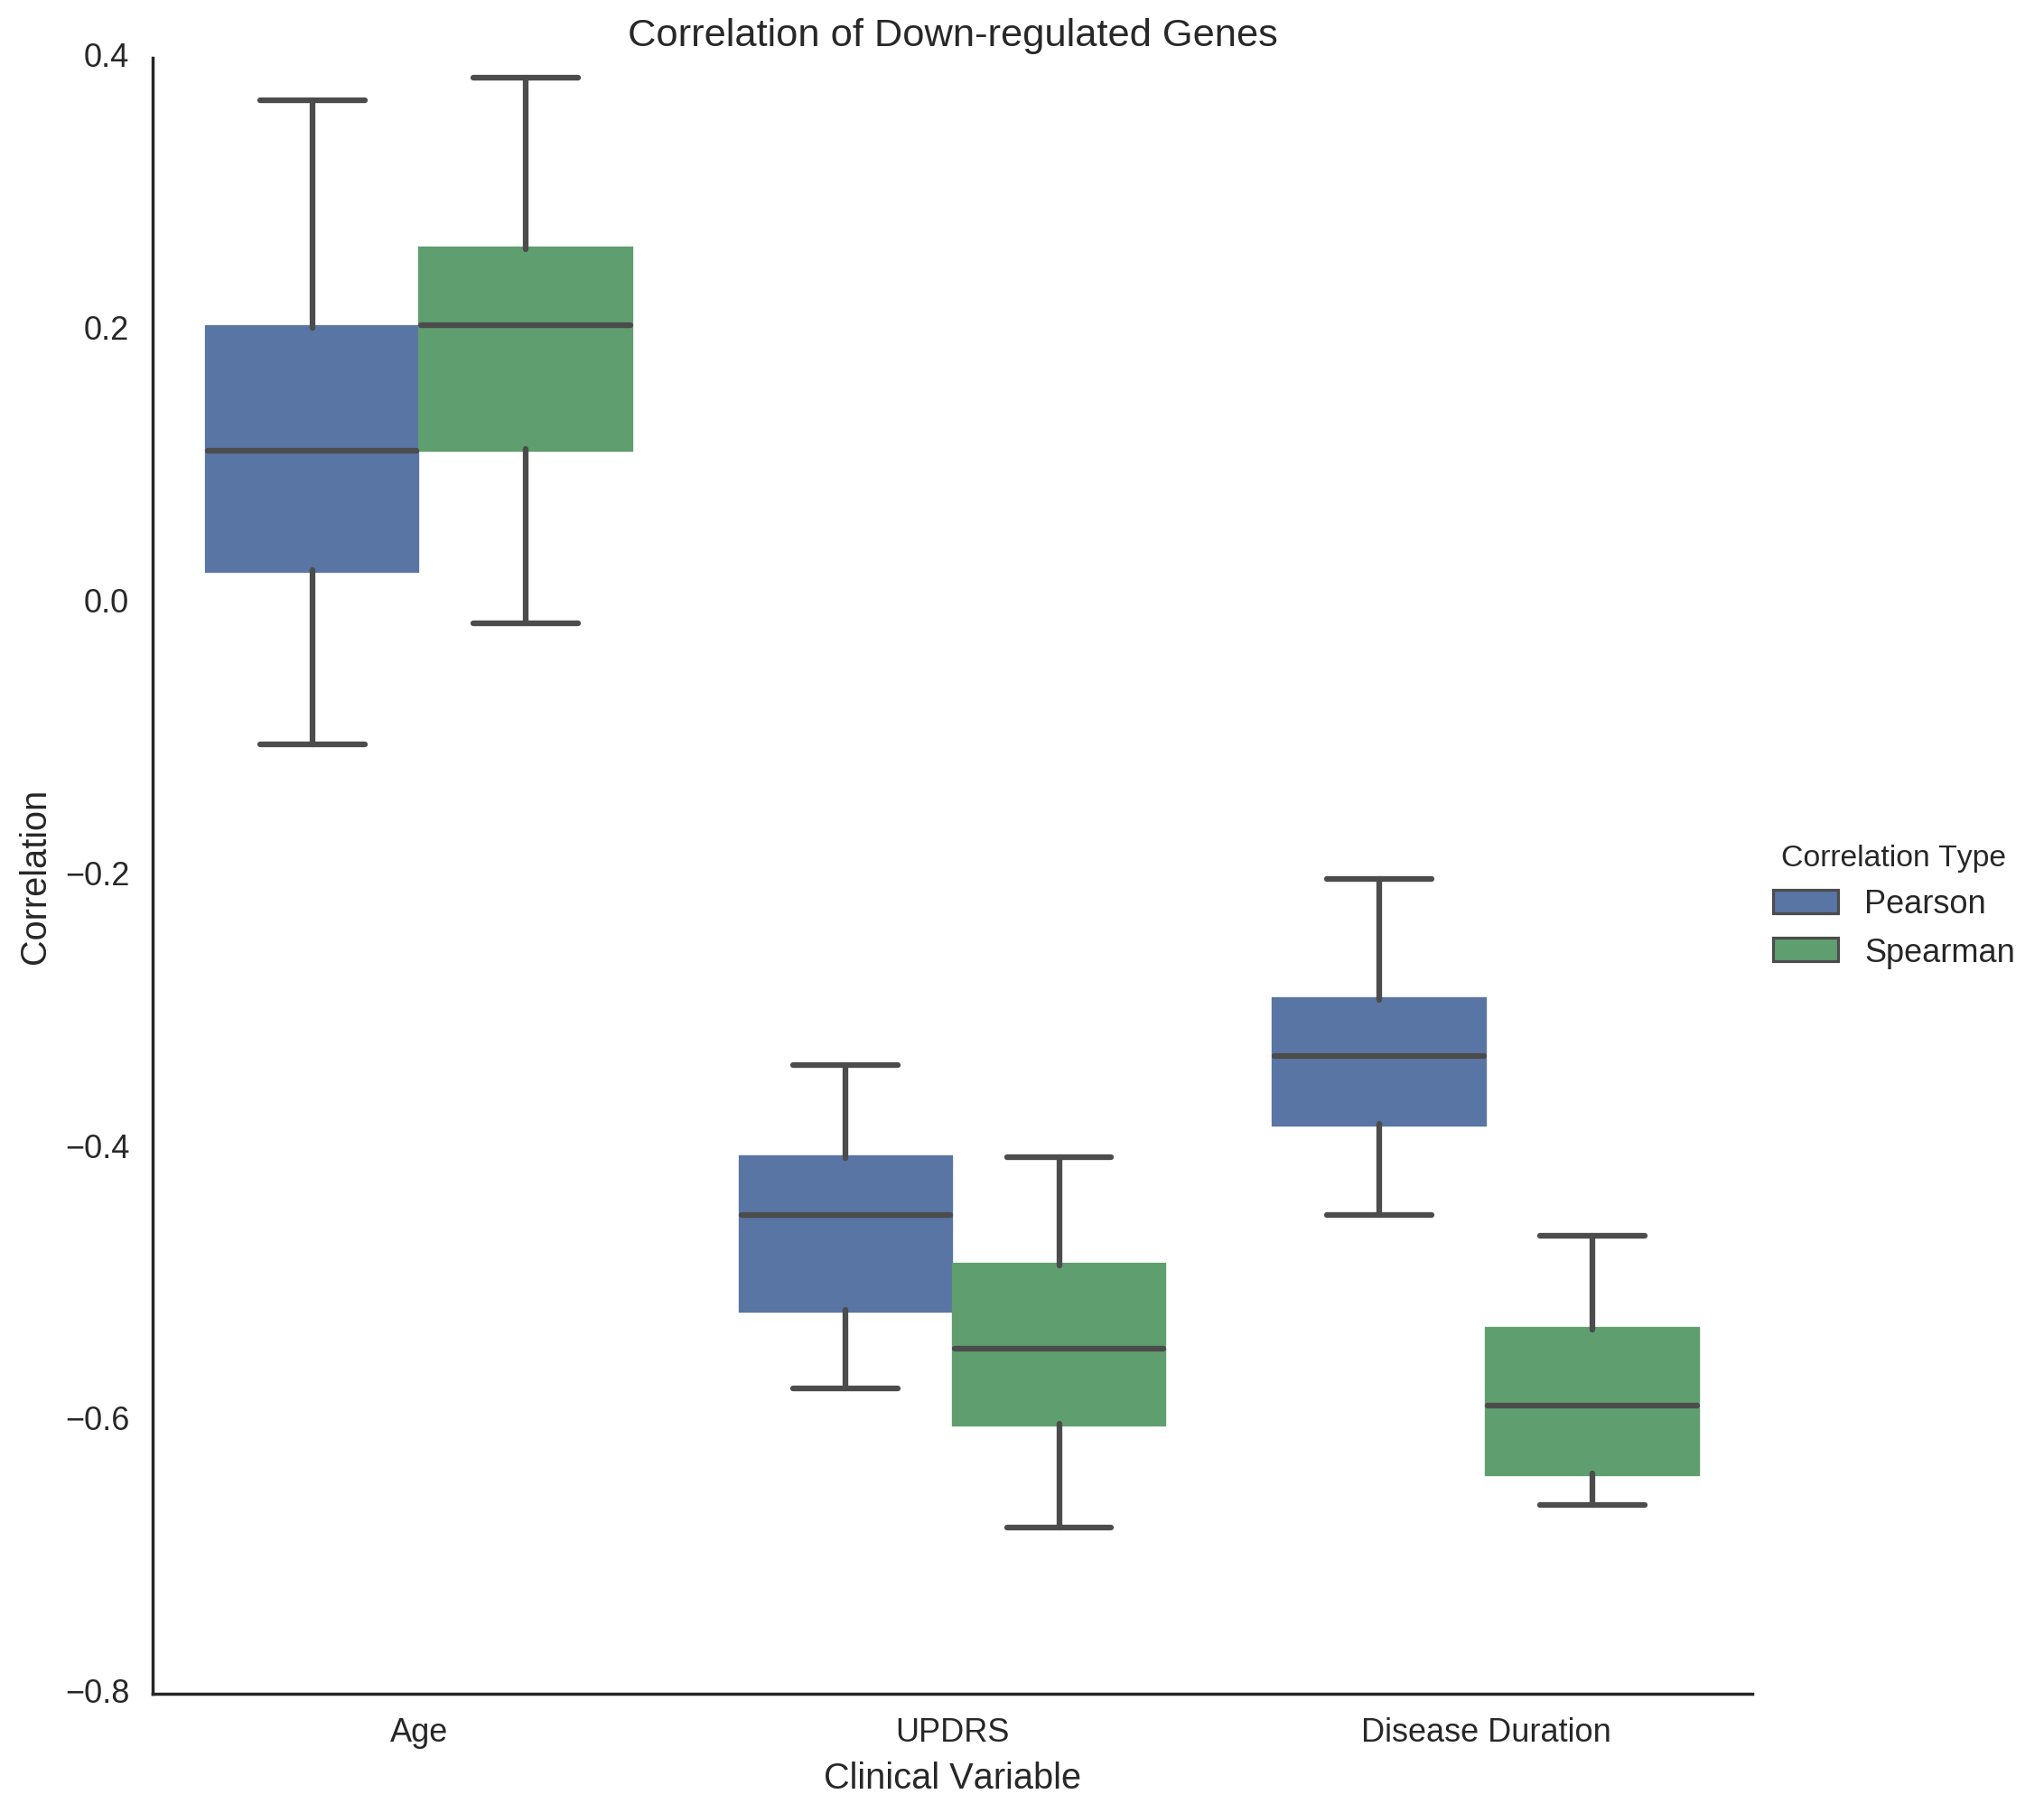

In [397]:
p_threshold = 0.005

clinical_vars = []
coefficient_types = []
coefficients = []
gene_list = stat_frame[(stat_frame['Up or Down'] == 'up') & (stat_frame['KW pval'] <p_threshold)]['gene']
idr_genes = stat_frame[stat_frame['passed IDR'] == True]['gene'].values
gene_list = [x for x in gene_list if x in cv_genes]
genes = []
for gene in set(clinical_plottingFrame[clinical_plottingFrame['gene'].isin(gene_list)]['gene'].values):
    currentVals = clinical_plottingFrame[clinical_plottingFrame['gene'] == gene]
    rpkms = currentVals['rpkm'].values
    ages = currentVals['age'].values
    updrs = currentVals['updrs'].values
    duration = currentVals['duration'].values

    r_pearson,p_pearson = stats.pearsonr(rpkms, ages)
    r_spearman,p_spearman = stats.spearmanr(rpkms, ages)
    
    # age testing 
    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('Age')
    clinical_vars.append('Age')


    # updrs testing
    r_pearson,p_pearson = stats.pearsonr(rpkms, updrs)
    r_spearman,p_spearman = stats.spearmanr(rpkms, updrs)

    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('UPDRS')
    clinical_vars.append('UPDRS')
    
    r_pearson,p_pearson = stats.pearsonr(rpkms, duration)
    r_spearman,p_spearman = stats.spearmanr(rpkms, duration)

    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('Disease Duration')
    clinical_vars.append('Disease Duration')
    
    genes = genes + 6 * [gene]
    


correlation_frame = pd.DataFrame({'Clinical Variable':clinical_vars,
                                 'Correlation Type': coefficient_types,
                                 'Correlation':coefficients,
                                 'Gene':genes})
sns.factorplot(x='Clinical Variable', 
               y='Correlation', 
               hue = 'Correlation Type', 
               data = correlation_frame, 
               kind='box', whis=1, showfliers=False, size=10)
plt.title('Correlation of Up-regulated Genes')
plt.savefig('clinical_correlation_up.pdf')
plt.show()

clinical_vars = []
coefficient_types = []
coefficients = []
# gene_list = stat_frame[(stat_frame['Up or Down'] == 'down') & (stat_frame['EdgeR pval'] <p_threshold)]['gene']
gene_list = stat_frame[(stat_frame['Up or Down'] == 'down') & (stat_frame['KW pval'] <p_threshold)]['gene']


gene_list = [x for x in gene_list if x in cv_genes]


genes = []
for gene in set(clinical_plottingFrame[clinical_plottingFrame['gene'].isin(gene_list)]['gene'].values):
    currentVals = clinical_plottingFrame[clinical_plottingFrame['gene'] == gene]
    rpkms = currentVals['rpkm'].values
    ages = currentVals['age'].values
    updrs = currentVals['updrs'].values
    duration = currentVals['duration'].values

    r_pearson,p_pearson = stats.pearsonr(rpkms, ages)
    r_spearman,p_spearman = stats.spearmanr(rpkms, ages)
    
    # age testing 
    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('Age')
    clinical_vars.append('Age')


    # updrs testing
    r_pearson,p_pearson = stats.pearsonr(rpkms, updrs)
    r_spearman,p_spearman = stats.spearmanr(rpkms, updrs)

    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('UPDRS')
    clinical_vars.append('UPDRS')
    
    r_pearson,p_pearson = stats.pearsonr(rpkms, duration)
    r_spearman,p_spearman = stats.spearmanr(rpkms, duration)

    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('Disease Duration')
    clinical_vars.append('Disease Duration')
    
    genes = genes + 6 * [gene]
    


correlation_frame = pd.DataFrame({'Clinical Variable':clinical_vars,
                                 'Correlation Type': coefficient_types,
                                 'Correlation':coefficients,
                                 'Gene':genes})
sns.factorplot(x='Clinical Variable', 
               y='Correlation', 
               hue = 'Correlation Type', 
               data = correlation_frame, 
               kind='box', whis=1, showfliers=False, size=10)
plt.title('Correlation of Down-regulated Genes')
plt.savefig('clinical_correlation_down.pdf')

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


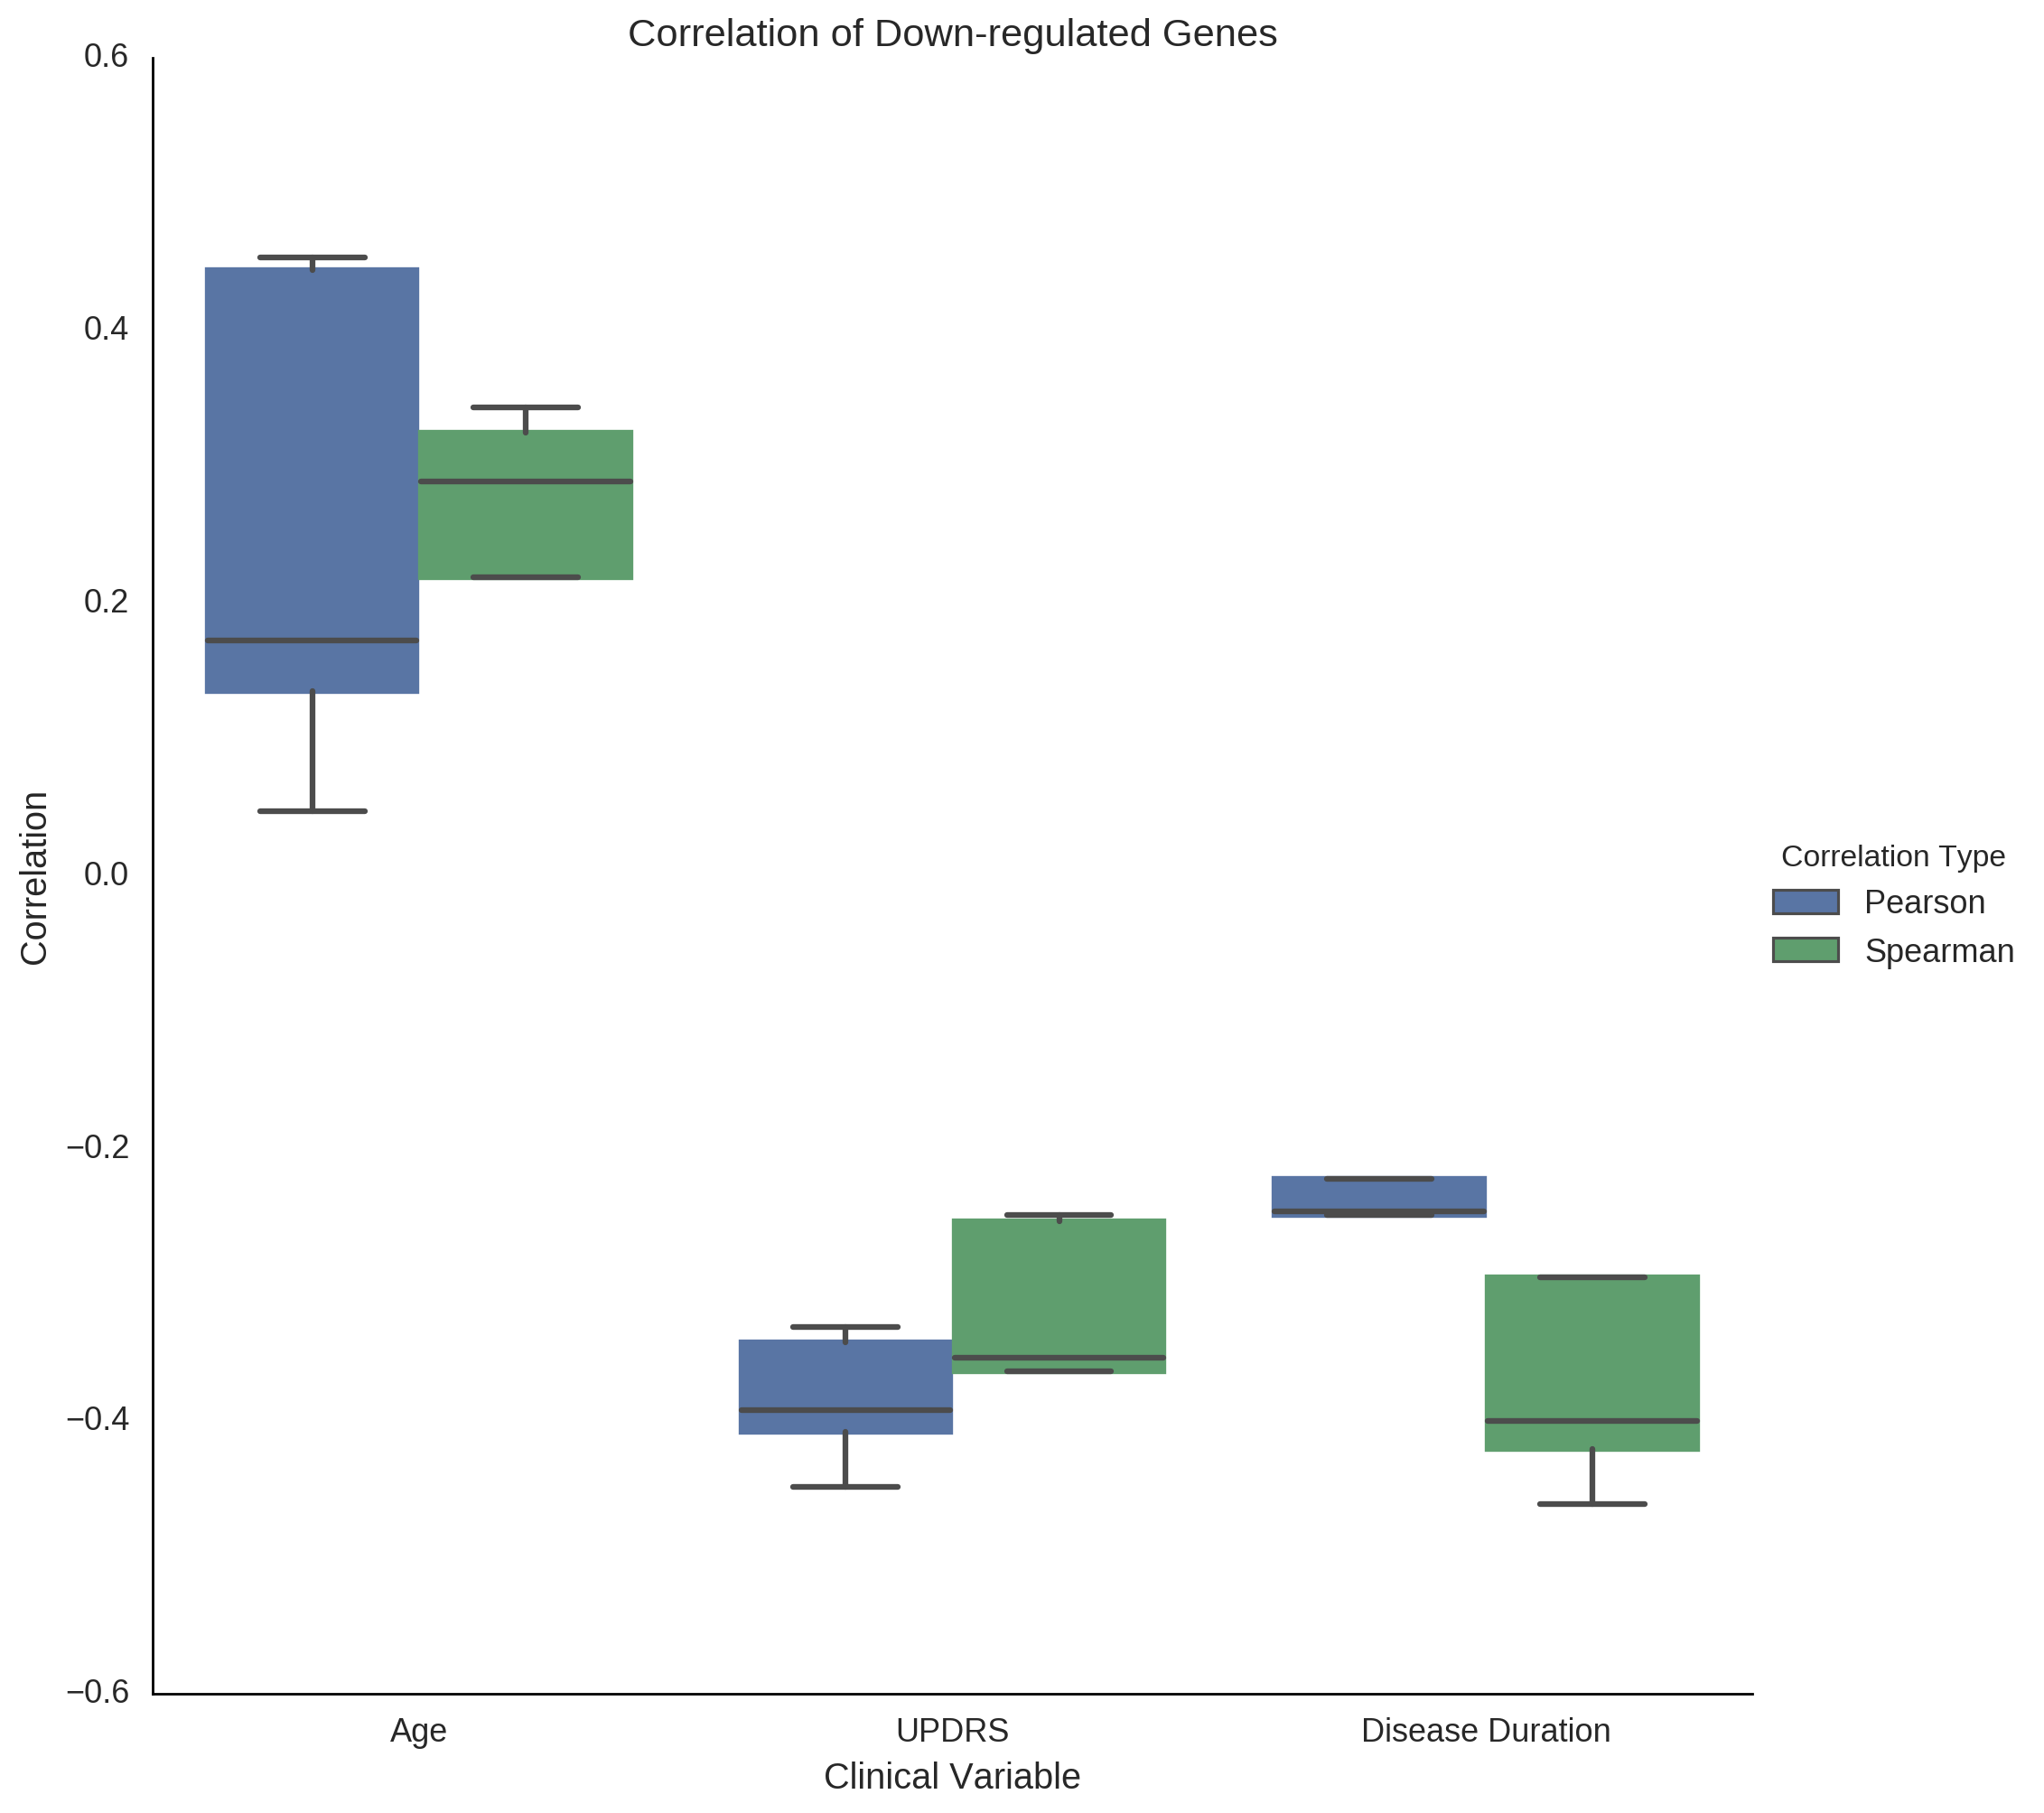

In [556]:
# clinical_vars = []
# coefficient_types = []
# coefficients = []
# gene_list = stat_frame[(stat_frame['Up or Down'] == 'up') & (stat_frame['fold'] >= 2.0)]['gene']
# # idr_genes = stat_frame[stat_frame['passed IDR'] == True]['gene'].values
# # gene_list = [x for x in gene_list if x in cv_genes]
# genes = []
# for gene in set(clinical_plottingFrame[clinical_plottingFrame['gene'].isin(gene_list)]['gene'].values):
#     currentVals = clinical_plottingFrame[clinical_plottingFrame['gene'] == gene]
#     rpkms = currentVals['rpkm'].values
#     ages = currentVals['age'].values
#     updrs = currentVals['updrs'].values
#     duration = currentVals['duration'].values

#     r_pearson,p_pearson = stats.pearsonr(rpkms, ages)
#     r_spearman,p_spearman = stats.spearmanr(rpkms, ages)
    
#     # age testing 
#     coefficients.append(r_pearson)
#     coefficient_types.append('Pearson')
#     coefficients.append(r_spearman)
#     coefficient_types.append('Spearman')
#     clinical_vars.append('Age')
#     clinical_vars.append('Age')


#     # updrs testing
#     r_pearson,p_pearson = stats.pearsonr(rpkms, updrs)
#     r_spearman,p_spearman = stats.spearmanr(rpkms, updrs)

#     coefficients.append(r_pearson)
#     coefficient_types.append('Pearson')
#     coefficients.append(r_spearman)
#     coefficient_types.append('Spearman')
#     clinical_vars.append('UPDRS')
#     clinical_vars.append('UPDRS')
    
#     r_pearson,p_pearson = stats.pearsonr(rpkms, duration)
#     r_spearman,p_spearman = stats.spearmanr(rpkms, duration)

#     coefficients.append(r_pearson)
#     coefficient_types.append('Pearson')
#     coefficients.append(r_spearman)
#     coefficient_types.append('Spearman')
#     clinical_vars.append('Disease Duration')
#     clinical_vars.append('Disease Duration')
    
#     genes = genes + 6 * [gene]
    


# correlation_frame = pd.DataFrame({'Clinical Variable':clinical_vars,
#                                  'Correlation Type': coefficient_types,
#                                  'Correlation':coefficients,
#                                  'Gene':genes})
# sns.factorplot(x='Clinical Variable', 
#                y='Correlation', 
#                hue = 'Correlation Type', 
#                data = correlation_frame, 
#                kind='box', whis=1, showfliers=False, size=10)
# plt.title('Correlation of Up-regulated Genes')
# plt.savefig('clinical_correlation_up.pdf')
# plt.show()

clinical_vars = []
coefficient_types = []
coefficients = []
# gene_list = stat_frame[(stat_frame['Up or Down'] == 'down') & (stat_frame['EdgeR pval'] <p_threshold)]['gene']
gene_list = stat_frame[(stat_frame['Up or Down'] == 'down') & (stat_frame['fold change'] <=0.50)]['gene']


# gene_list = [x for x in gene_list if x in cv_genes]


genes = []
for gene in set(clinical_plottingFrame[clinical_plottingFrame['gene'].isin(gene_list)]['gene'].values):
    currentVals = clinical_plottingFrame[clinical_plottingFrame['gene'] == gene]
    rpkms = currentVals['rpkm'].values
    ages = currentVals['age'].values
    updrs = currentVals['updrs'].values
    duration = currentVals['duration'].values

    r_pearson,p_pearson = stats.pearsonr(rpkms, ages)
    r_spearman,p_spearman = stats.spearmanr(rpkms, ages)
    
    # age testing 
    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('Age')
    clinical_vars.append('Age')


    # updrs testing
    r_pearson,p_pearson = stats.pearsonr(rpkms, updrs)
    r_spearman,p_spearman = stats.spearmanr(rpkms, updrs)

    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('UPDRS')
    clinical_vars.append('UPDRS')
    
    r_pearson,p_pearson = stats.pearsonr(rpkms, duration)
    r_spearman,p_spearman = stats.spearmanr(rpkms, duration)

    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('Disease Duration')
    clinical_vars.append('Disease Duration')
    
    genes = genes + 6 * [gene]
    


correlation_frame = pd.DataFrame({'Clinical Variable':clinical_vars,
                                 'Correlation Type': coefficient_types,
                                 'Correlation':coefficients,
                                 'Gene':genes})
sns.factorplot(x='Clinical Variable', 
               y='Correlation', 
               hue = 'Correlation Type', 
               data = correlation_frame, 
               kind='box', whis=1, showfliers=False, size=10)
plt.title('Correlation of Down-regulated Genes')
# plt.savefig('clinical_correlation_down.pdf')

In [548]:
stat_frame[stat_frame['fold change'] <=0.50]['gene']



628        UBE2S
2293         TNF
2359    C12ORF57
7553     MIR1229
8253       LIME1
Name: gene, dtype: object

In [549]:
stat_frame[stat_frame['fold change'] >=2.0]['gene']




Series([], name: gene, dtype: object)

## PCA Analysis

In [71]:
import sklearn

from sklearn import preprocessing

from sklearn import decomposition

from matplotlib import patches as mpatches

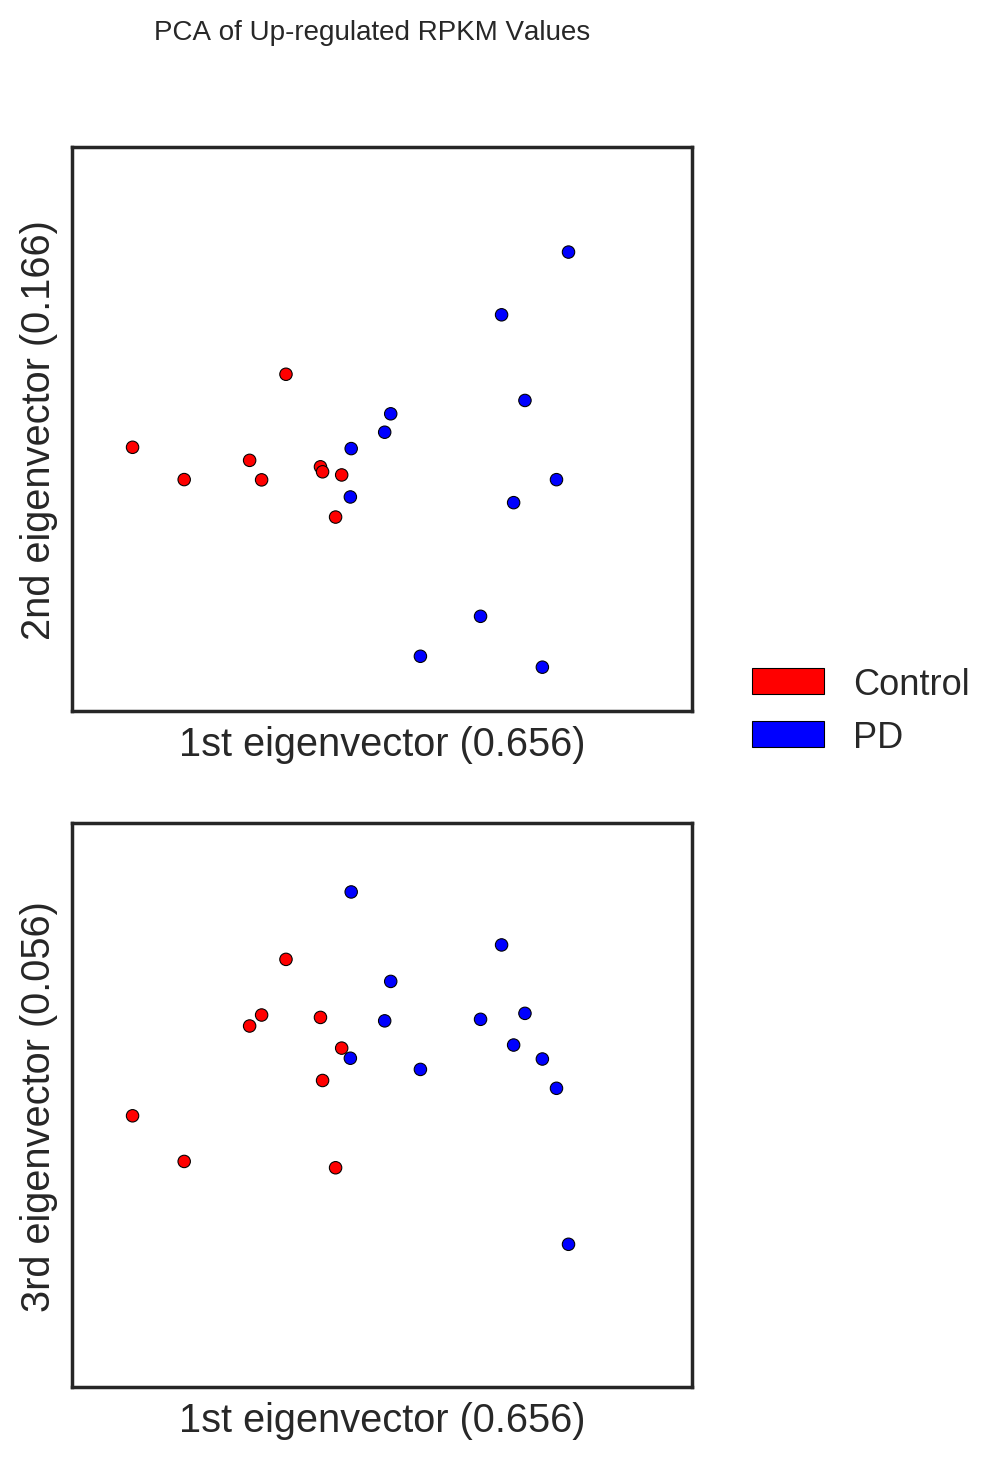

In [386]:
p_threshold = 0.005
gene_list = stat_frame[(stat_frame['Up or Down'] == 'up') & (stat_frame['KW pval'] <p_threshold)]['gene']
idr_genes = stat_frame[stat_frame['passed IDR'] == True]['gene'].values
gene_list = [x for x in gene_list if x in cv_genes]
refseq_list = [gene_refseq_mapping[x] for x in gene_list]
# features = filtered_rpkm_frame[filtered_rpkm_frame.index.isin(refseq_list)]
features = idr_rpkm_frame[idr_rpkm_frame.index.isin(gene_list)]
normalized_features = pd.DataFrame(preprocessing.normalize(features,axis=1))
normalized_features.columns = features.columns
normalized_features.index = features.index

colors = ['Blue' if 'PD' in x else 'red' for x in normalized_features.columns.values]


model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(normalized_features.T)
explained_variance_ratios = model.explained_variance_ratio_

sns.set_style('white')
f, axs = plt.subplots(2,1, figsize=(4,8))
                
plt.suptitle('PCA of Up-regulated RPKM Values')

# 1st and 2nd principal component
plt.subplot(2,1,1)               
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, s=20)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])

# legend
classes = sorted(set(filtered_summary_frame['simpleTreatment'].values))
class_colours = ['red', 'blue']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc='right', bbox_to_anchor=(1.5, 0))

# 1st and 3rd principal component
plt.subplot(2,1,2)               
plt.scatter(reduced_features[:, 0], reduced_features[:, 2], c=colors, s=20)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')
plt.yticks([])

plt.savefig('pca_2d_up.pdf', bbox_inches='tight')
plt.show()

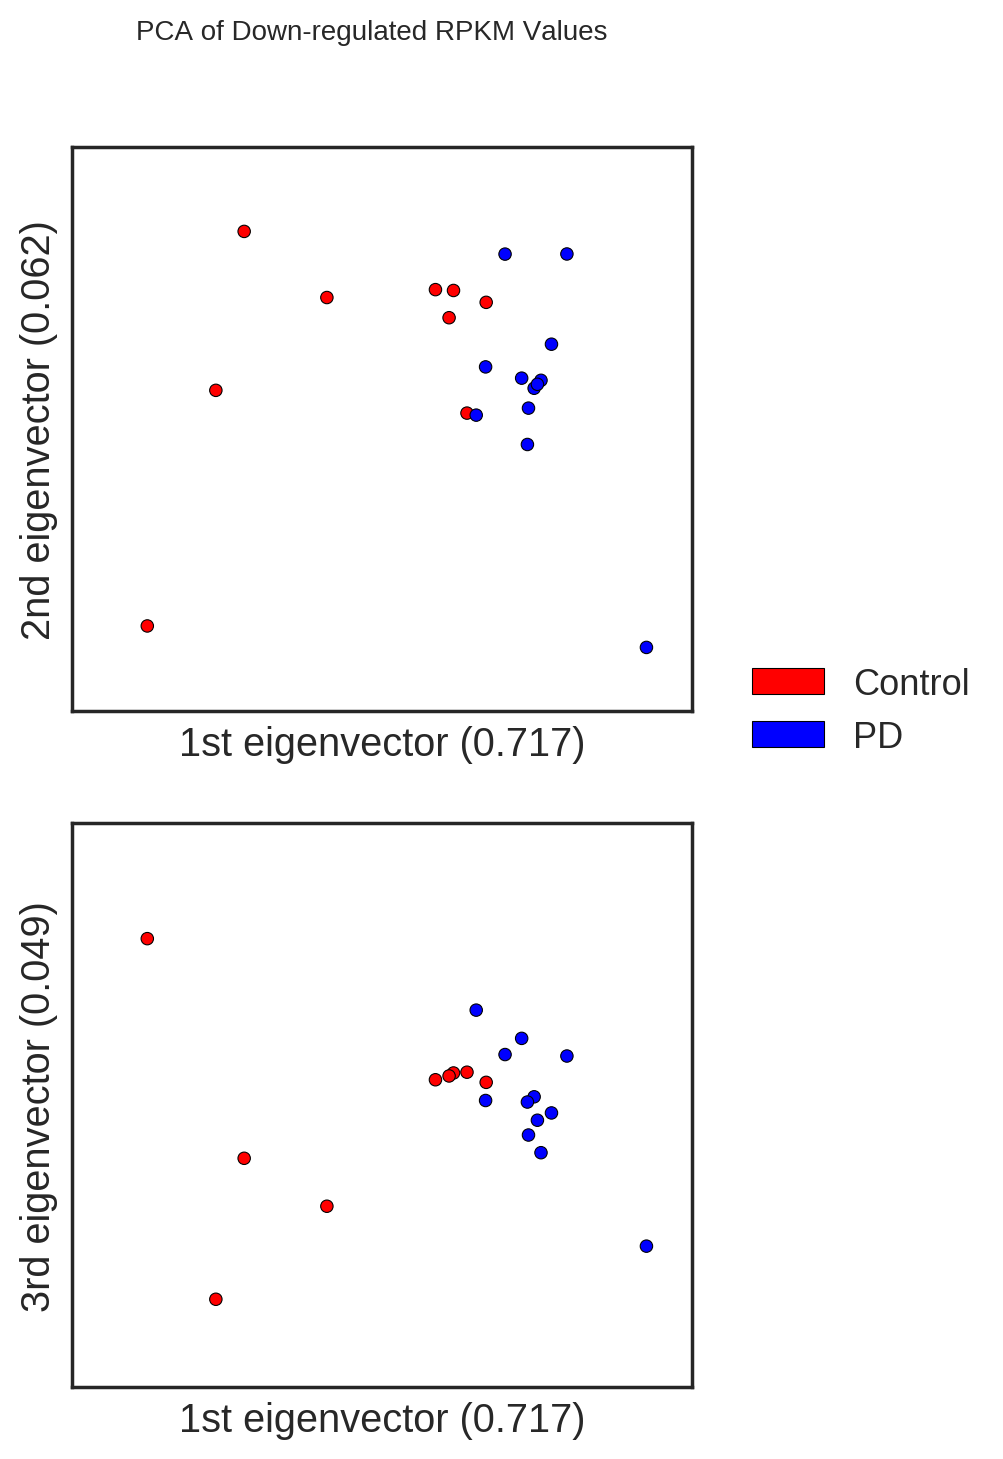

In [398]:
p_threshold = 0.005
gene_list = stat_frame[(stat_frame['Up or Down'] == 'down') & (stat_frame['KW pval'] <p_threshold)]['gene']
idr_genes = stat_frame[stat_frame['passed IDR'] == True]['gene'].values
gene_list = [x for x in gene_list if x in cv_genes]
# refseq_list = [gene_refseq_mapping[x] for x in gene_list]
# features = filtered_rpkm_frame[filtered_rpkm_frame.index.isin(refseq_list)]
features = idr_rpkm_frame[idr_rpkm_frame.index.isin(gene_list)]


normalized_features = pd.DataFrame(preprocessing.normalize(features,axis=1))
normalized_features.columns = features.columns
normalized_features.index = features.index

colors = ['Blue' if 'PD' in x else 'red' for x in normalized_features.columns.values]


model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(normalized_features.T)
explained_variance_ratios = model.explained_variance_ratio_

sns.set_style('white')
f, axs = plt.subplots(2,1, figsize=(4,8))
                
plt.suptitle('PCA of Down-regulated RPKM Values')

# 1st and 2nd principal component
plt.subplot(2,1,1)               
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, s=20)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])

# legend
classes = sorted(set(filtered_summary_frame['simpleTreatment'].values))
class_colours = ['red', 'blue']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc='right', bbox_to_anchor=(1.5, 0))

# 1st and 3rd principal component
plt.subplot(2,1,2)               
plt.scatter(reduced_features[:, 0], reduced_features[:, 2], c=colors, s=20)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')
plt.yticks([])

plt.savefig('pca_2d_down.pdf', bbox_inches='tight')
plt.show()

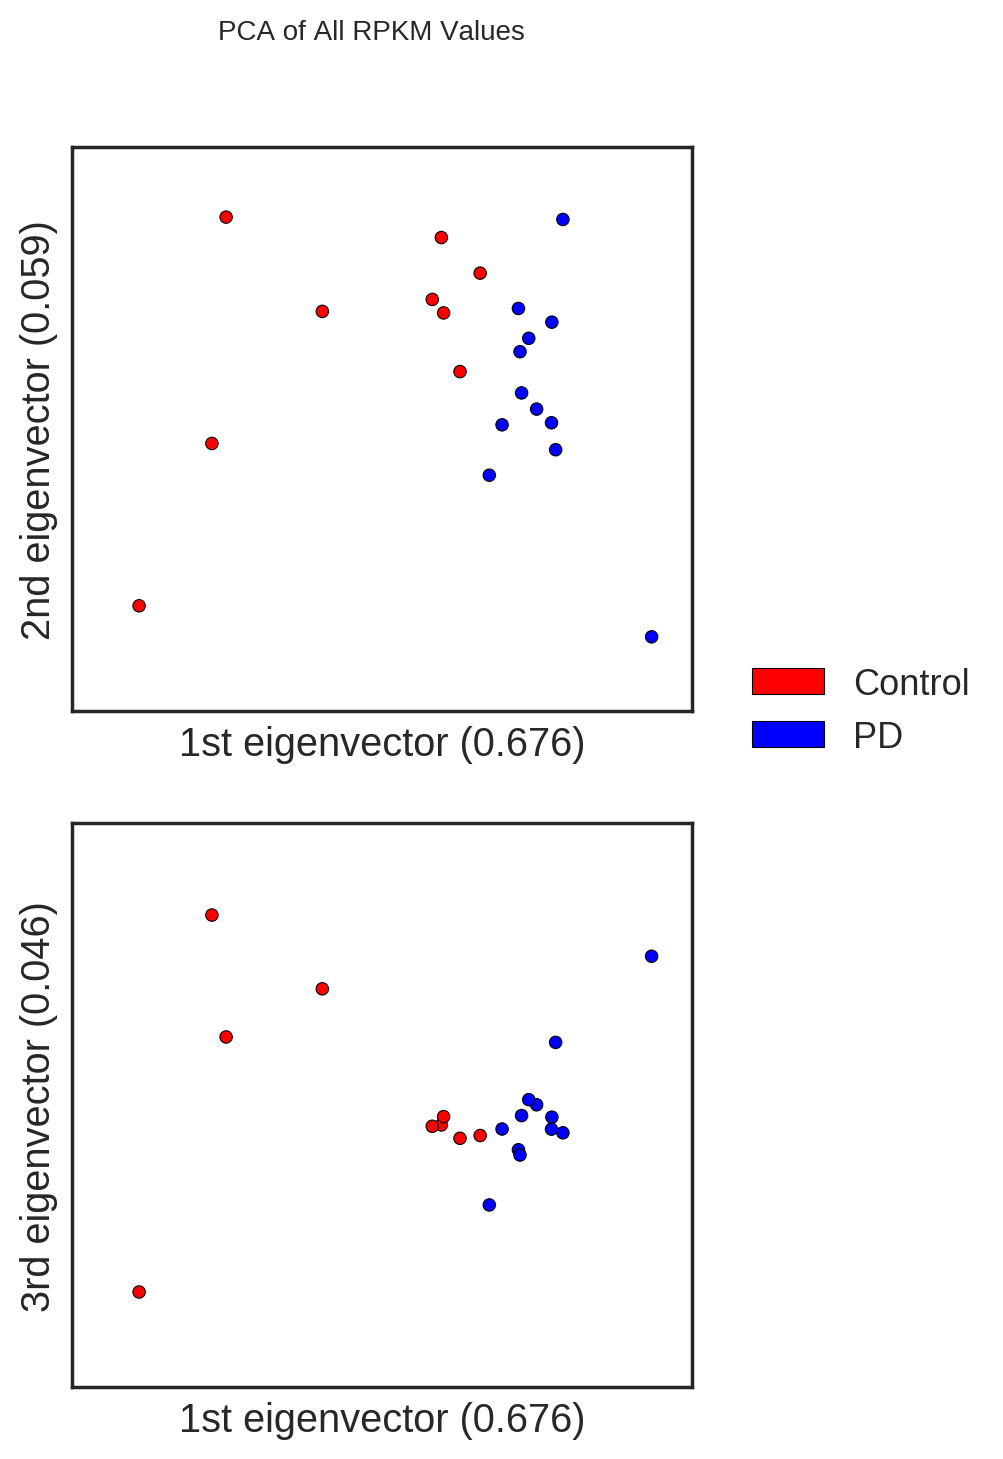

In [560]:
p_threshold = 0.005
gene_list = stat_frame[stat_frame['KW pval'] <p_threshold]['gene']
idr_genes = stat_frame[stat_frame['passed IDR'] == True]['gene'].values
gene_list = [x for x in gene_list if x in cv_genes]
# refseq_list = [gene_refseq_mapping[x] for x in gene_list]
# features = filtered_rpkm_frame[filtered_rpkm_frame.index.isin(refseq_list)]
features = idr_rpkm_frame[idr_rpkm_frame.index.isin(gene_list)]


normalized_features = pd.DataFrame(preprocessing.normalize(features,axis=1))
normalized_features.columns = features.columns
normalized_features.index = features.index

colors = ['Blue' if 'PD' in x else 'red' for x in normalized_features.columns.values]


model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(normalized_features.T)
explained_variance_ratios = model.explained_variance_ratio_

sns.set_style('white')
f, axs = plt.subplots(2,1, figsize=(4,8))
                
plt.suptitle('PCA of All RPKM Values')

# 1st and 2nd principal component
plt.subplot(2,1,1)               
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, s=20)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])

# legend
classes = sorted(set(filtered_summary_frame['simpleTreatment'].values))
class_colours = ['red', 'blue']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc='right', bbox_to_anchor=(1.5, 0))

# 1st and 3rd principal component
plt.subplot(2,1,2)               
plt.scatter(reduced_features[:, 0], reduced_features[:, 2], c=colors, s=20)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')
plt.yticks([])

plt.savefig('pca_2d_all.pdf', bbox_inches='tight')
plt.show()

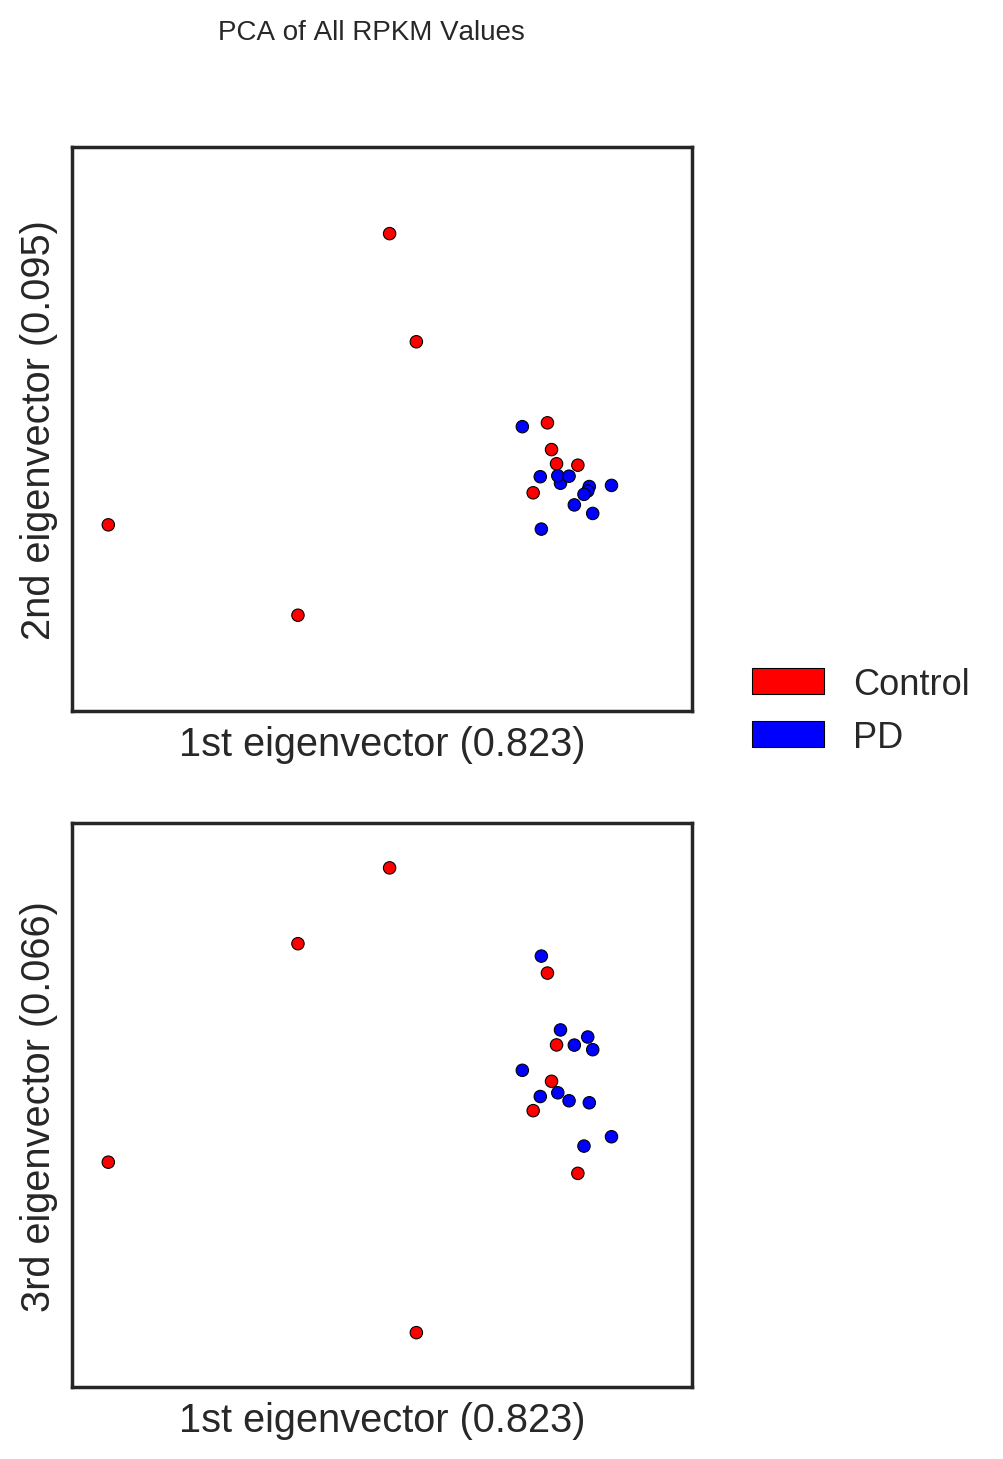

In [557]:
fold_genes = stat_frame[(stat_frame['Up or Down'] == 'down') & (stat_frame['fold change'] <=0.50)]['gene']

p_threshold = 0.005
# gene_list = stat_frame[stat_frame['KW pval'] <p_threshold]['gene']
# idr_genes = stat_frame[stat_frame['passed IDR'] == True]['gene'].values
gene_list = fold_genes
# refseq_list = [gene_refseq_mapping[x] for x in gene_list]
# features = filtered_rpkm_frame[filtered_rpkm_frame.index.isin(refseq_list)]
features = idr_rpkm_frame[idr_rpkm_frame.index.isin(gene_list)]


normalized_features = pd.DataFrame(preprocessing.normalize(features,axis=1))
normalized_features.columns = features.columns
normalized_features.index = features.index

colors = ['Blue' if 'PD' in x else 'red' for x in normalized_features.columns.values]


model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(normalized_features.T)
explained_variance_ratios = model.explained_variance_ratio_

sns.set_style('white')
f, axs = plt.subplots(2,1, figsize=(4,8))
                
plt.suptitle('PCA of All RPKM Values')

# 1st and 2nd principal component
plt.subplot(2,1,1)               
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, s=20)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])

# legend
classes = sorted(set(filtered_summary_frame['simpleTreatment'].values))
class_colours = ['red', 'blue']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc='right', bbox_to_anchor=(1.5, 0))

# 1st and 3rd principal component
plt.subplot(2,1,2)               
plt.scatter(reduced_features[:, 0], reduced_features[:, 2], c=colors, s=20)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')
plt.yticks([])

# plt.savefig('pca_2d_all.pdf', bbox_inches='tight')
plt.show()

## Gene Ontology Analysis

In [400]:
p_threshold = 0.005
gene_list_up = stat_frame[(stat_frame['KW pval'] <p_threshold) & (stat_frame['Up or Down'] == 'up')]['gene'].values
gene_list_up = [x for x in gene_list_up if x in cv_genes]
gene_list_down = stat_frame[(stat_frame['KW pval'] <p_threshold) & (stat_frame['Up or Down'] == 'down')]['gene'].values
gene_list_down = [x for x in gene_list_down if x in cv_genes]

# write target genes file
outFile = open('go_genes_up.txt', 'w')
for g in gene_list_up:
    outFile.write(g.upper()+ '\n')
outFile.close()

outFile = open('go_genes_down.txt', 'w')
for g in gene_list_down:
    outFile.write(g.upper()+ '\n')
outFile.close()

# write background file
outFile = open('background.txt', 'w')
for g in [refseq_gene_mapping[x] for x in filtered_rpkm_frame.index.values]:
    outFile.write(g.upper() + '\n')
outFile.close()

In [401]:
# os.system('/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./go_genes_up.txt ./background.txt /home/jenhan/analysis/go_analysis/human_association --pval=0.05 > ./go_results_up.txt')

# os.system('/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./go_genes_down.txt ./background.txt /home/jenhan/analysis/go_analysis/human_association --pval=0.05 > ./go_results_down.txt')

print('/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./go_genes_up.txt ./background.txt /home/jenhan/analysis/go_analysis/human_association --pval=0.05 > ./go_results_up.txt')

print('/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./go_genes_down.txt ./background.txt /home/jenhan/analysis/go_analysis/human_association --pval=0.05 > ./go_results_down.txt')




/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./go_genes_up.txt ./background.txt /home/jenhan/analysis/go_analysis/human_association --pval=0.05 > ./go_results_up.txt
/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./go_genes_down.txt ./background.txt /home/jenhan/analysis/go_analysis/human_association --pval=0.05 > ./go_results_down.txt


In [486]:
go_frame_up = pd.read_csv('go_results_up.txt',sep='\t', skiprows=2)

In [487]:
go_frame_down = pd.read_csv('go_results_down.txt',sep='\t', skiprows=2)

In [82]:
gene_go_dict = {}
go_gene_dict = {}
with open('/home/jenhan/analysis/go_analysis/human_association') as f:
    data = f.readlines()
for line in data:
    tokens = line.strip().split('\t')
    gene = tokens[0]
    terms = tokens[1].split(';')
    gene_go_dict[gene] = terms
    for t in terms:
        if t in go_gene_dict:
            go_gene_dict[t].append(gene)
        else:
            go_gene_dict[t] = [gene]

        

In [496]:
go_description_dict = dict(zip(go_frame_up['id'].values, go_frame_up['description'].values))
go_description_dict.update(dict(zip(go_frame_down['id'].values, go_frame_down['description'].values)))

In [504]:
term_children_dict = {
'GO:0060563':set(['GO:0060563','GO:0061453', 'GO:0030318', 'GO:0050933', 'GO:0042491', 'GO:0050934', 'GO:0060531', 'GO:0061104', 'GO:0061102', 'GO:0061103', 'GO:0061100', 'GO:0061101', 'GO:0060129', 'GO:0071895']),
'GO:0046328':set(['GO:0046328','GO:0007256', 'GO:0046329', 'GO:0046330', 'GO:0042655', 'GO:0043508', 'GO:0007257', 'GO:0043506', 'GO:0043507']),
'GO:0030217':set(['GO:0046632', 'GO:0061470', 'GO:0002361', 'GO:0042093', 'GO:0002303', 'GO:0002302', 'GO:0002301', 'GO:0002300', 'GO:1904156', 'GO:1904157', 'GO:0001865', 'GO:0002304', 'GO:0002307', 'GO:0002308', 'GO:0043367', 'GO:0002306', 'GO:0002305', 'GO:0033077', 'GO:0033078', 'GO:1904155', 'GO:0072539', 'GO:0045066', 'GO:0045063', 'GO:0002293', 'GO:0002292', 'GO:0002294', 'GO:0045065', 'GO:0045064', 'GO:0002299', 'GO:0002298', 'GO:0042492', 'GO:0043379', 'GO:0043374']),
'GO:0042110': set(['GO:0002289', 'GO:0033080', 'GO:0046633', 'GO:0046632', 'GO:0061470', 'GO:0046630', 'GO:0042722', 'GO:0002303', 'GO:0002302', 'GO:0002301', 'GO:0002300', 'GO:1904156', 'GO:0001866', 'GO:0001865', 'GO:0002304', 'GO:0002307', 'GO:0002309', 'GO:0002308', 'GO:0043367', 'GO:1904157', 'GO:0002305', 'GO:0030217', 'GO:1904155', 'GO:0046631', 'GO:0035709', 'GO:0045063', 'GO:0045066', 'GO:0045065', 'GO:0045064', 'GO:0042492', 'GO:0043379', 'GO:0043316', 'GO:0035739', 'GO:0043374', 'GO:0046629', 'GO:0002306', 'GO:0036037', 'GO:0050798', 'GO:0042093', 'GO:0002286', 'GO:0002287', 'GO:0002288', 'GO:0042098', 'GO:0002361', 'GO:0035712', 'GO:0035741', 'GO:0035740', 'GO:0051132', 'GO:0035742', 'GO:0033077', 'GO:0033079', 'GO:0033078', 'GO:0001777', 'GO:0072539', 'GO:0002291', 'GO:0002290', 'GO:0002293', 'GO:0002292', 'GO:0002294', 'GO:0061485', 'GO:0002299', 'GO:0002298', 'GO:0002310', 'GO:0002311', 'GO:0035710', 'GO:0035711'])
                     }

In [512]:
_genes = []
_descriptions = []

for term in term_children_dict.keys():
    genes = []
    for t in term_children_dict[term]:
        if t in go_gene_dict:
            genes = genes+ go_gene_dict[t]
    genes = sorted(set(genes))
    print('***',term, go_description_dict[term], len(genes))
    for g in genes:
        if g.upper() in cv_genes or g in cv_genes:
            print(g)
            _genes.append(g)
            _descriptions.append(go_description_dict[term])


gene_description_dict = dict(zip(_genes, _descriptions))

*** GO:0046328 regulation of JNK cascade 158
AXIN1
GADD45B
NCOR1
*** GO:0030217 T cell differentiation 73
NCOR1
RC3H1
ZFP36L2
*** GO:0060563 neuroepithelial cell differentiation 45
FAM20C
HPS4
*** GO:0042110 T cell activation 173
NCOR1
PRDX2
RC3H1
ZFP36L2


In [514]:
sig_genes = _genes
go_plotting_frame = filtered_rpkm_plottingFrame[filtered_rpkm_plottingFrame['gene'].isin(sig_genes)]
gene_pval_dict = dict(zip(stat_frame['gene'].values, stat_frame['KW pval'].values))
go_plotting_frame['Term'] = [gene_description_dict[x] for x in go_plotting_frame['gene']]
go_plotting_frame['p-value']=[gene_pval_dict[x] for x in go_plotting_frame['gene']]
go_plotting_frame.columns = ['Gene', 'Refseq', 'RPKM', 'Sample Name', 'Group', 'Term', 'p-value']

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


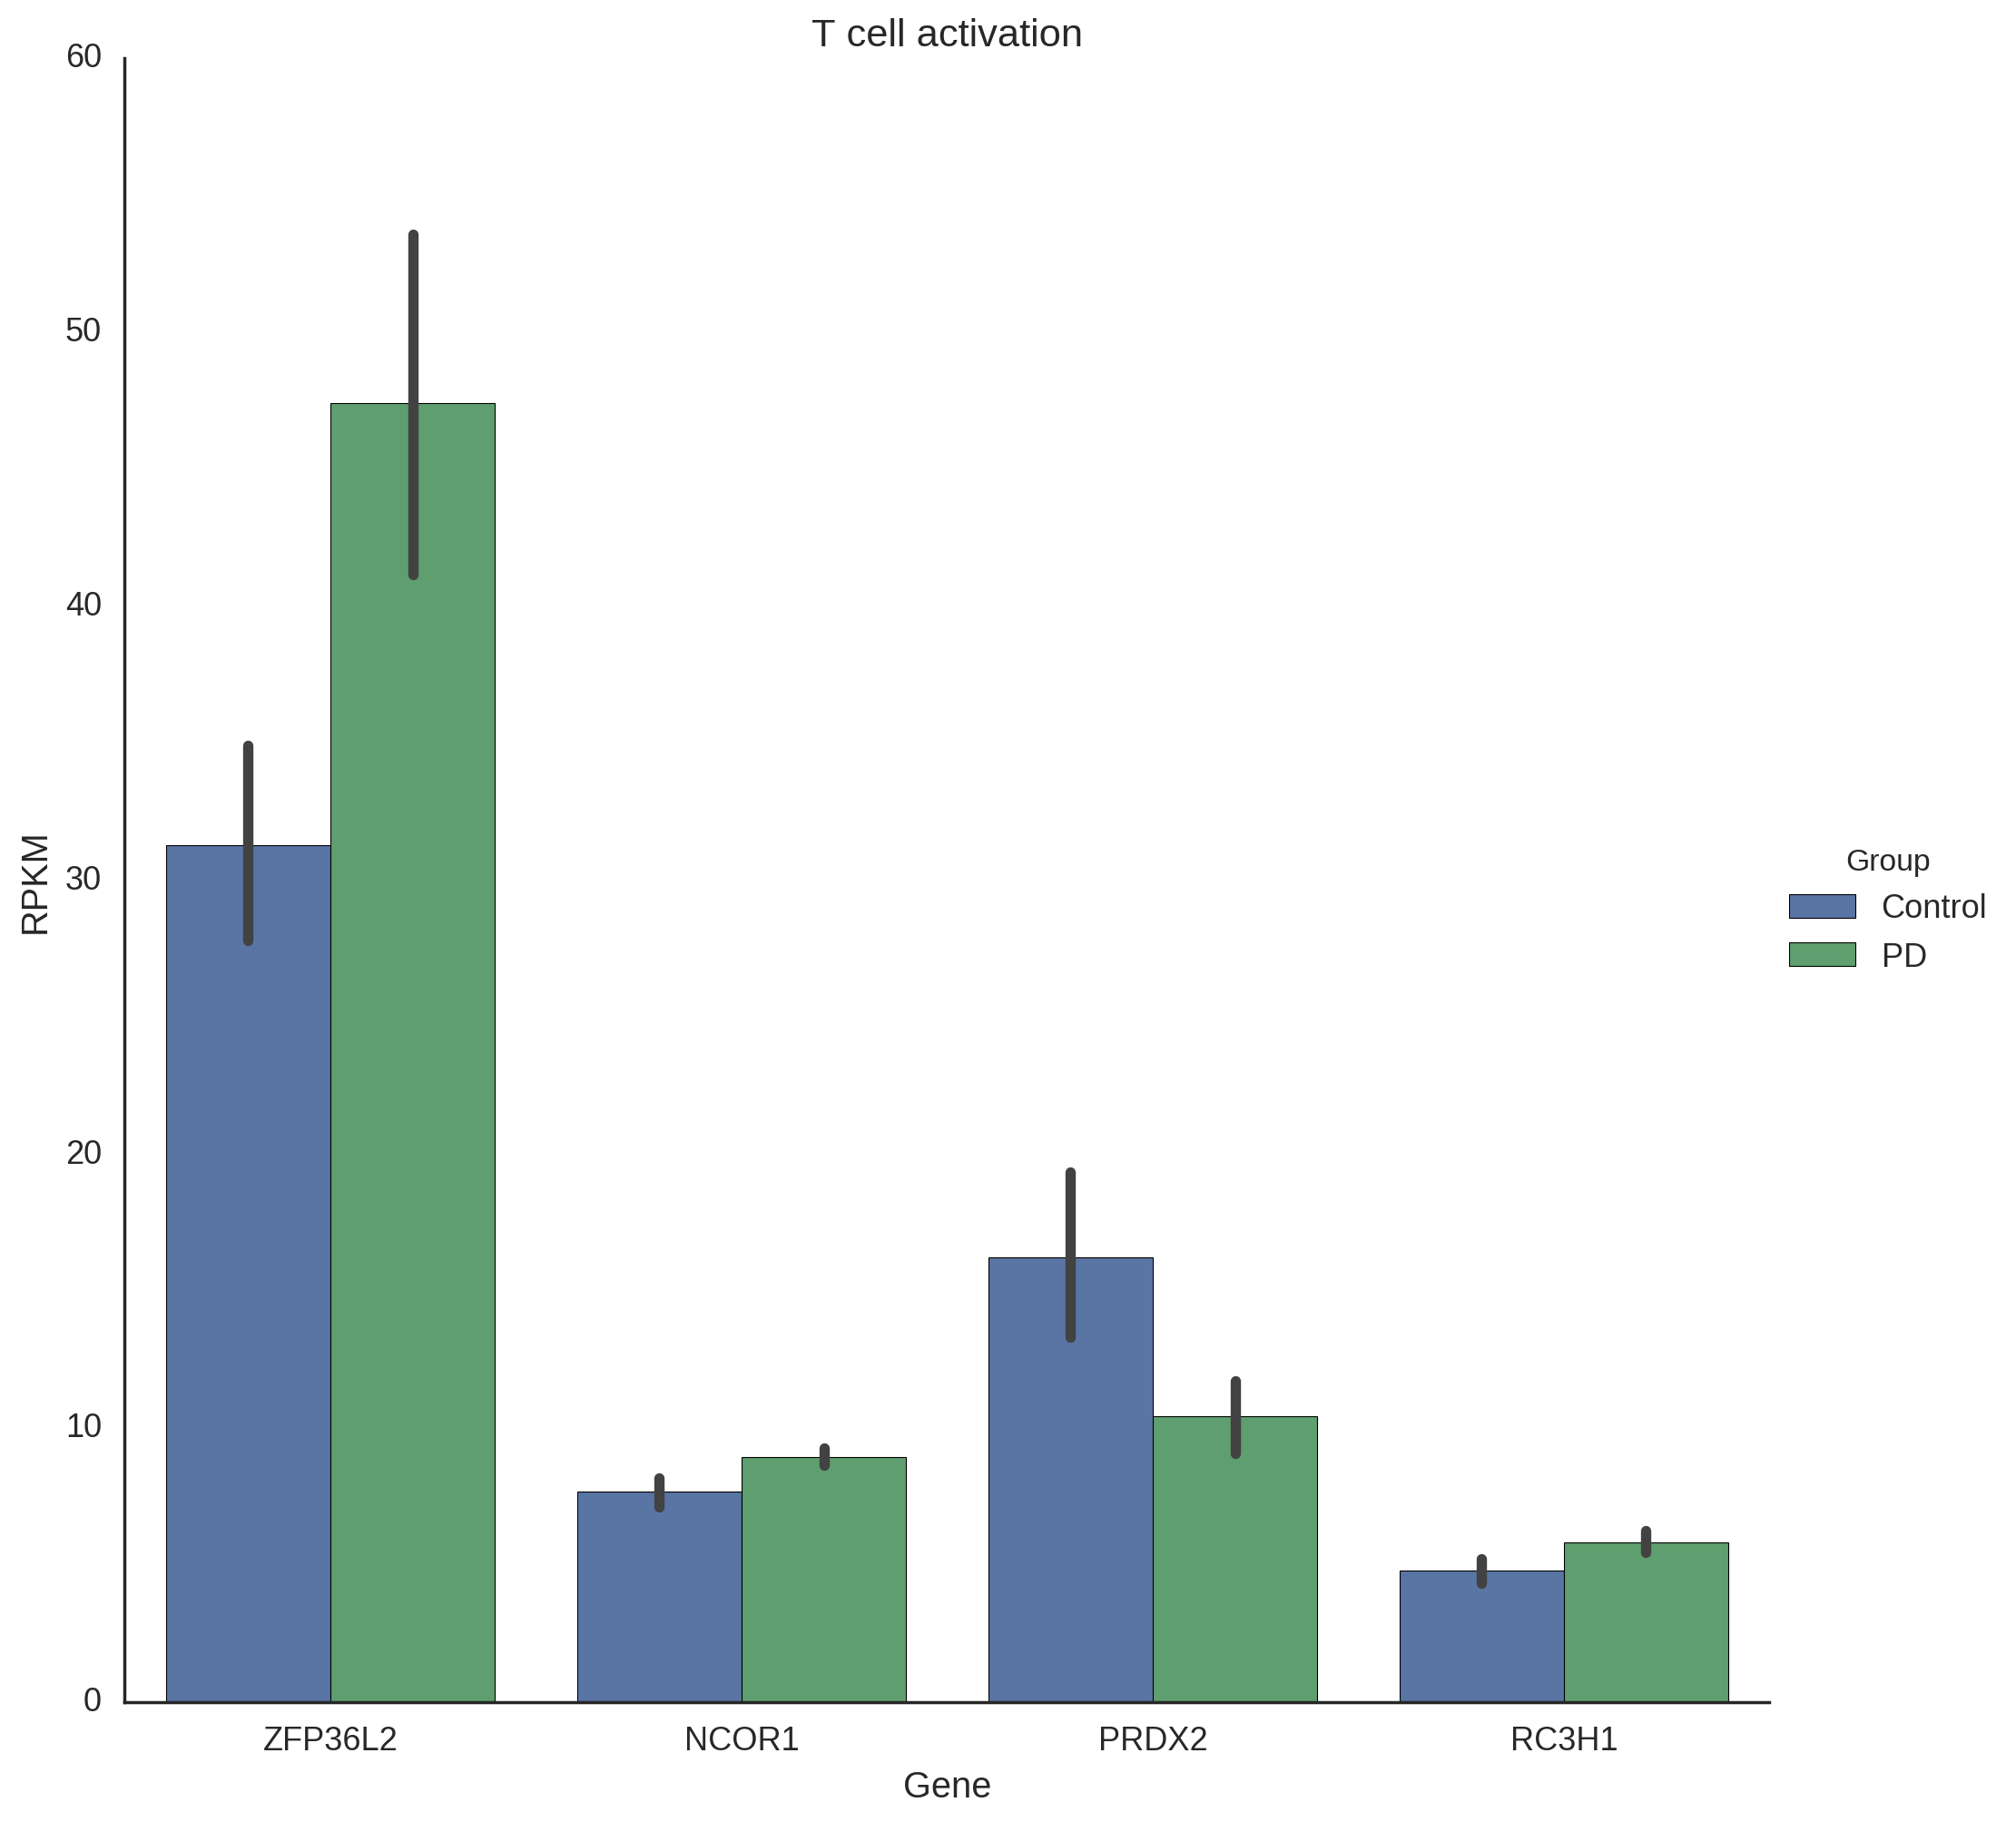

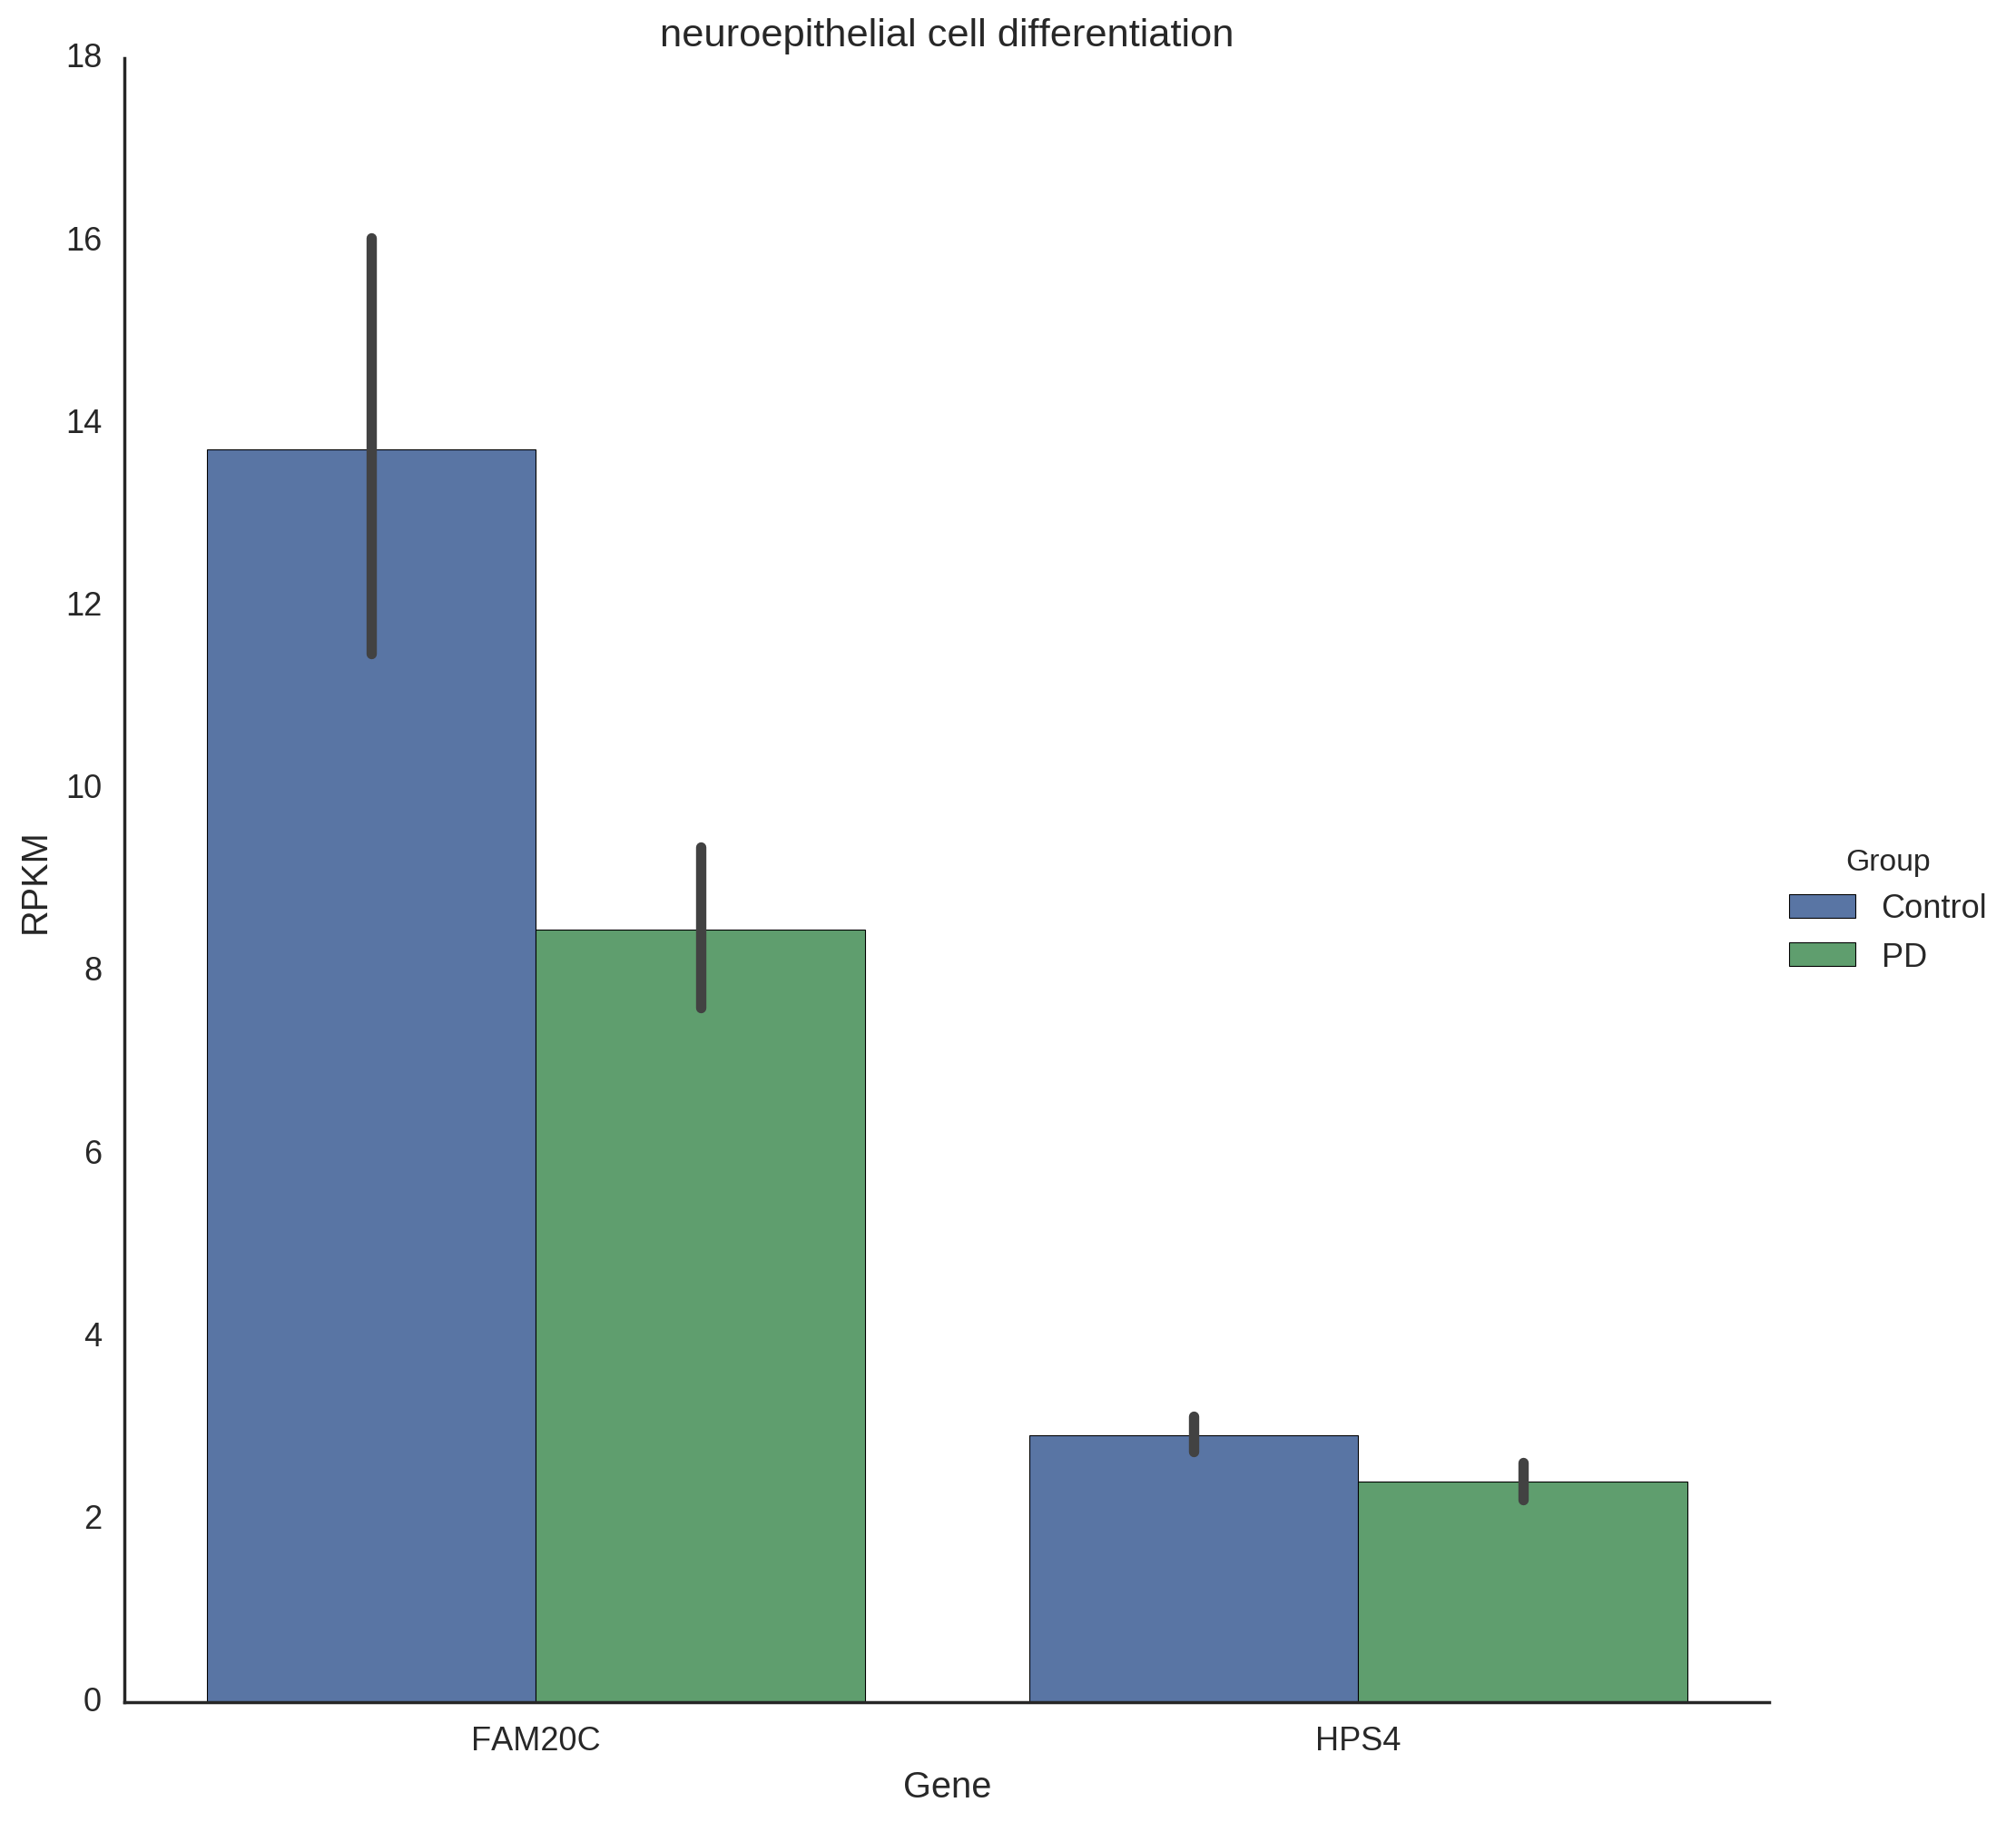

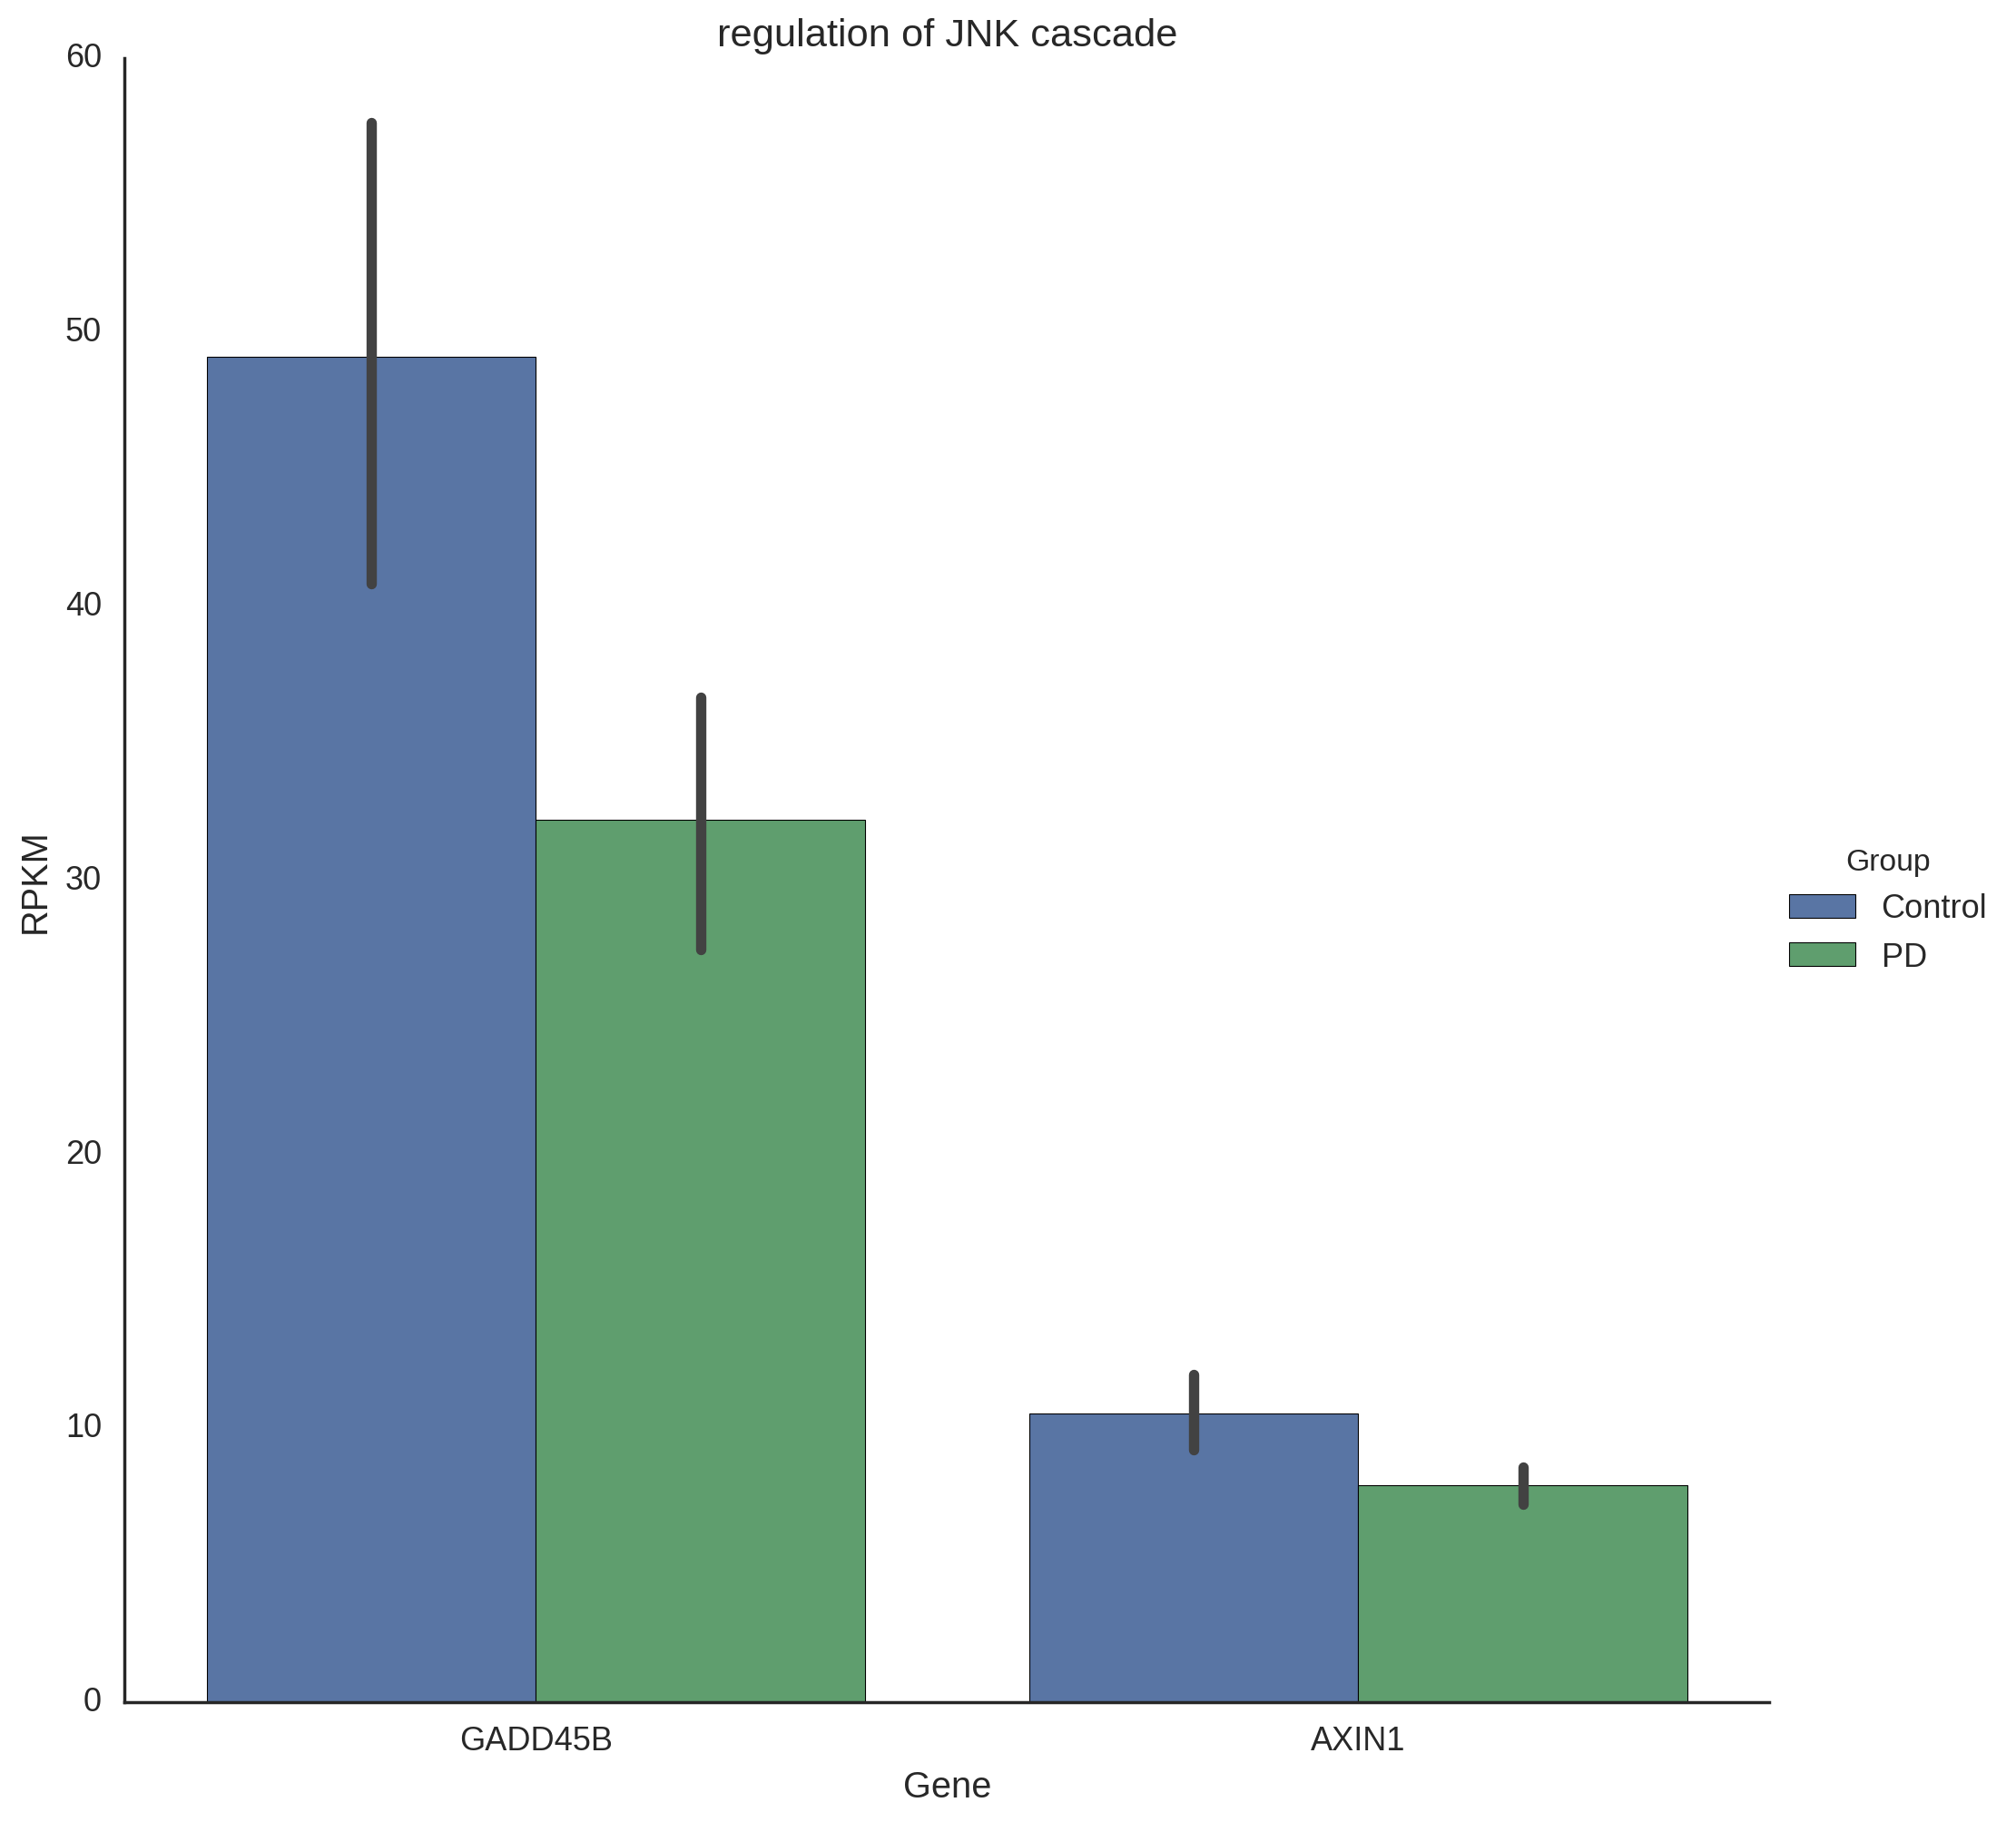

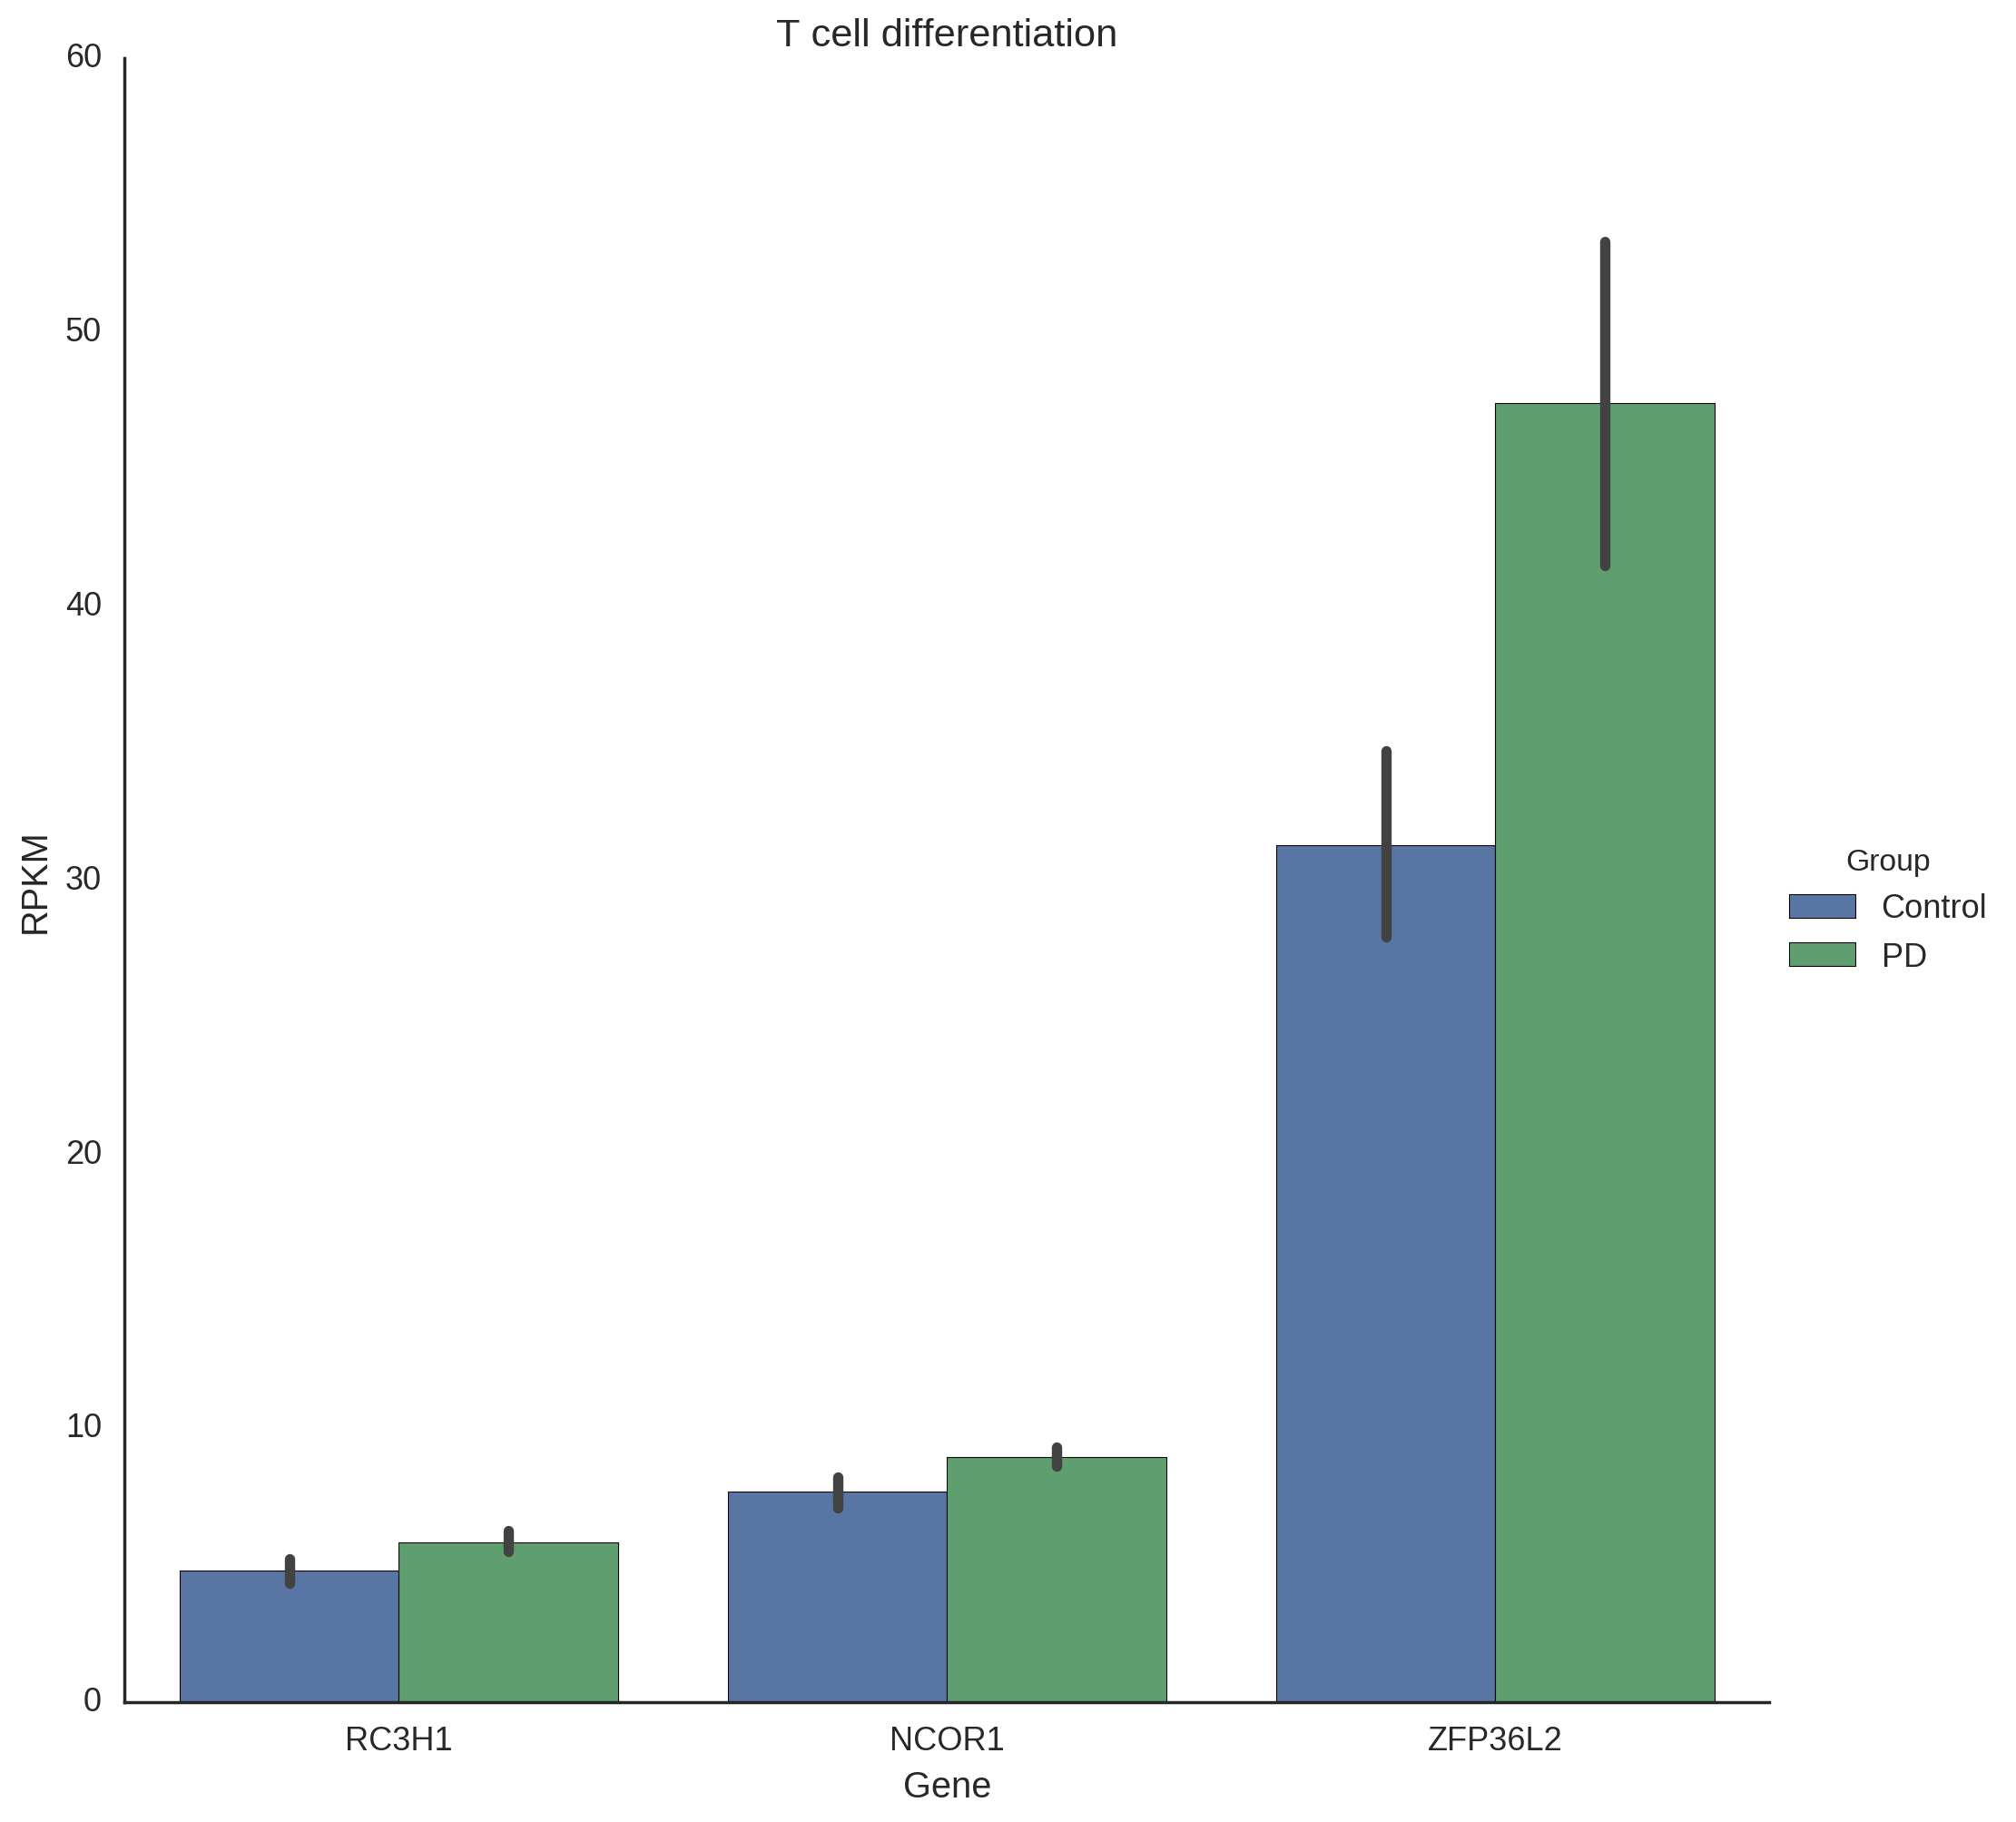

In [526]:
! if [ ! -d ./bar_plots ]; then mkdir ./bar_plots; fi
for term in sorted(set(go_plotting_frame['Term'].values)):
    sns.factorplot(data = go_plotting_frame[go_plotting_frame['Term']==term].sort('p-value'), 
                   x='Gene', 
                   y='RPKM', 
                   hue = 'Group', 
                   kind='bar',
                   hue_order = ['Control', 'PD'],
                   size=10)
    plt.title(term)
    plt.savefig('./bar_plots/'+'_'.join(term.split())+'.pdf')
    plt.show()
sns.factorplot(data = go_plotting_frame[go_plotting_frame['Gene'].isin(['NCOR1','RC3H1','ZFP36L2'])], 
              x='Gene', 
                   y='RPKM', 
                   hue = 'Group', 
                   kind='bar',
                   hue_order = ['Control', 'PD'],
                   size=10)
plt.title('T cell differentiation')
plt.savefig('./bar_plots/'+'_'.join('T cell differentiation'.split())+'.pdf')



In [573]:
data = data=go_plotting_frame

gene_foldChange_dict = dict(zip(stat_frame['gene'], stat_frame['fold change']))
data['fold change'] = [gene_foldChange_dict[x] for x in data['Gene']]

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


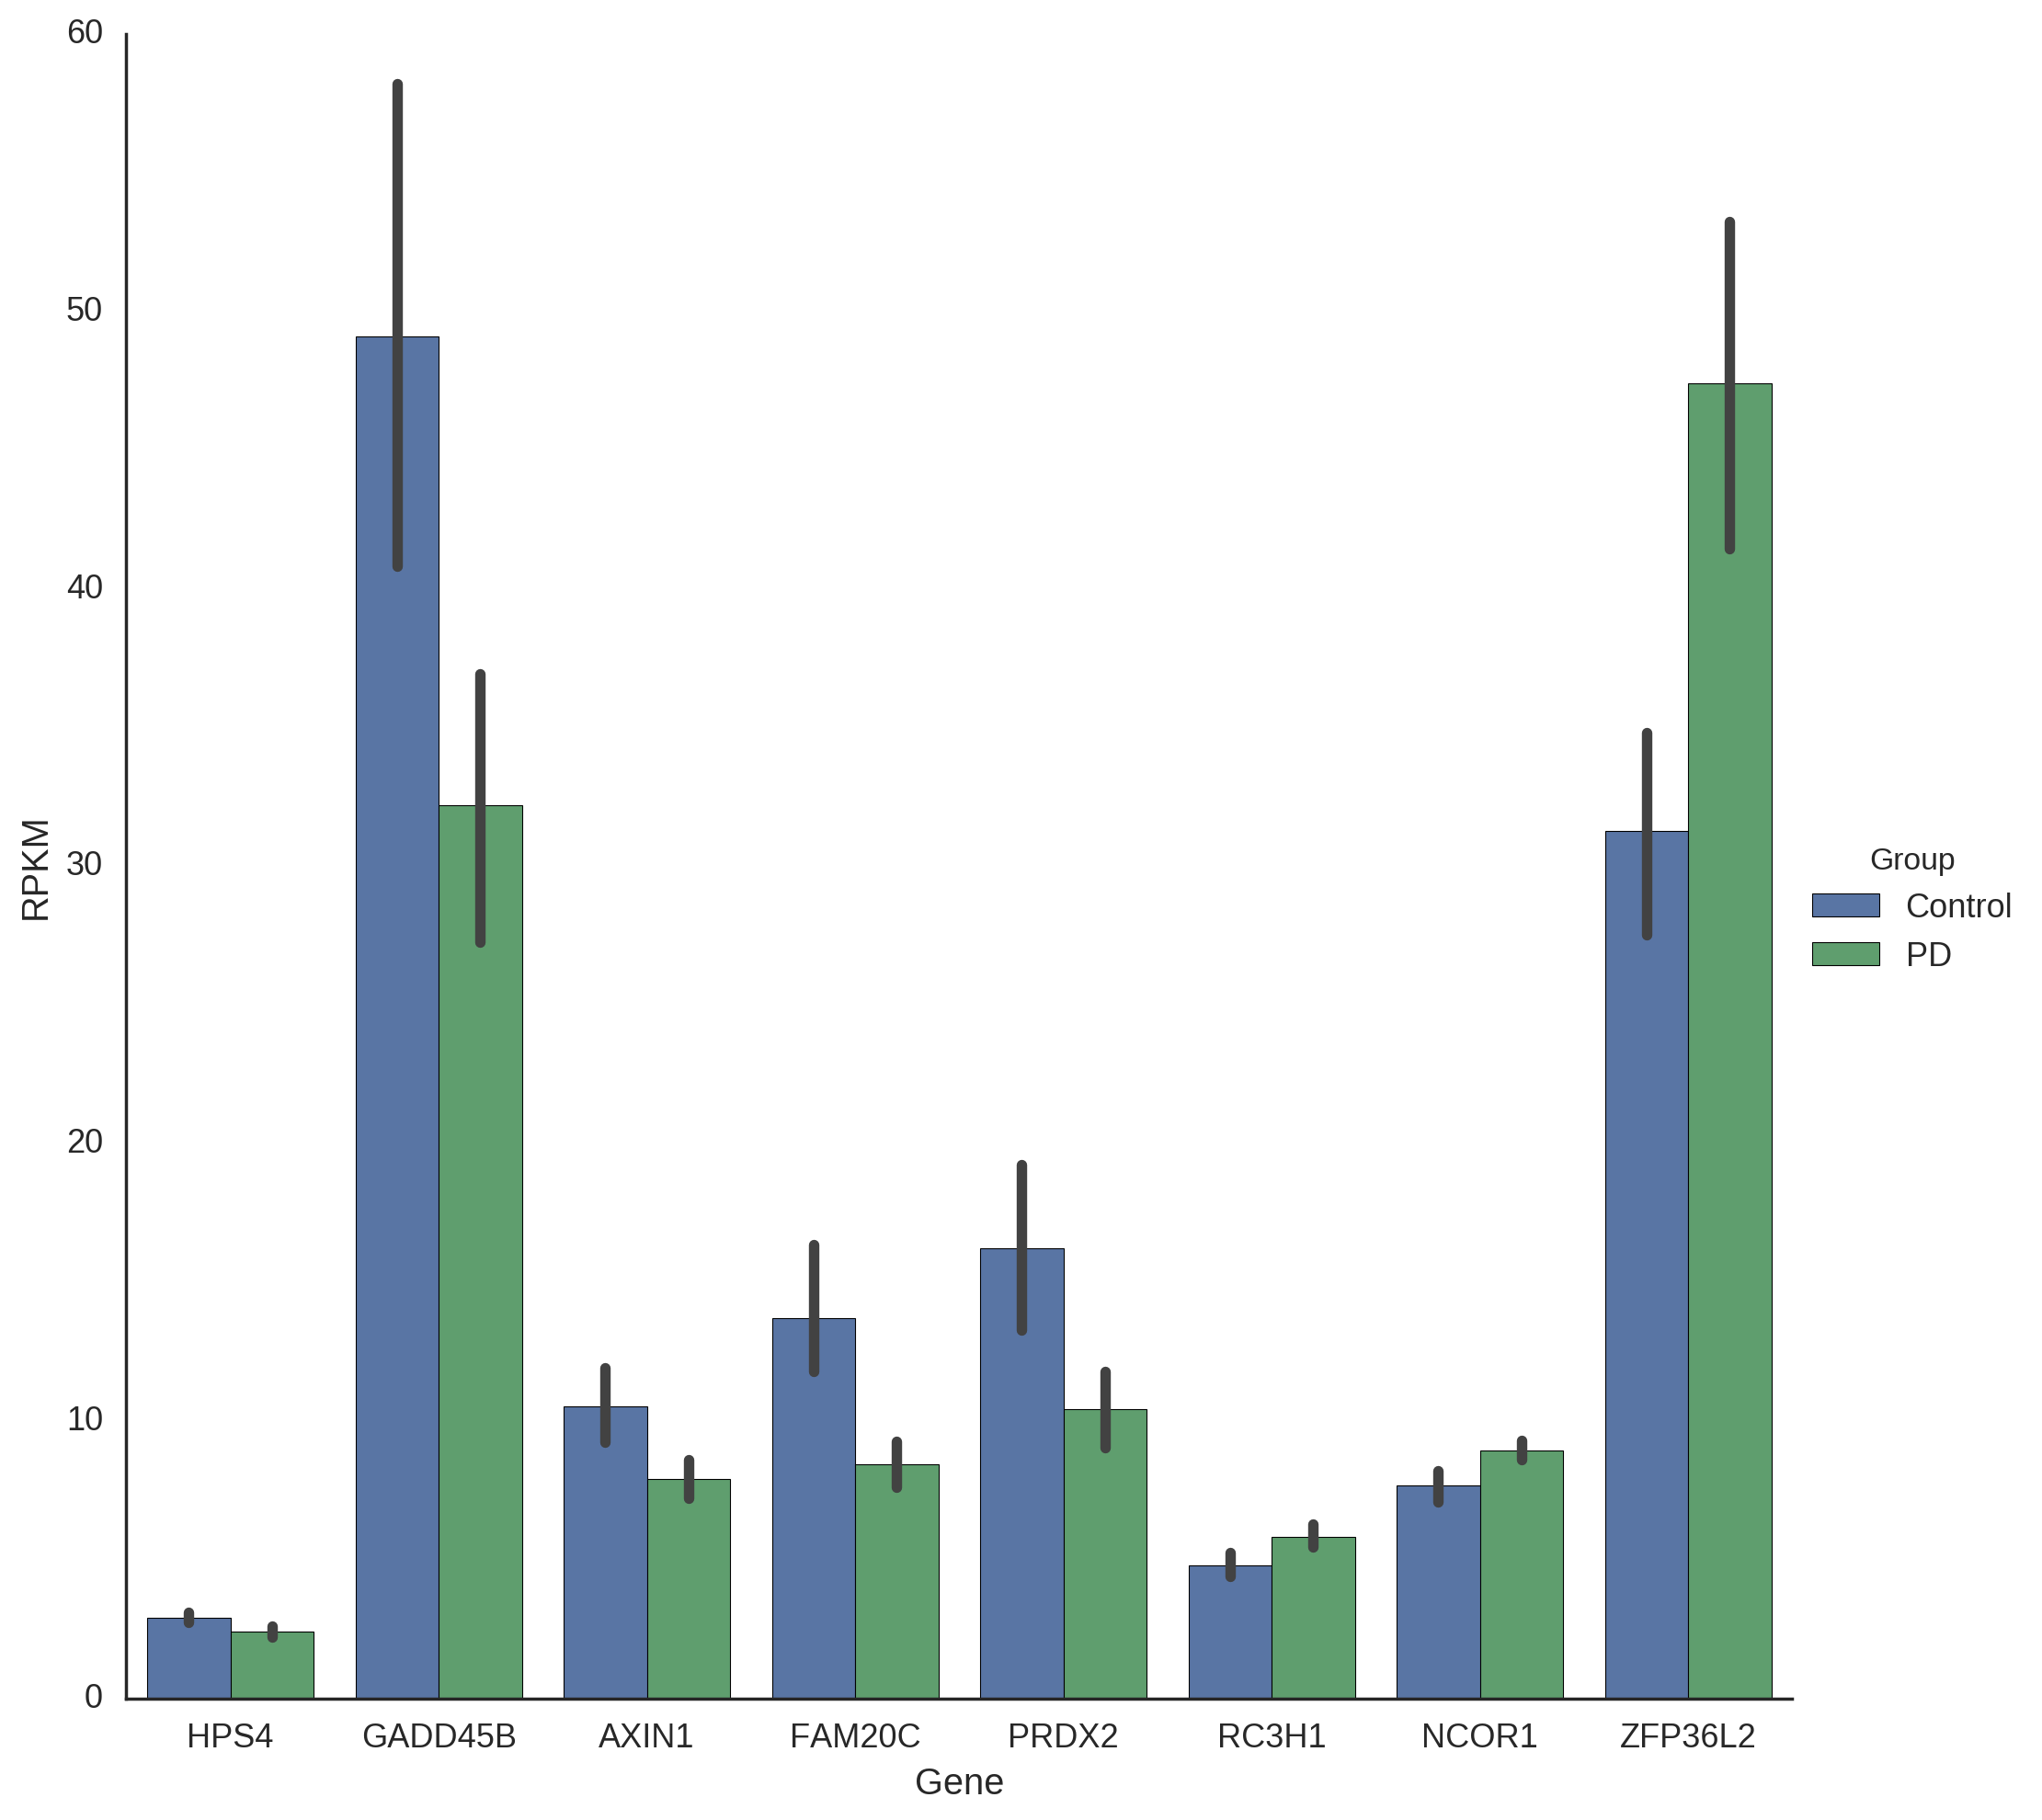

In [575]:
sns.factorplot(x='Gene', 
               y='RPKM', 
               kind='bar',
               data=data, 
               hue='Group',
              size=10)
plt.savefig('bar_plot_all.pdf')